In [7]:
import calendar
import itertools
import json

import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
sns.set("poster")

import results_processor

from importlib import reload
# To make development easier.
reload(results_processor)

<module 'results_processor' from '/Users/dshen/Documents/NREL/code/urbanopt-reopt-telework-project/example_project/results_processor.py'>

## Load all the data

In [8]:
# Location of REopt outputs
RESULTS_DIR = 'reopt_results'
# Location of URBANopt run results
RUN_DIR = 'run'

# All modeled sites
LOCATIONS = [
    "San Diego",
    "Boston",
    "Denver",
    "Fargo",
    "Helena",
    "Honolulu",
    "Miami",
    "Minneapolis",
    "Oklahoma",
    "Orlando",
    "Phoenix",
    "Portland",
    "Richmond"
]

results = results_processor.Results(RESULTS_DIR, RUN_DIR)

## Compare stochastic and non-stochastic results

In [2]:
df = results.to_dataframe({"location": "Fargo"})

# With net metering
net_metered = df.loc[df["net_metering_limit"] != 0]


ax = sns.catplot(x="storage_rebate", y="storage_size_kwh",
            hue="schedules_type",data=net_metered,
            col="utility", kind="violin", height=8.27,
            palette={"stochastic": "g", "default": "k"})
ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle(
    "Optimal Storage Size for PV+, Fargo House w/ Net Metering",
    fontsize=36)
ax.set_xlabels("Storage Rebate ($/kWh)")
ax.set_ylabels("Storage Size (kWh)")


# Without net metering.

no_net_metered = df.loc[df["net_metering_limit"] == 0]

# fig = plt.figure(figsize=(36, 12))
# ax = fig.add_subplot(111)

ax = sns.catplot(x="storage_rebate", y="storage_size_kwh",
            hue="schedules_type",data=no_net_metered,
            col="utility", kind="violin", height=8.27,
            palette={"stochastic": "b", "default": "k"})
ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle(
    "Optimal Storage Size for PV+, Fargo House w/ No Net Metering",
    fontsize=36)
ax.set_xlabels("Storage Rebate ($/kWh)")
ax.set_ylabels("Storage Size (kWh)")

NameError: name 'results' is not defined

In [118]:
def make_cat_plot(df, location, x="storage_rebate", y="storage_size_kwh",
                  net_metering=False, title=""):
    ax = sns.catplot(x=x, y=y,
                hue="schedules_type",data=df,
                col="utility", kind="violin", height=8.27,
                palette={"stochastic": "g", "default": "k"})
    ax.fig.subplots_adjust(top=0.8)
    
    n = len(df["building_id"].unique())
    
    if net_metering:
        suffix = f"{location} House w/ Net Metering, n={n}"
    else:
        suffix = f"{location} House w/out Net Metering, n={n}"
    
    if not title:
        ax.fig.suptitle(
            f"Optimal {y} for PV+, {suffix}", fontsize=36)
    else:
        ax.fig.suptitle(f"{title}, {suffix}", fontsize=36)


def make_cat_plots(df, location, lower_rebate_limit=200):
    """
    Generate cat plots for storage and PV for a site.
    
    :param df: DataFrame with data for a single site.
    :param float lower_rebate_limit: Lower rebate limit for plots..
    :param str location: Site location.
    """
    filtered = df.loc[df["storage_rebate"] >= lower_rebate_limit]
    
    net_metered = filtered.loc[df["net_metering_limit"] != 0]
    no_net_metered = filtered.loc[df["net_metering_limit"] == 0]
    
    # PV, net metering
    make_cat_plot(net_metered, location, "storage_rebate", "pv_size",
                  net_metering=True, title="Optimal PV Size size for PV+")
    # Storage, net metering
    make_cat_plot(net_metered, location, "storage_rebate", "storage_size_kwh",
                  net_metering=True, title="Optimal Storage Size size for PV+")
    
    # PV, no net metering
    make_cat_plot(no_net_metered, location, "storage_rebate", "pv_size",
                  net_metering=False, title="Optimal PV Size size for PV+")
    # Storage, net metering
    make_cat_plot(no_net_metered, location, "storage_rebate", "storage_size_kwh",
                  net_metering=False, title="Optimal Storage Size size for PV+")


/Users/dshen/opt/anaconda3/envs/urbanopt/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


ValueError: min() arg is an empty sequence

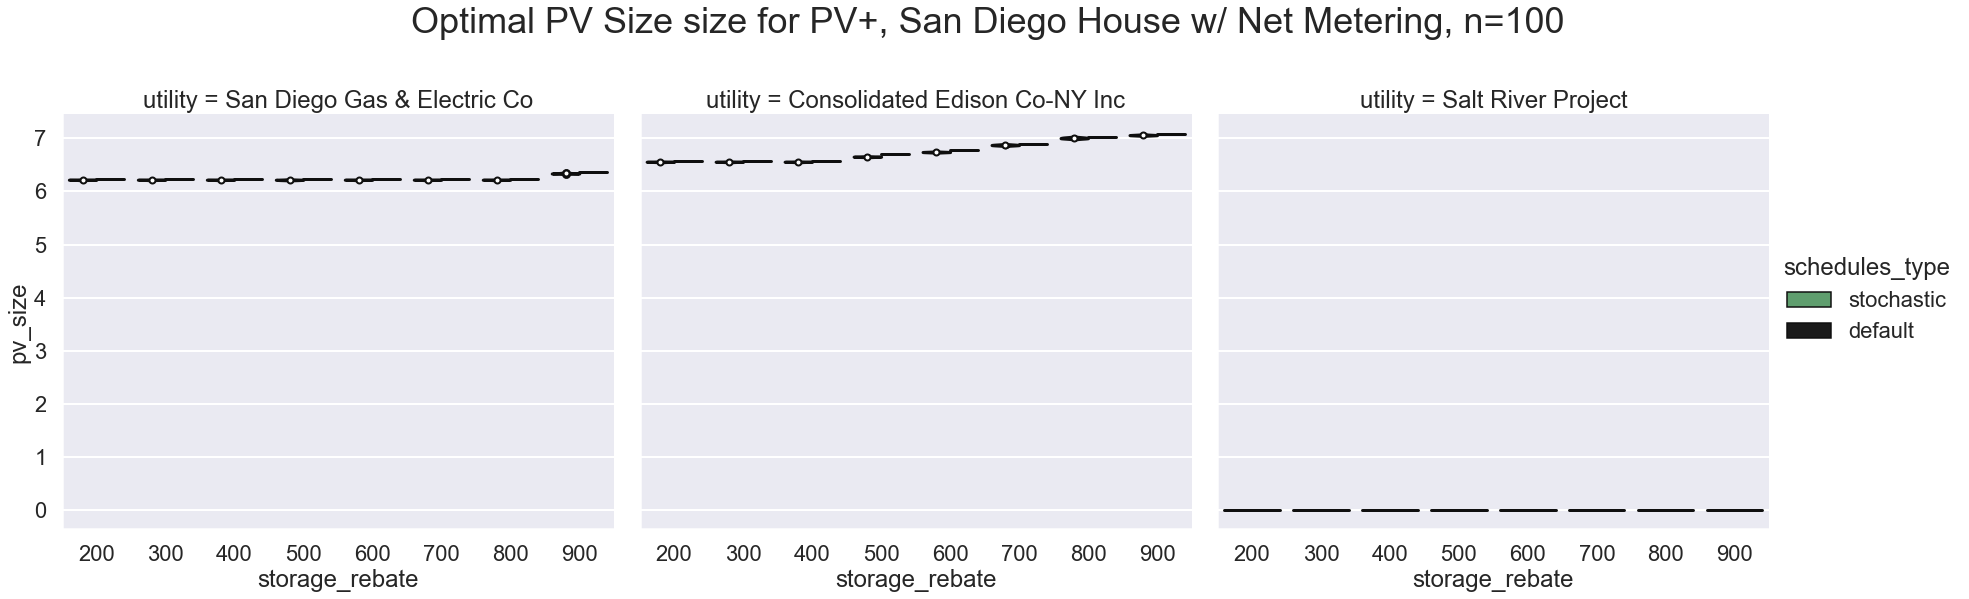

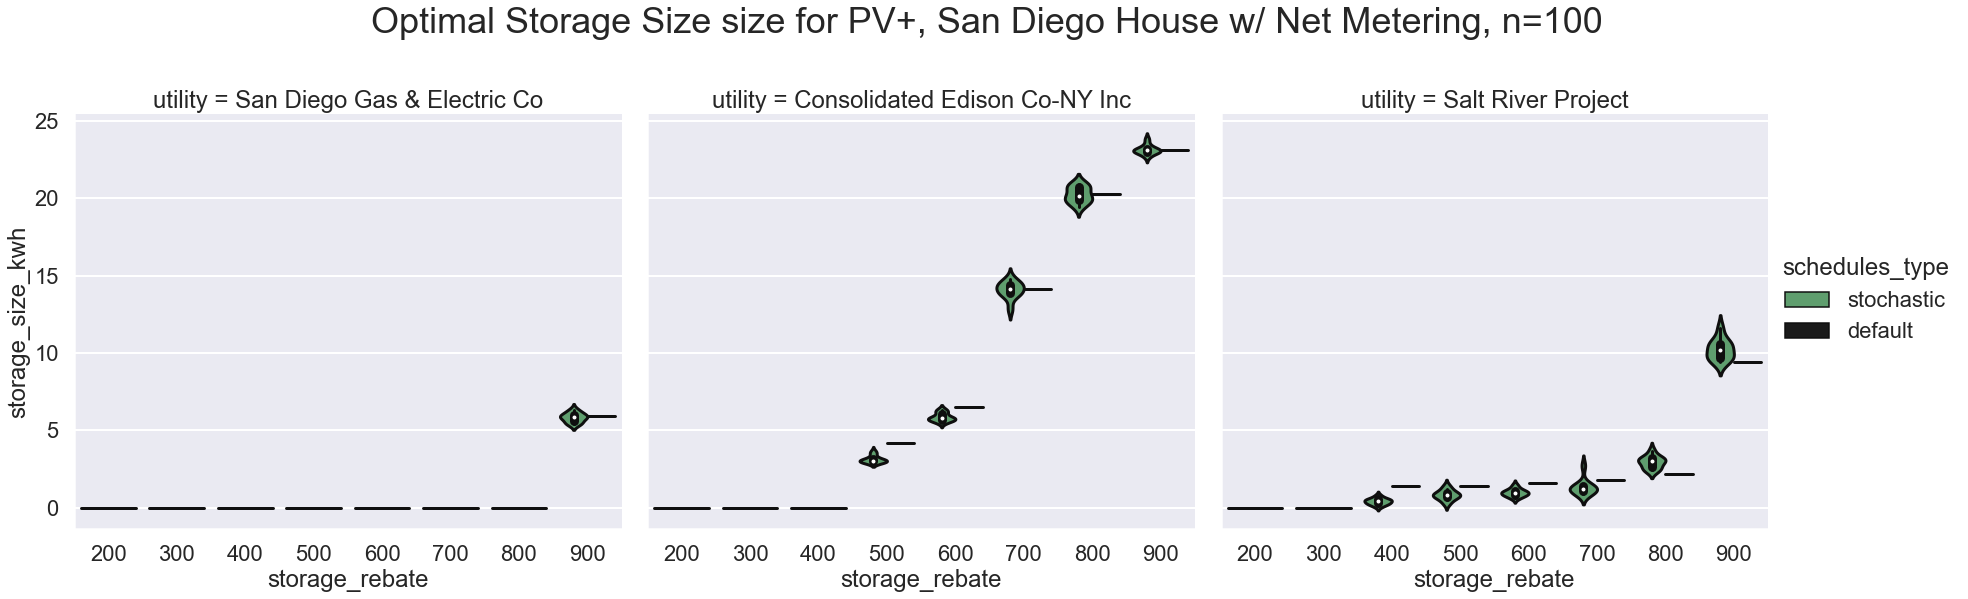

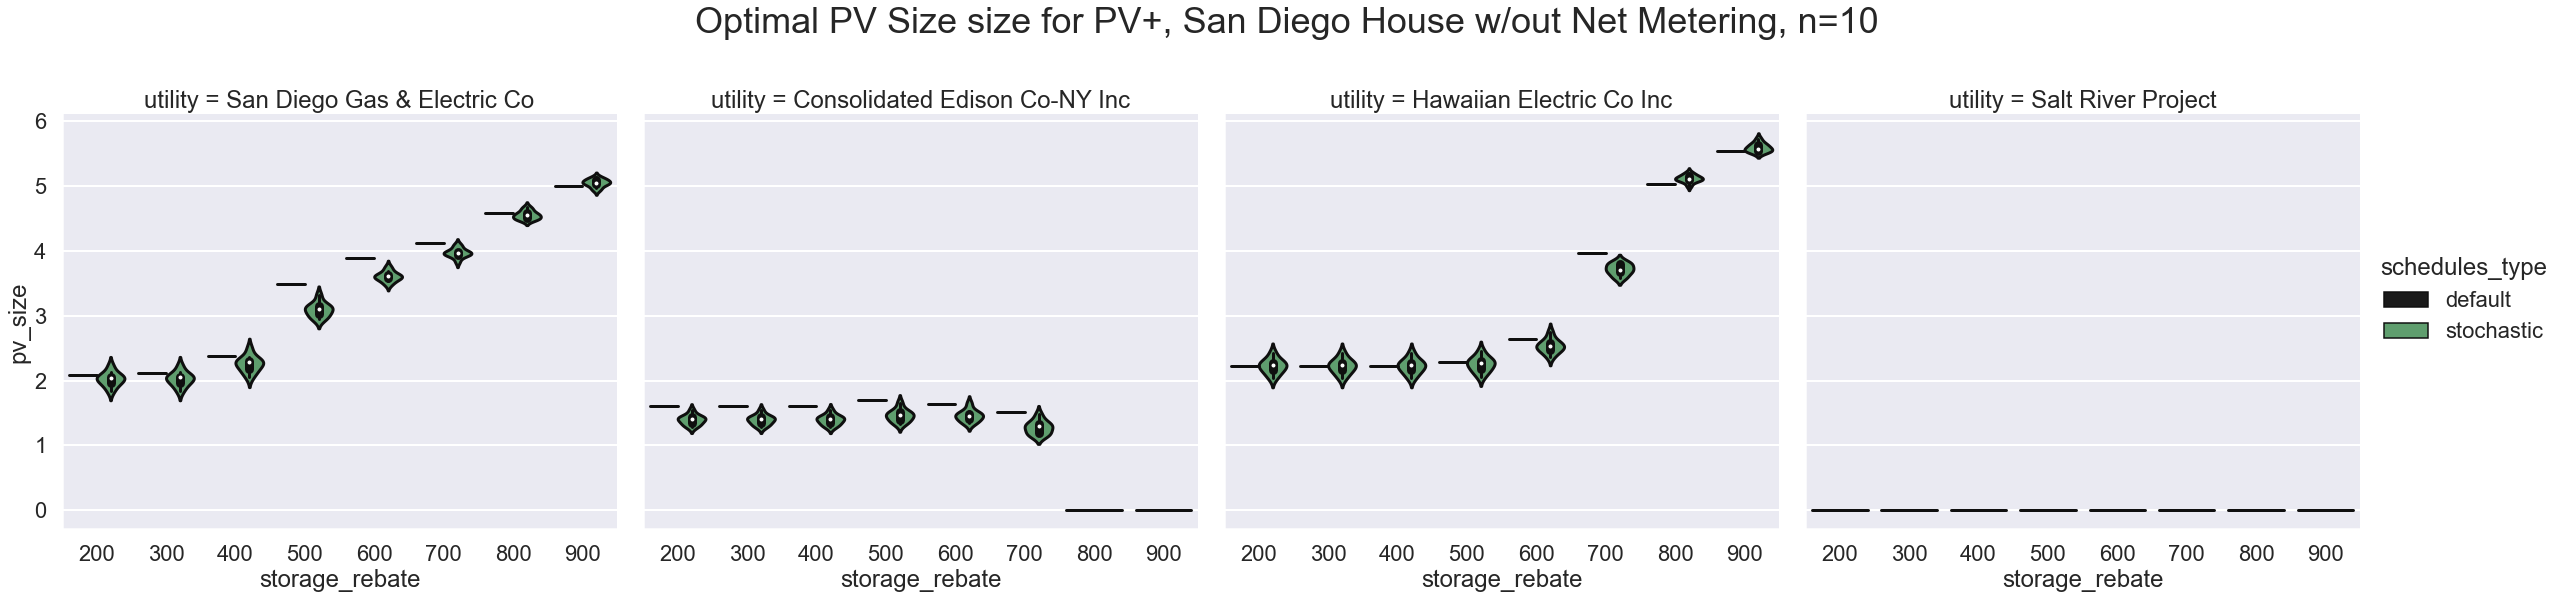

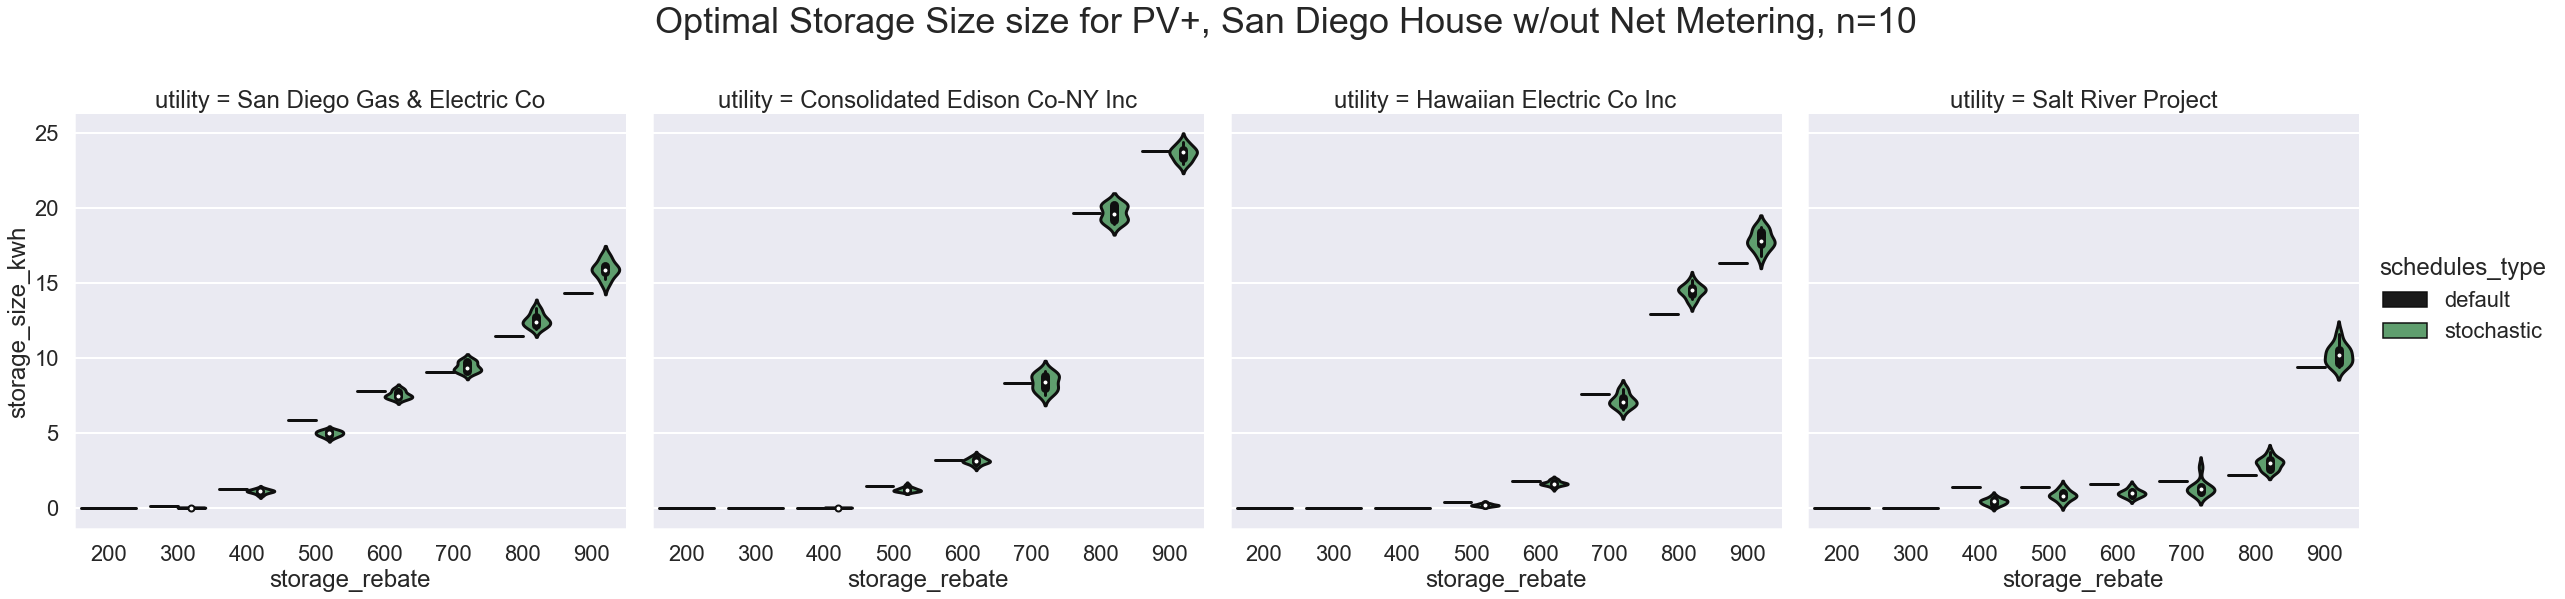

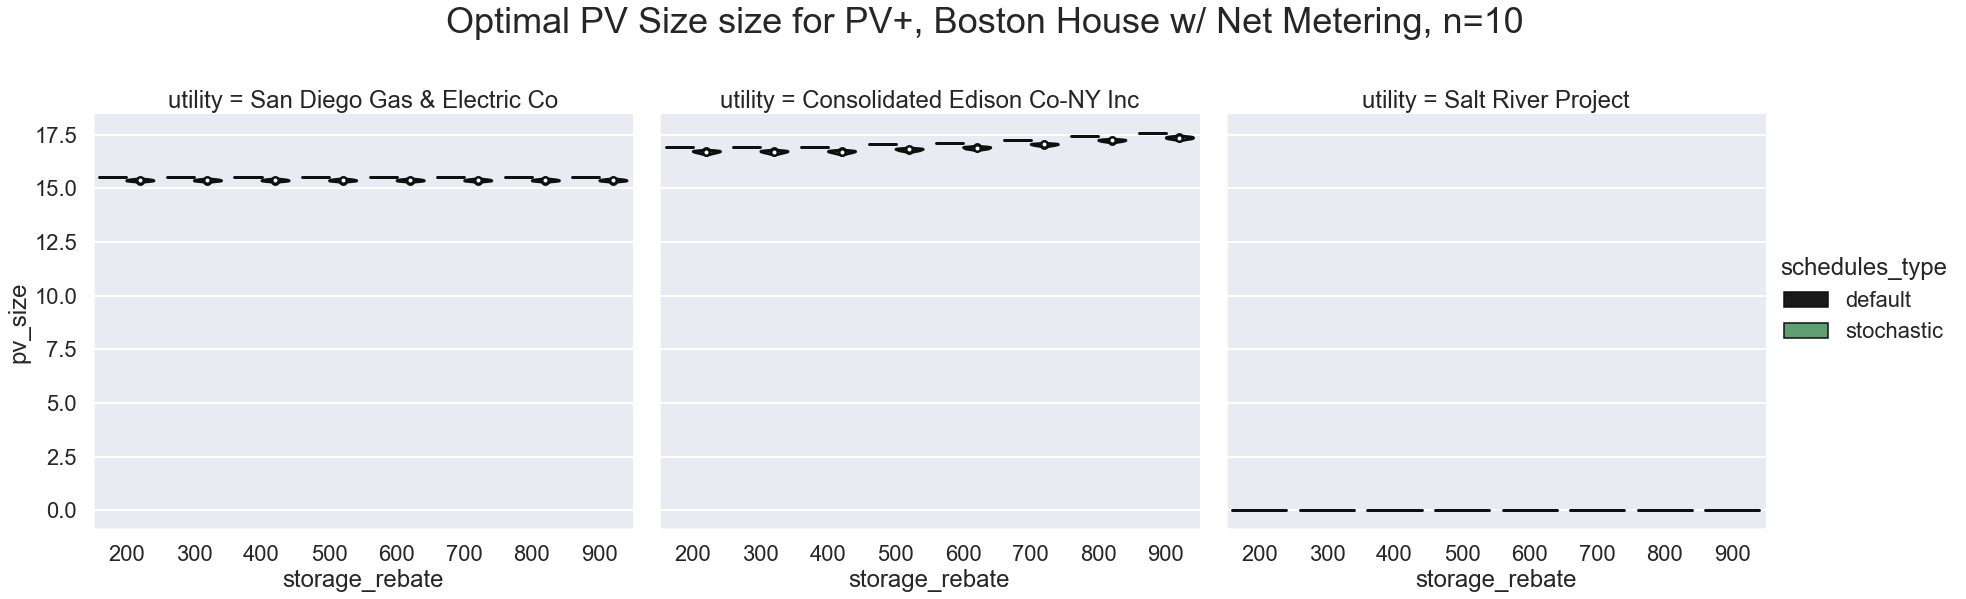

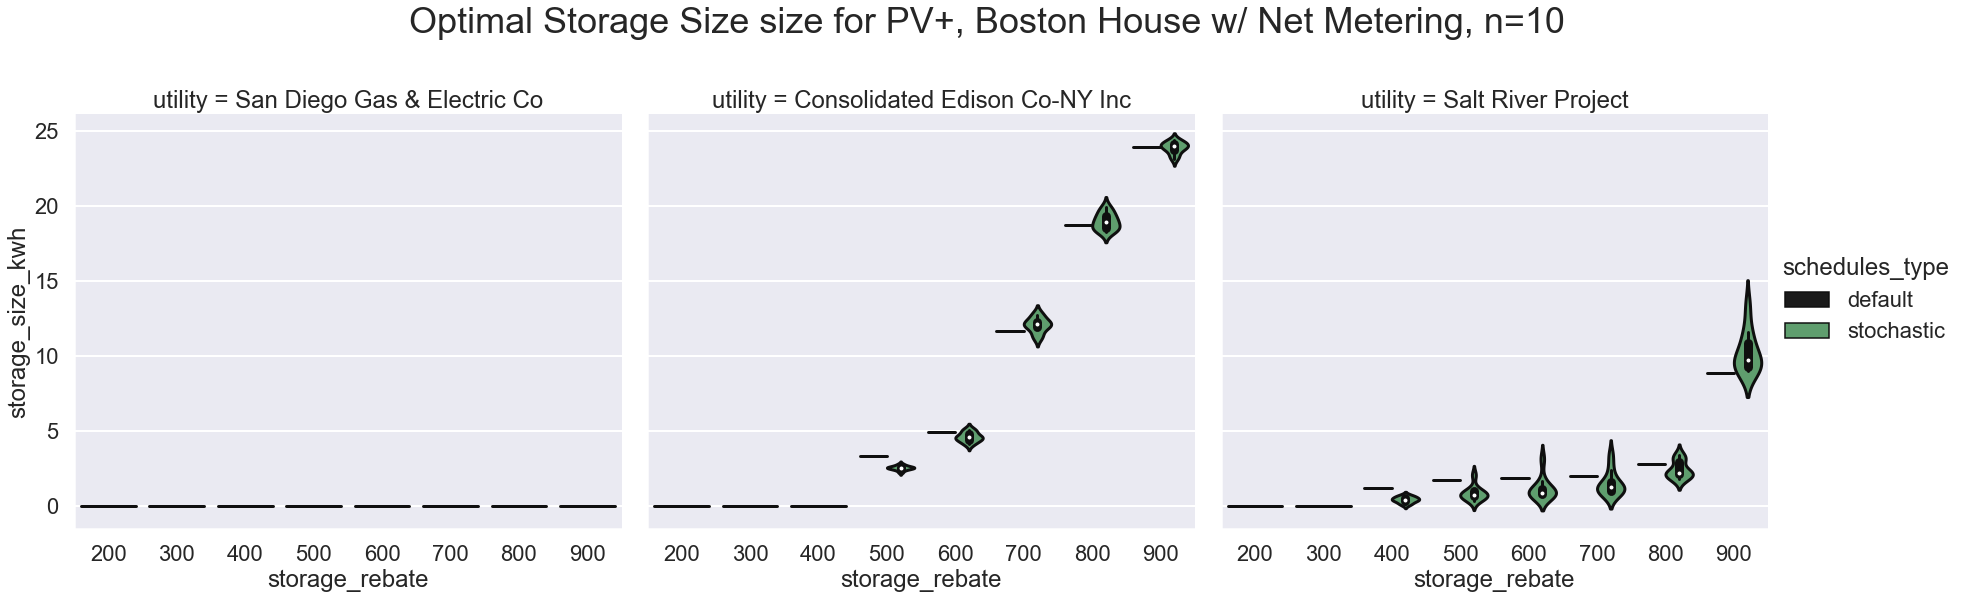

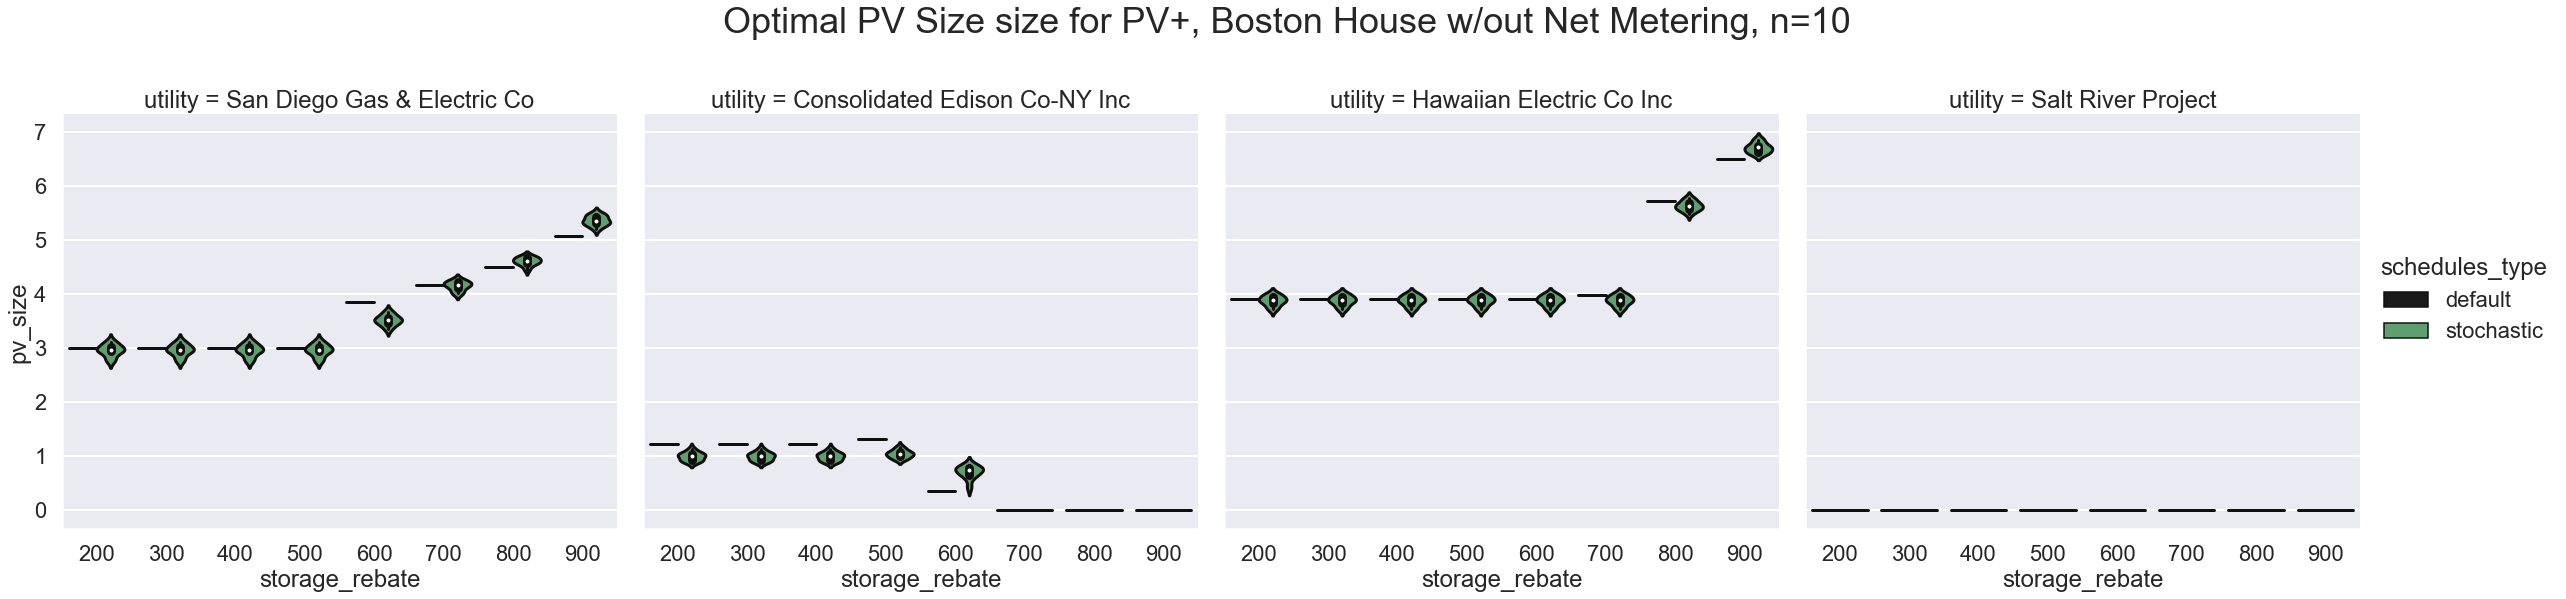

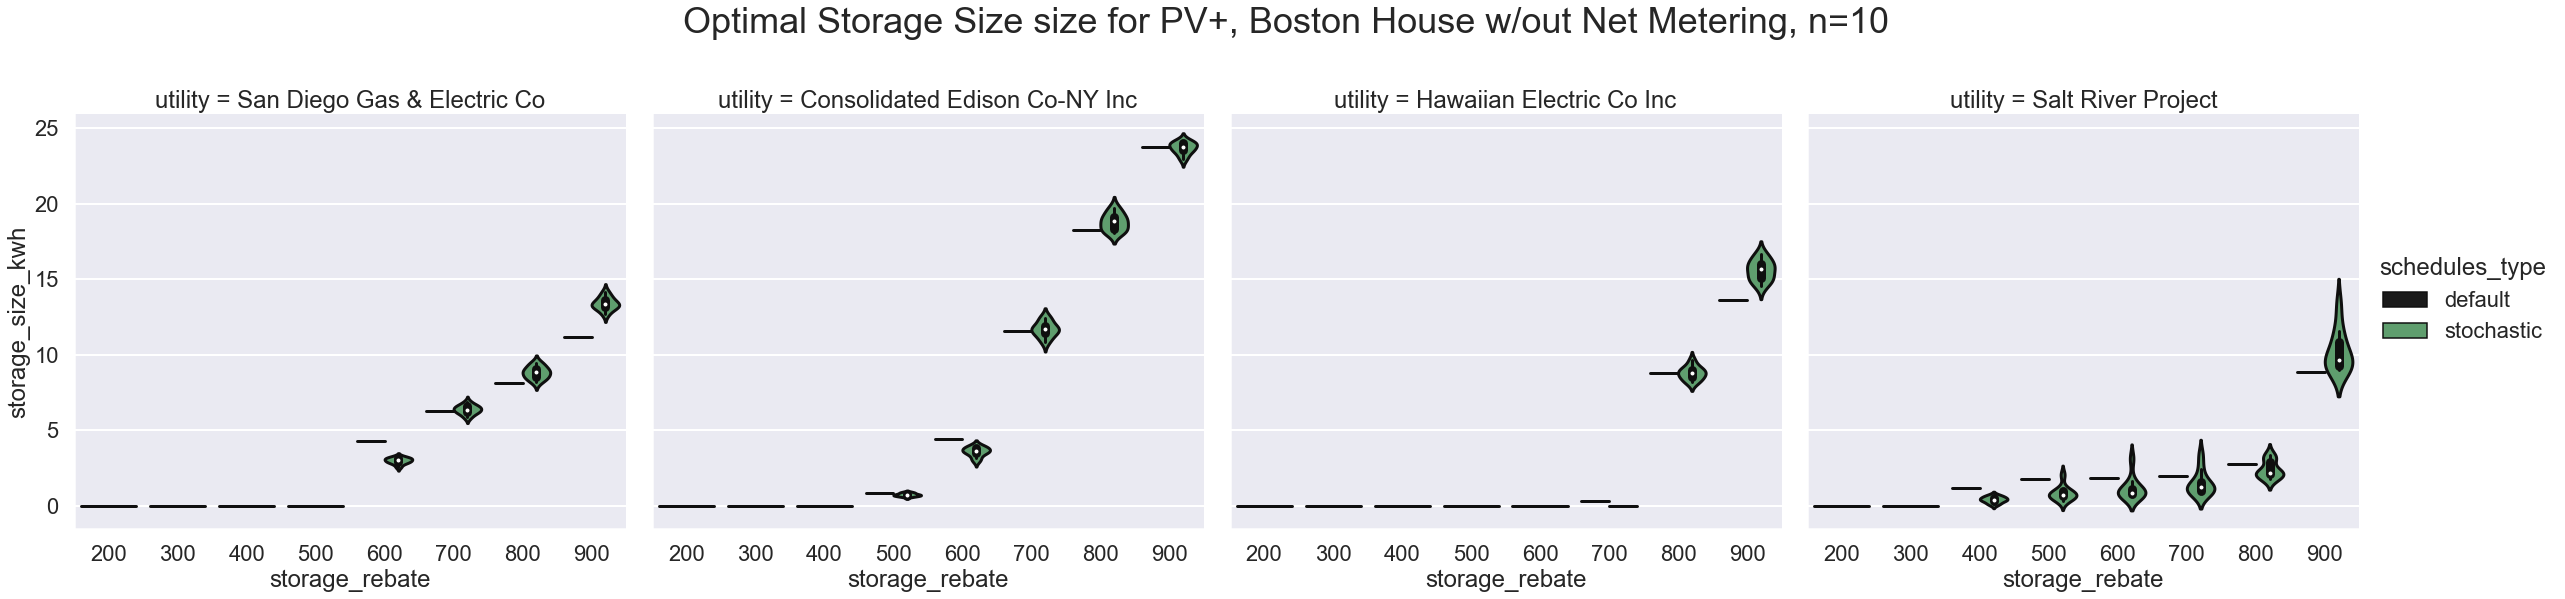

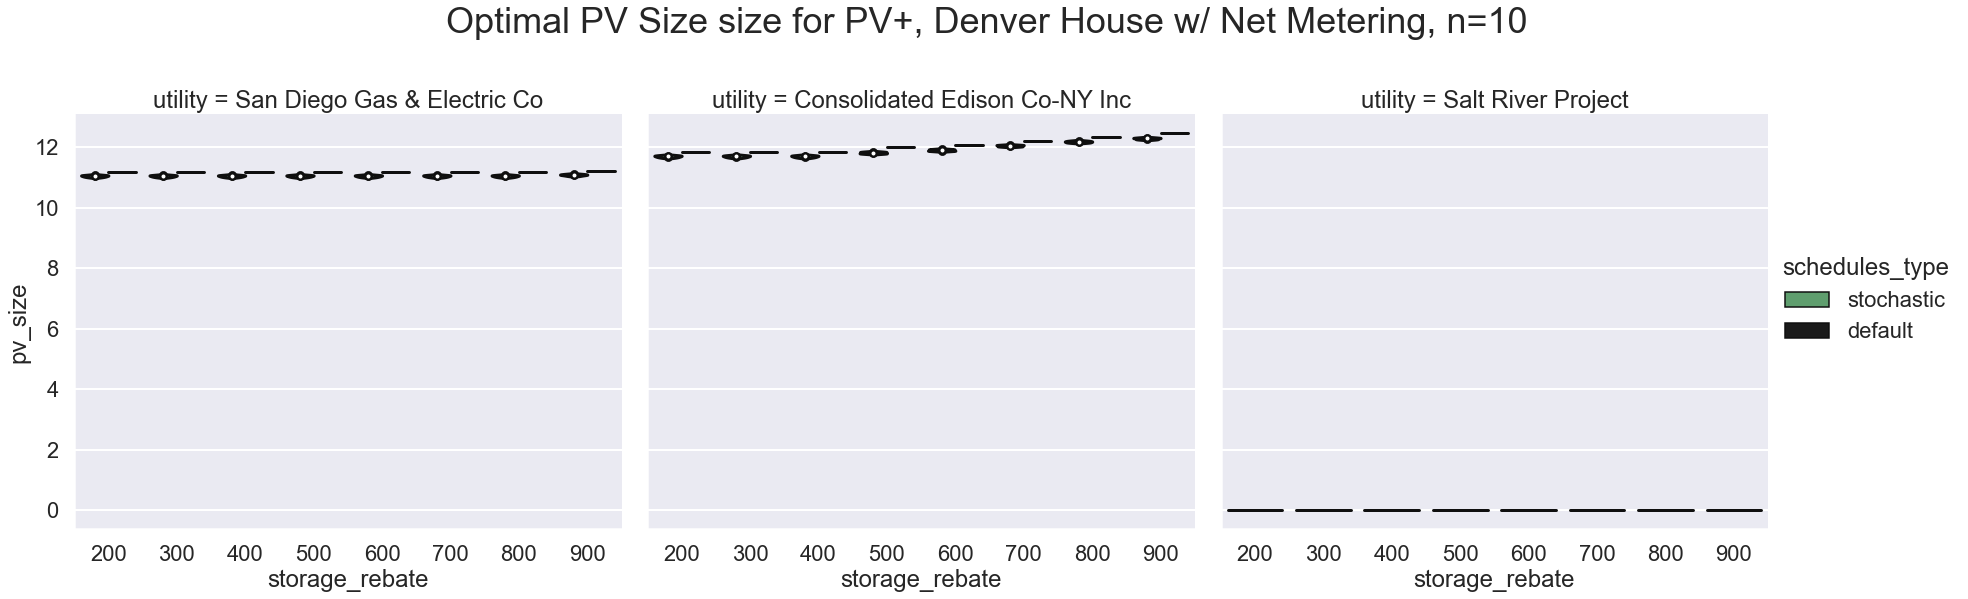

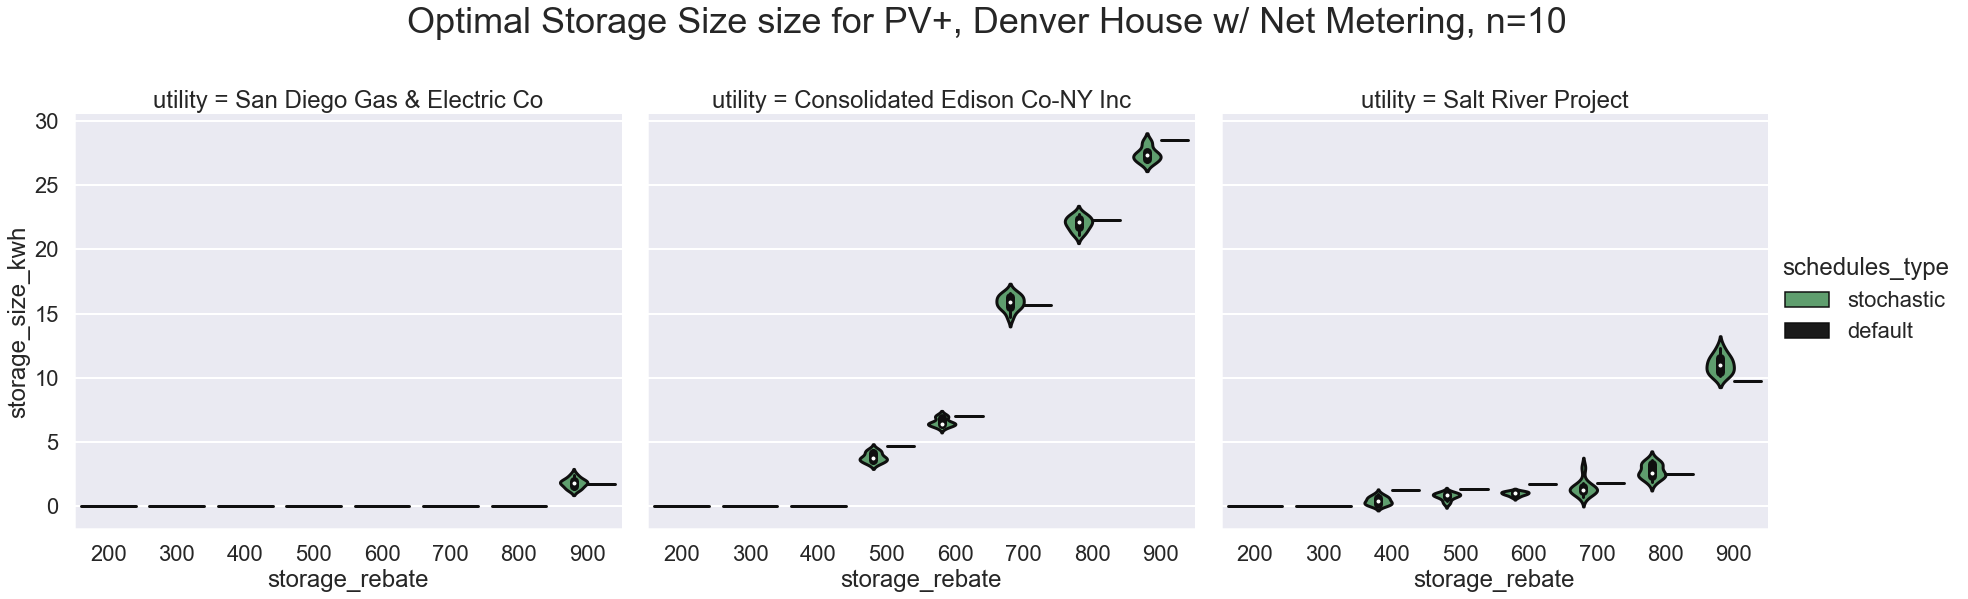

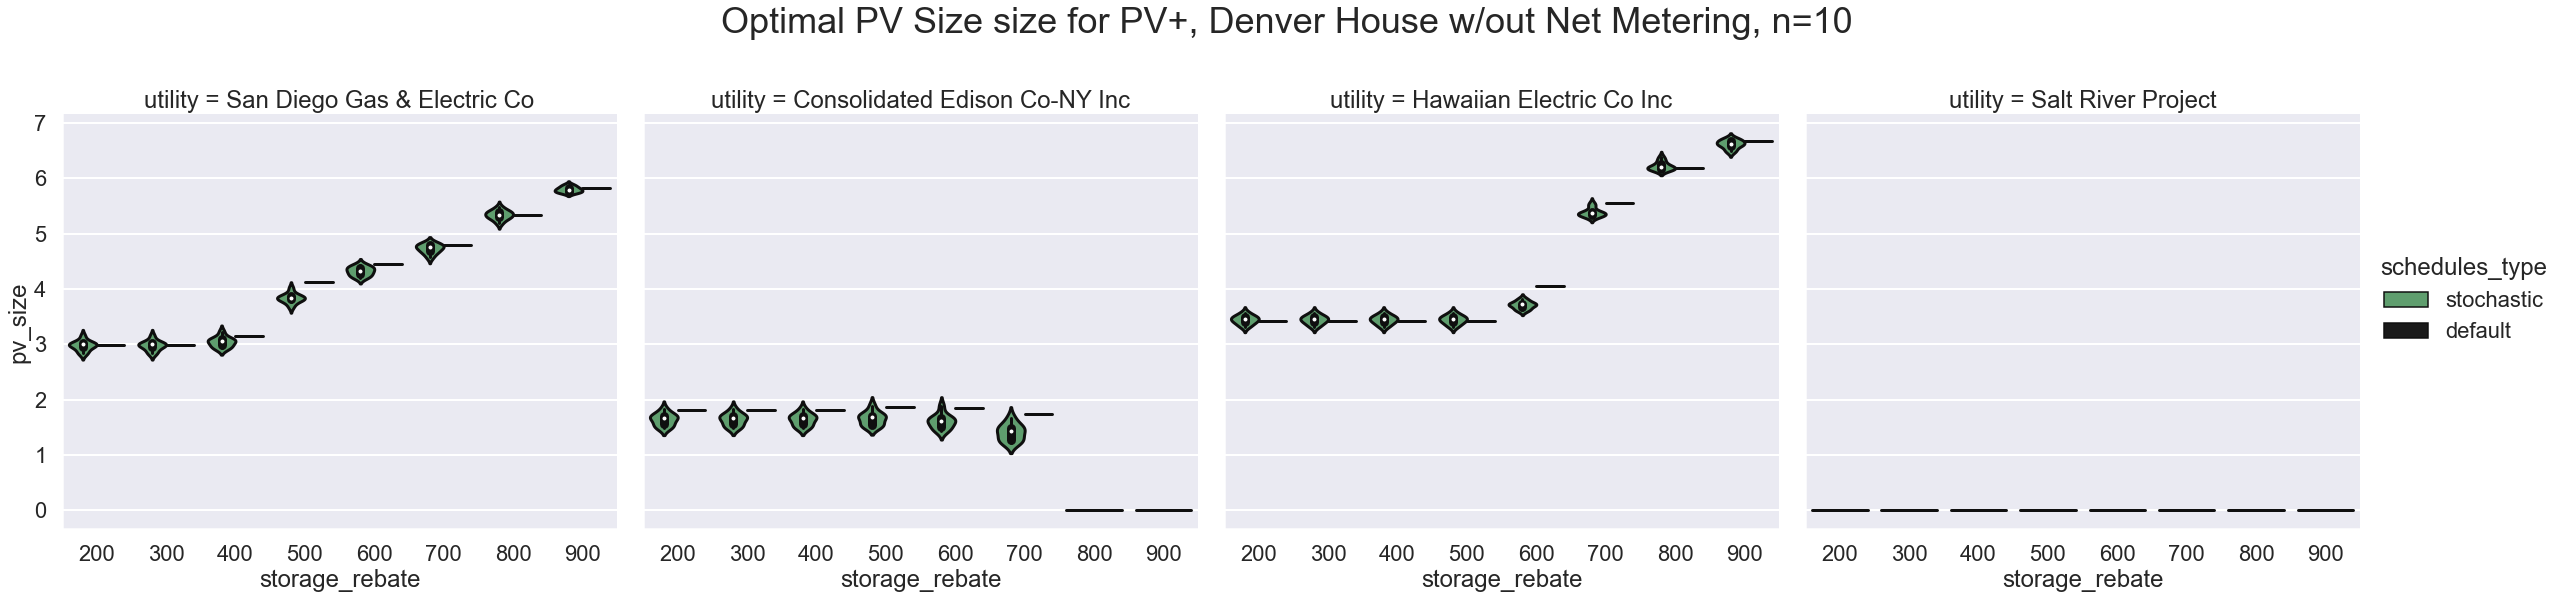

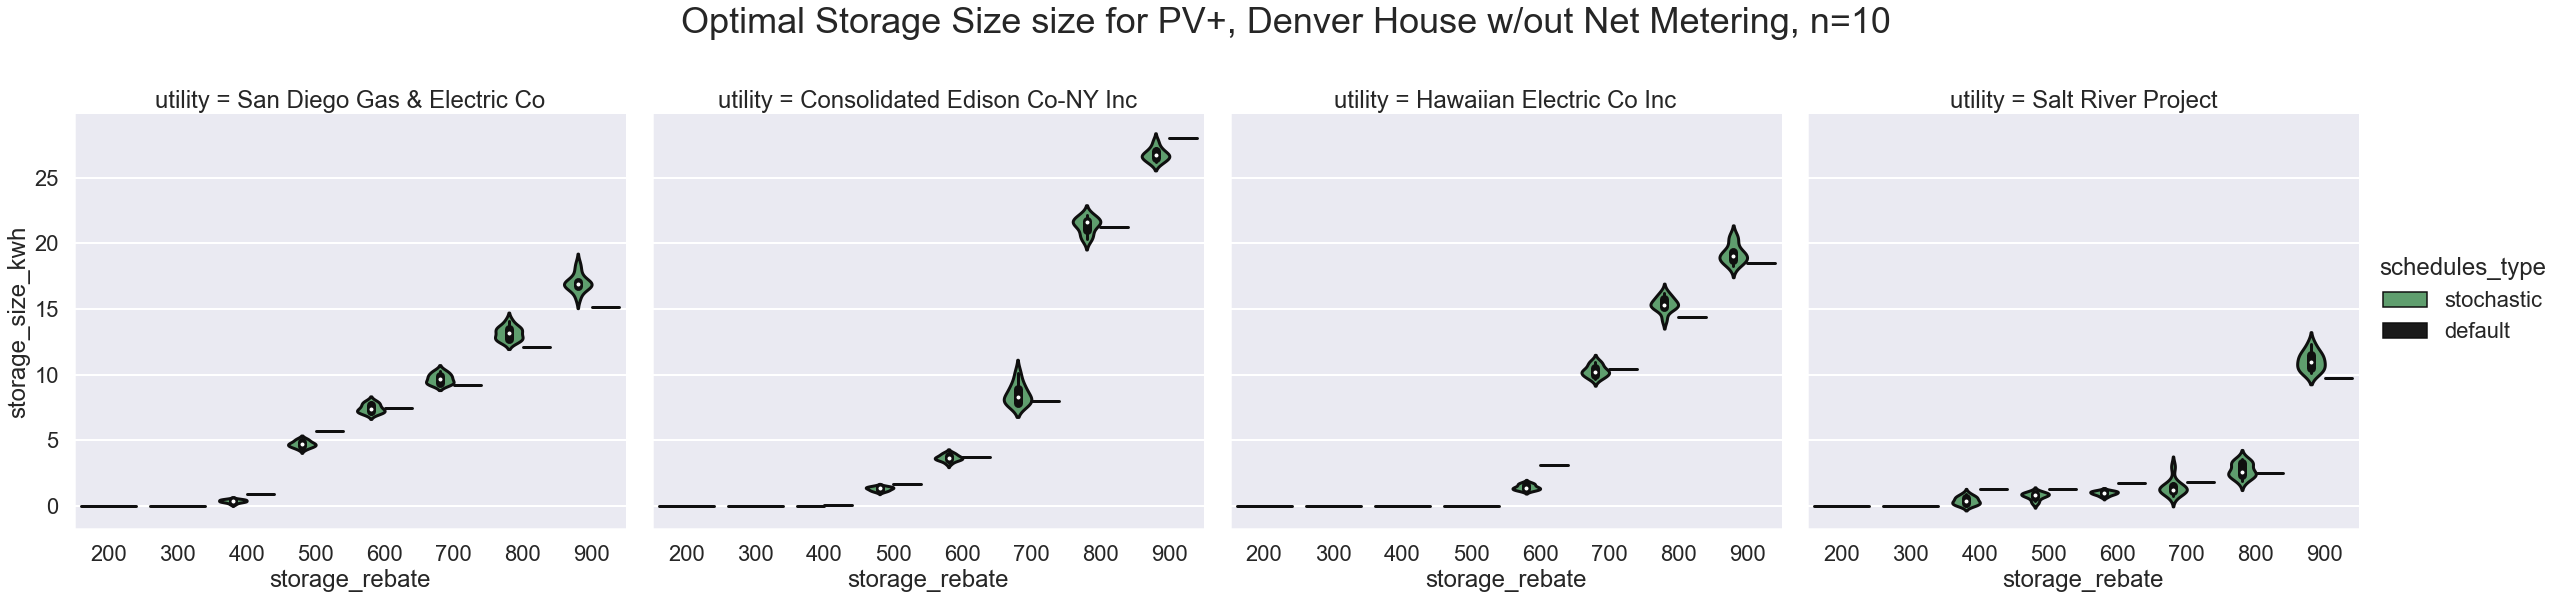

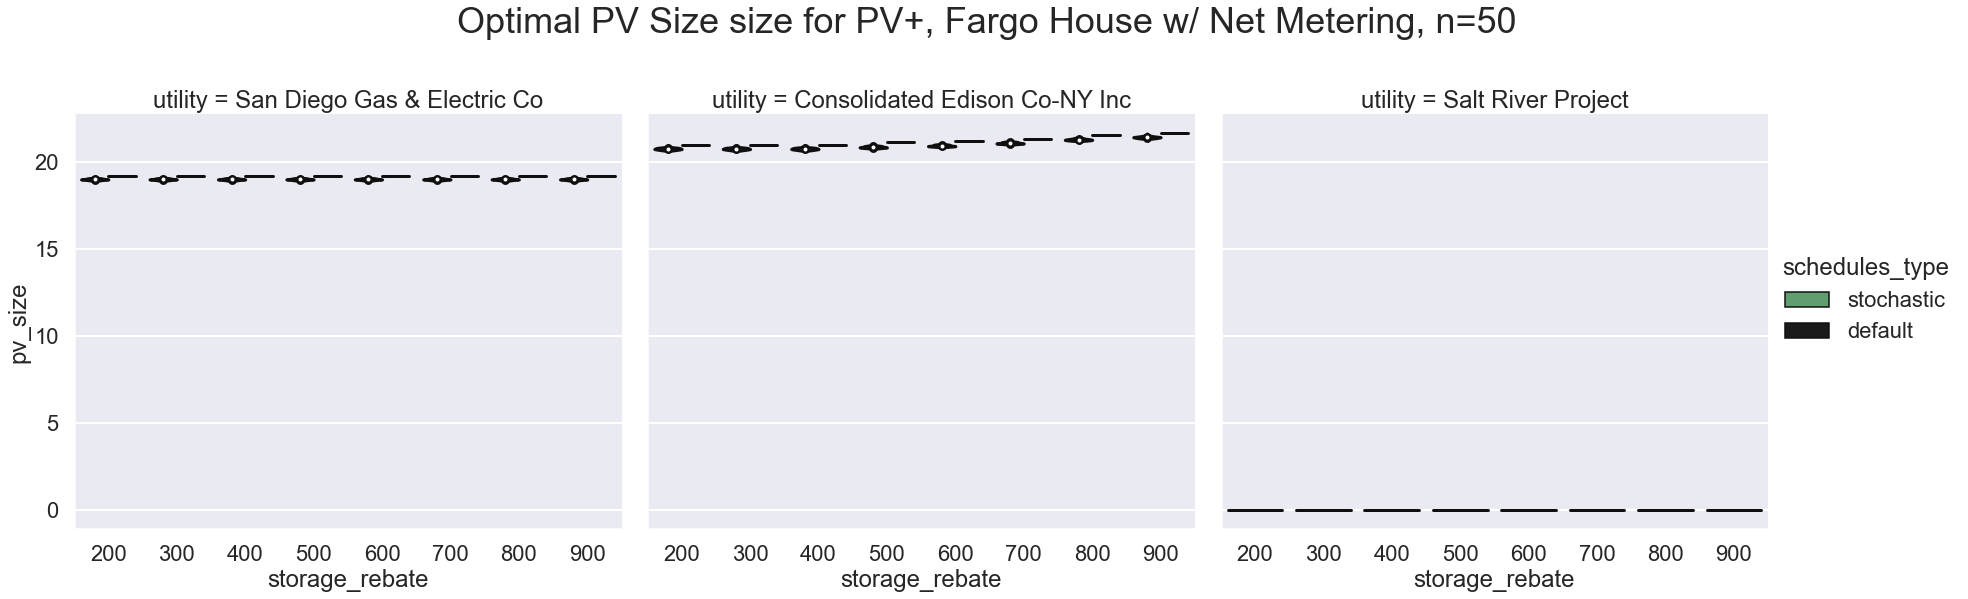

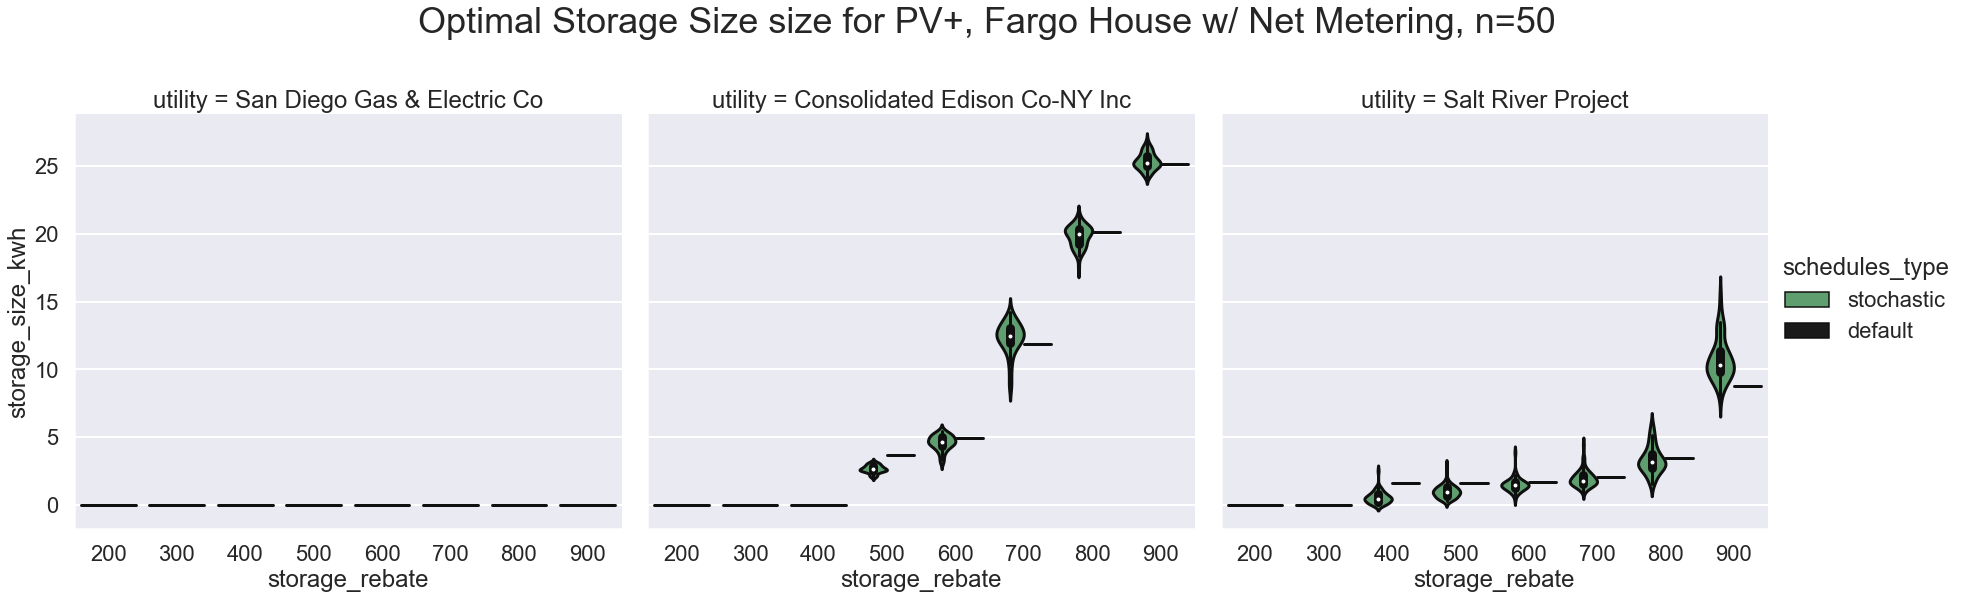

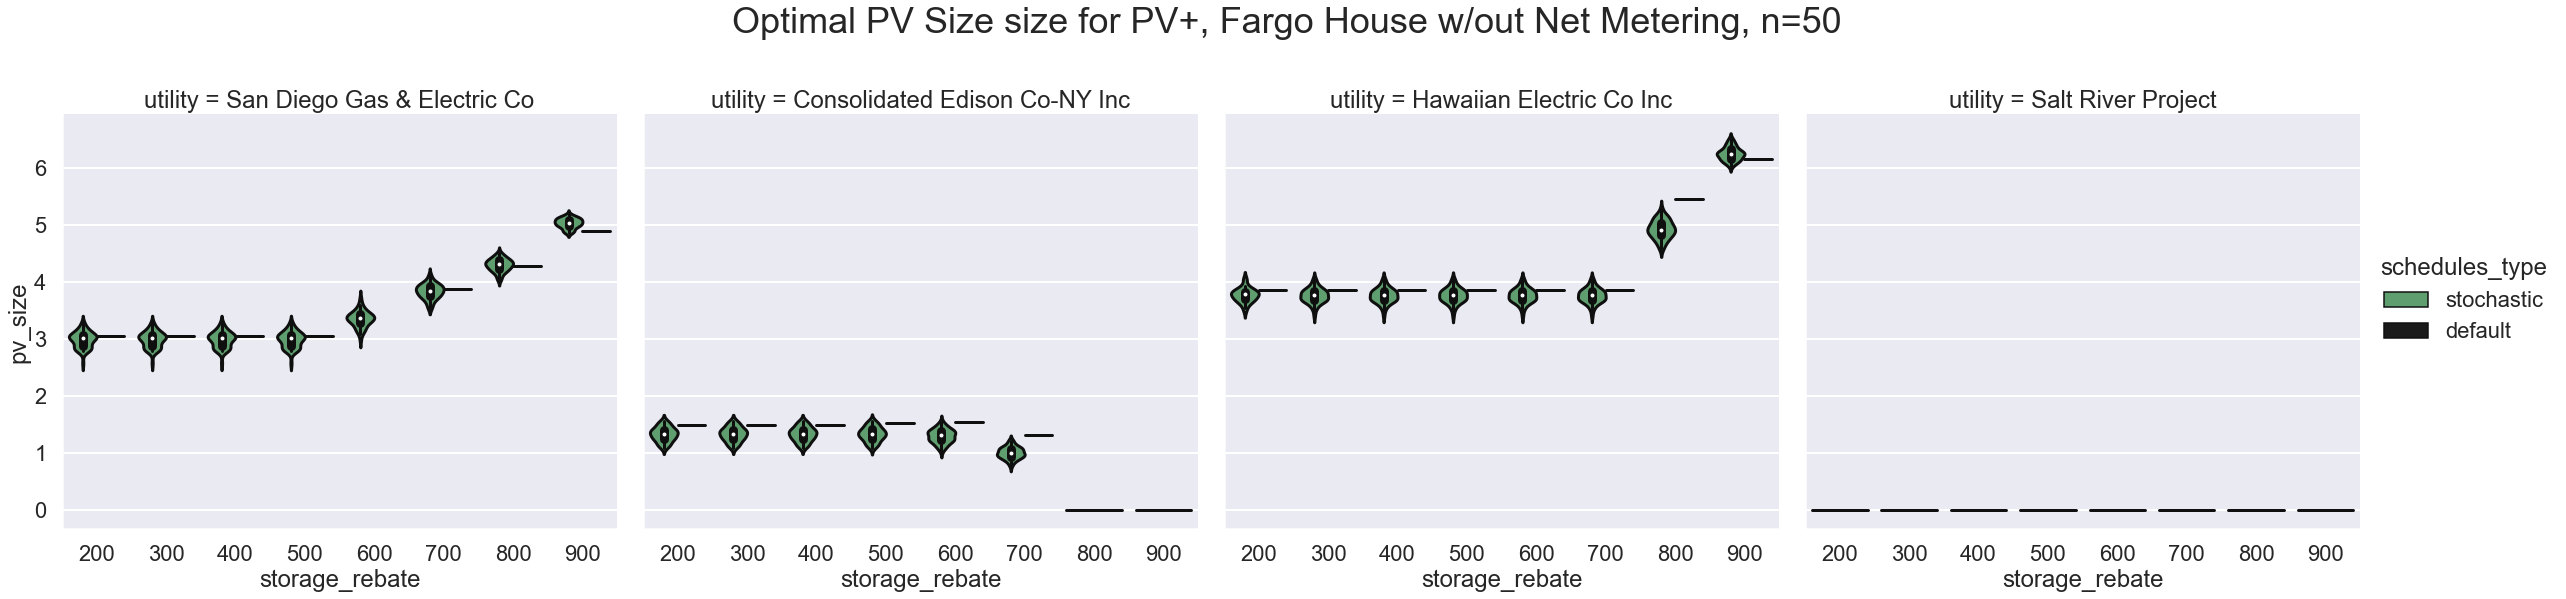

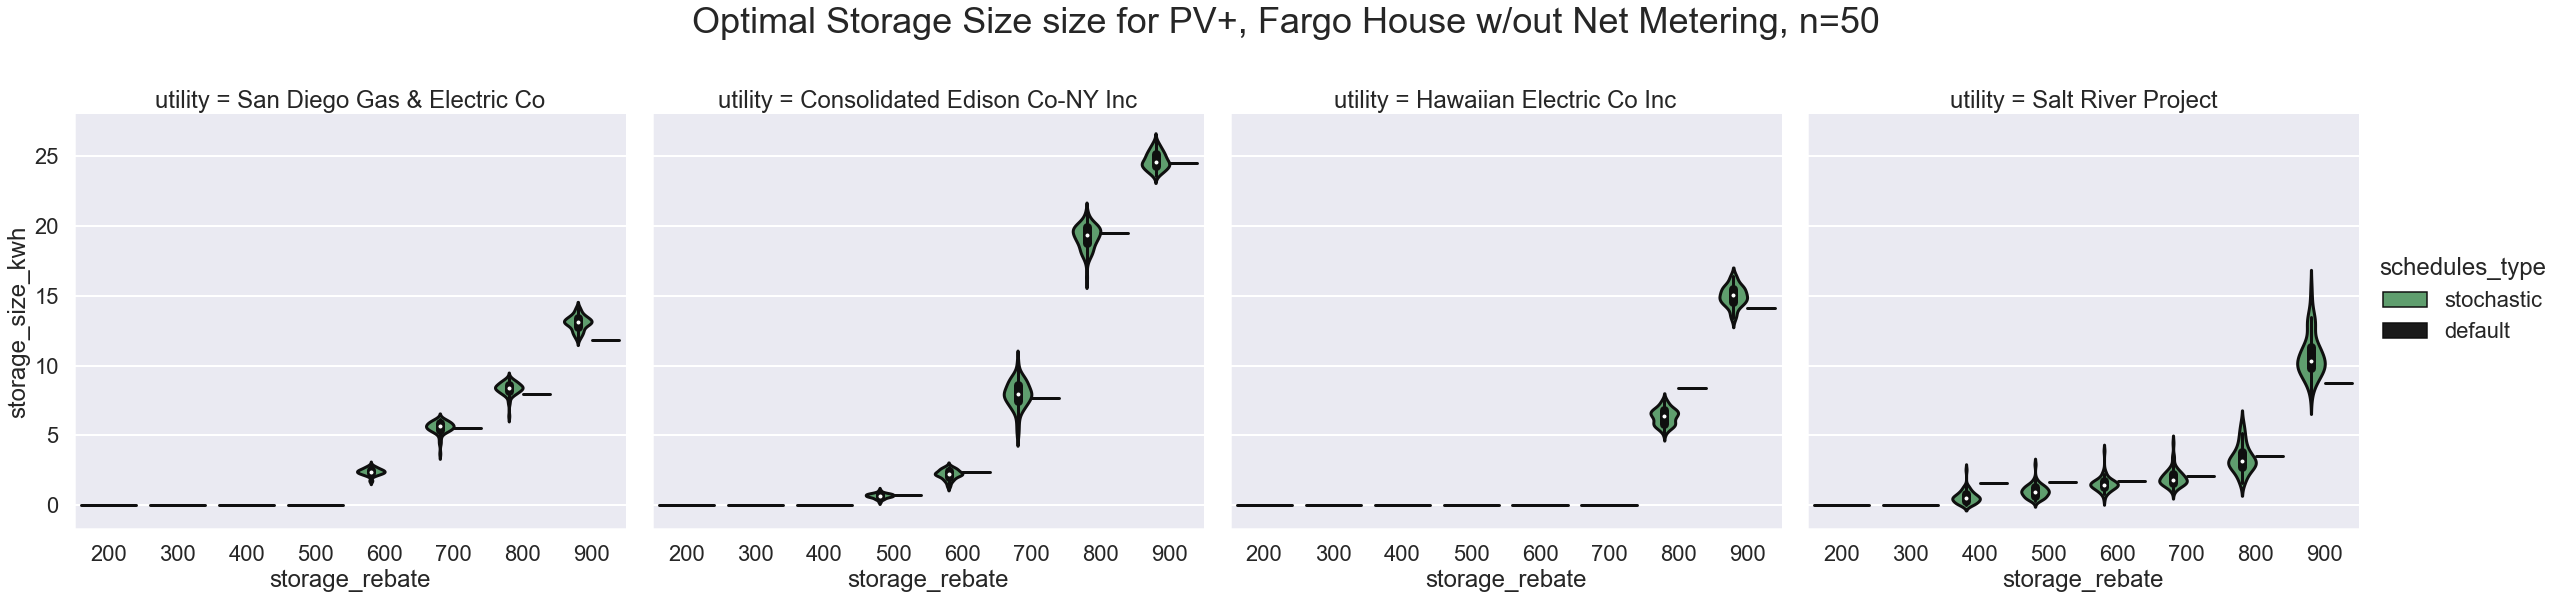

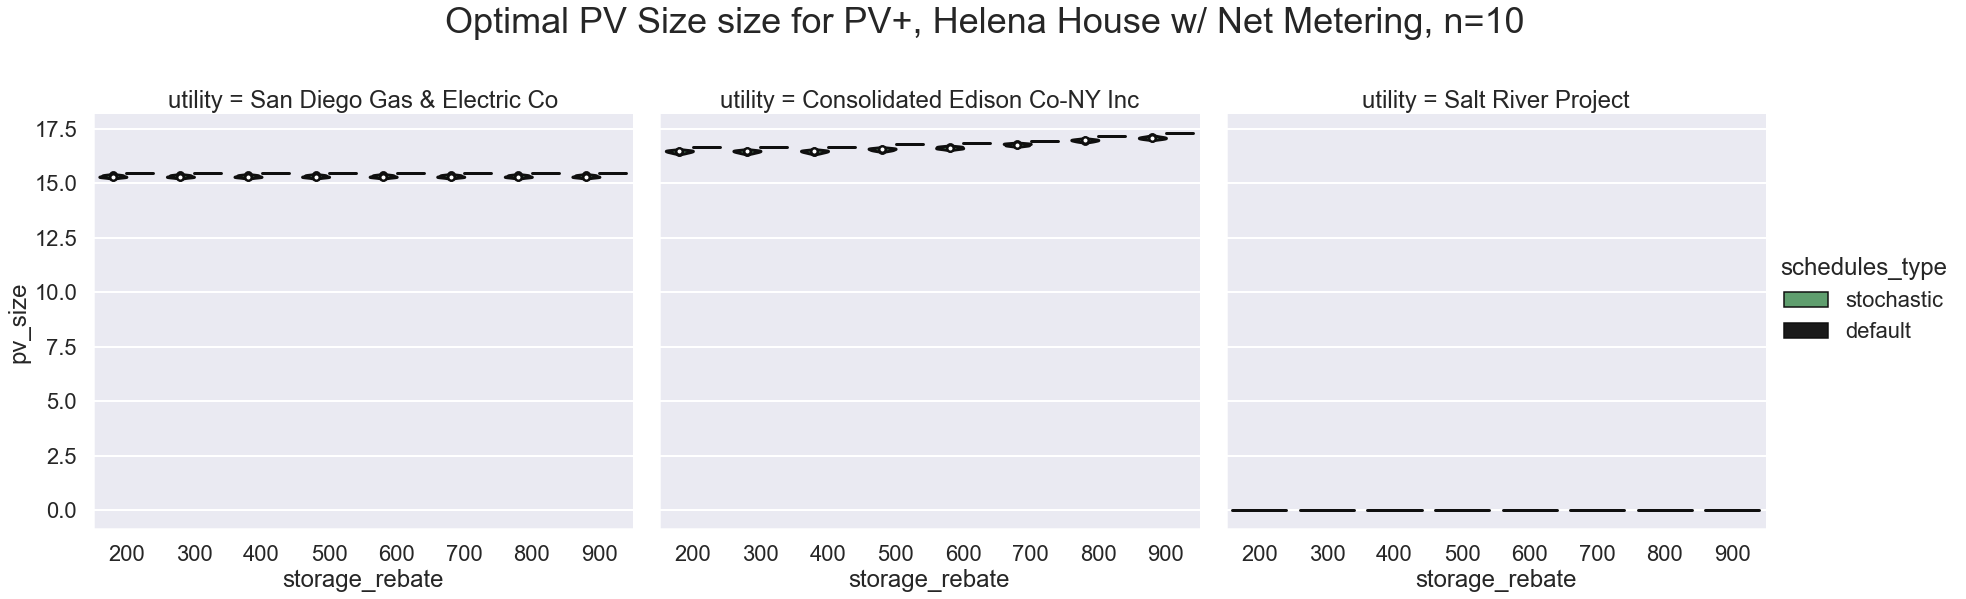

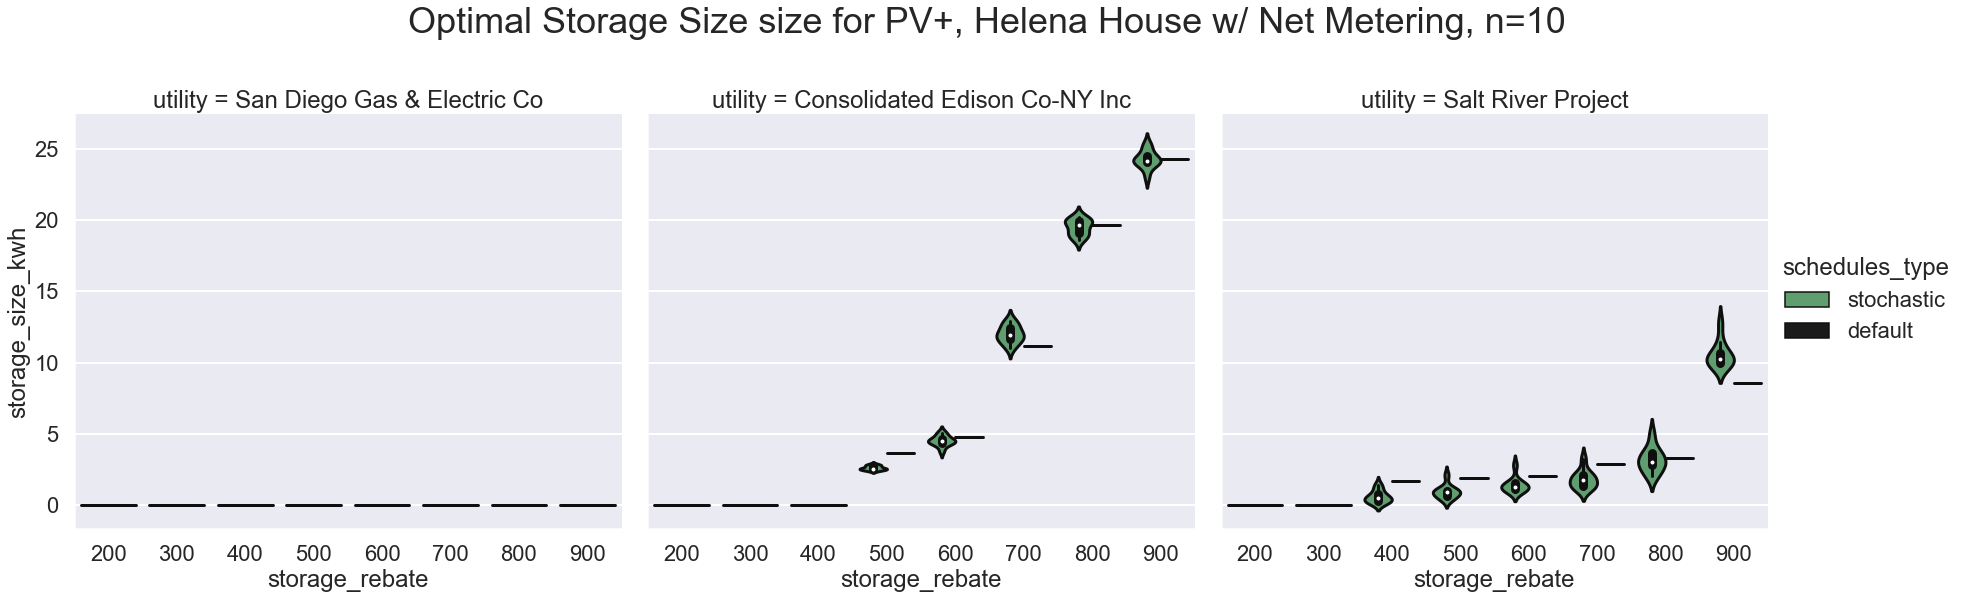

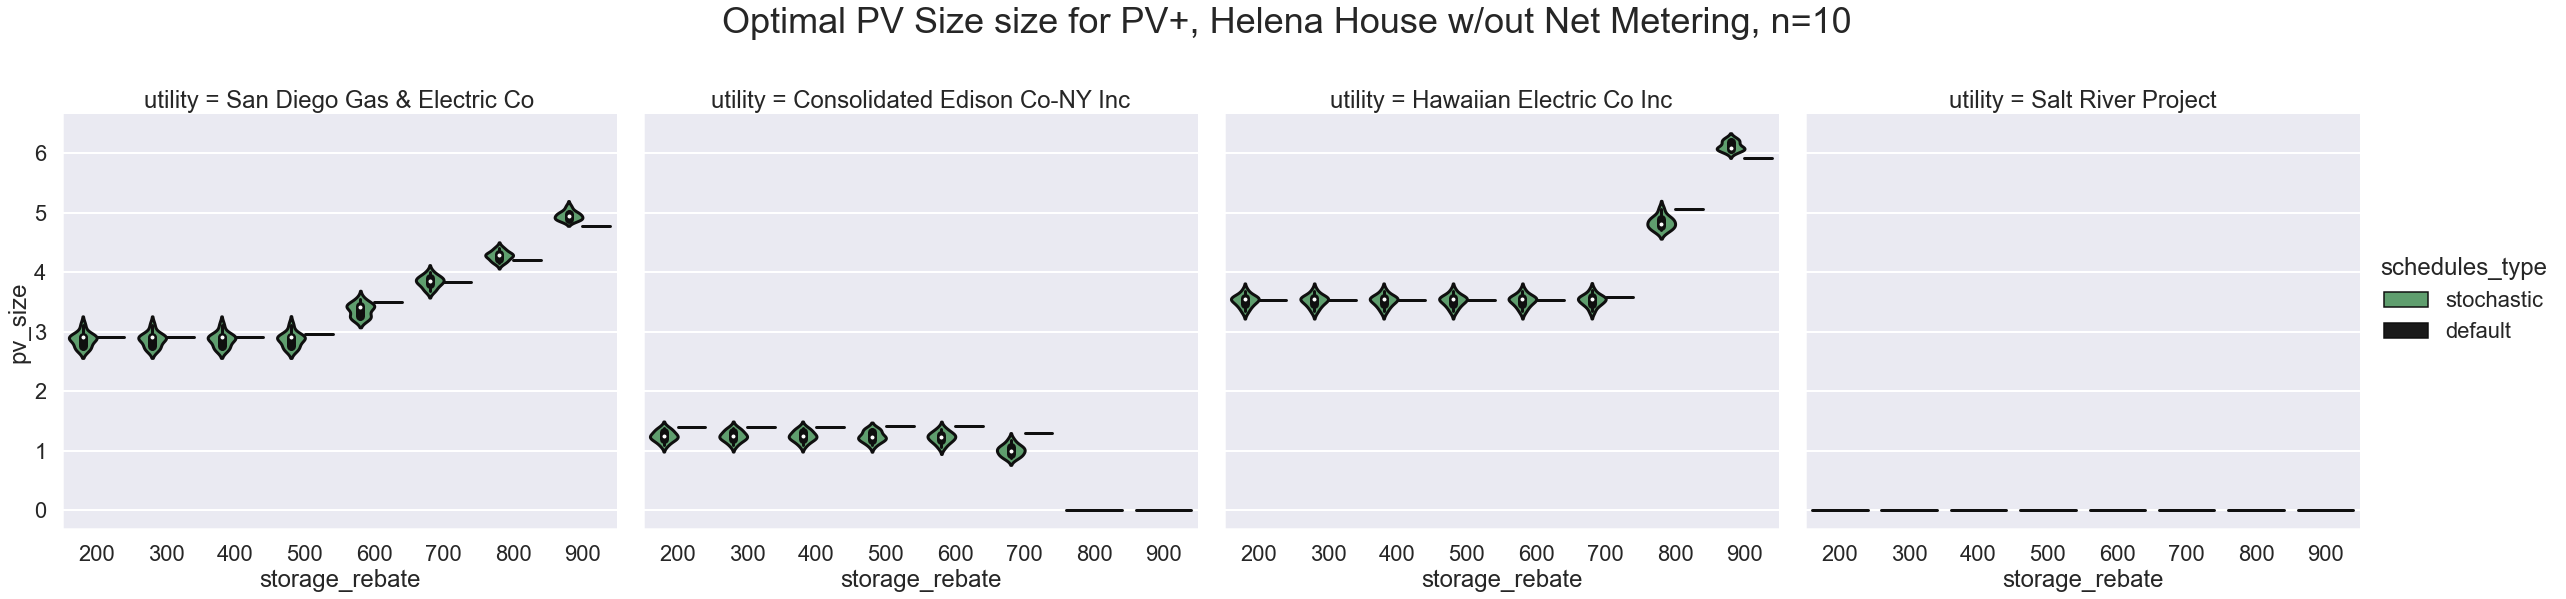

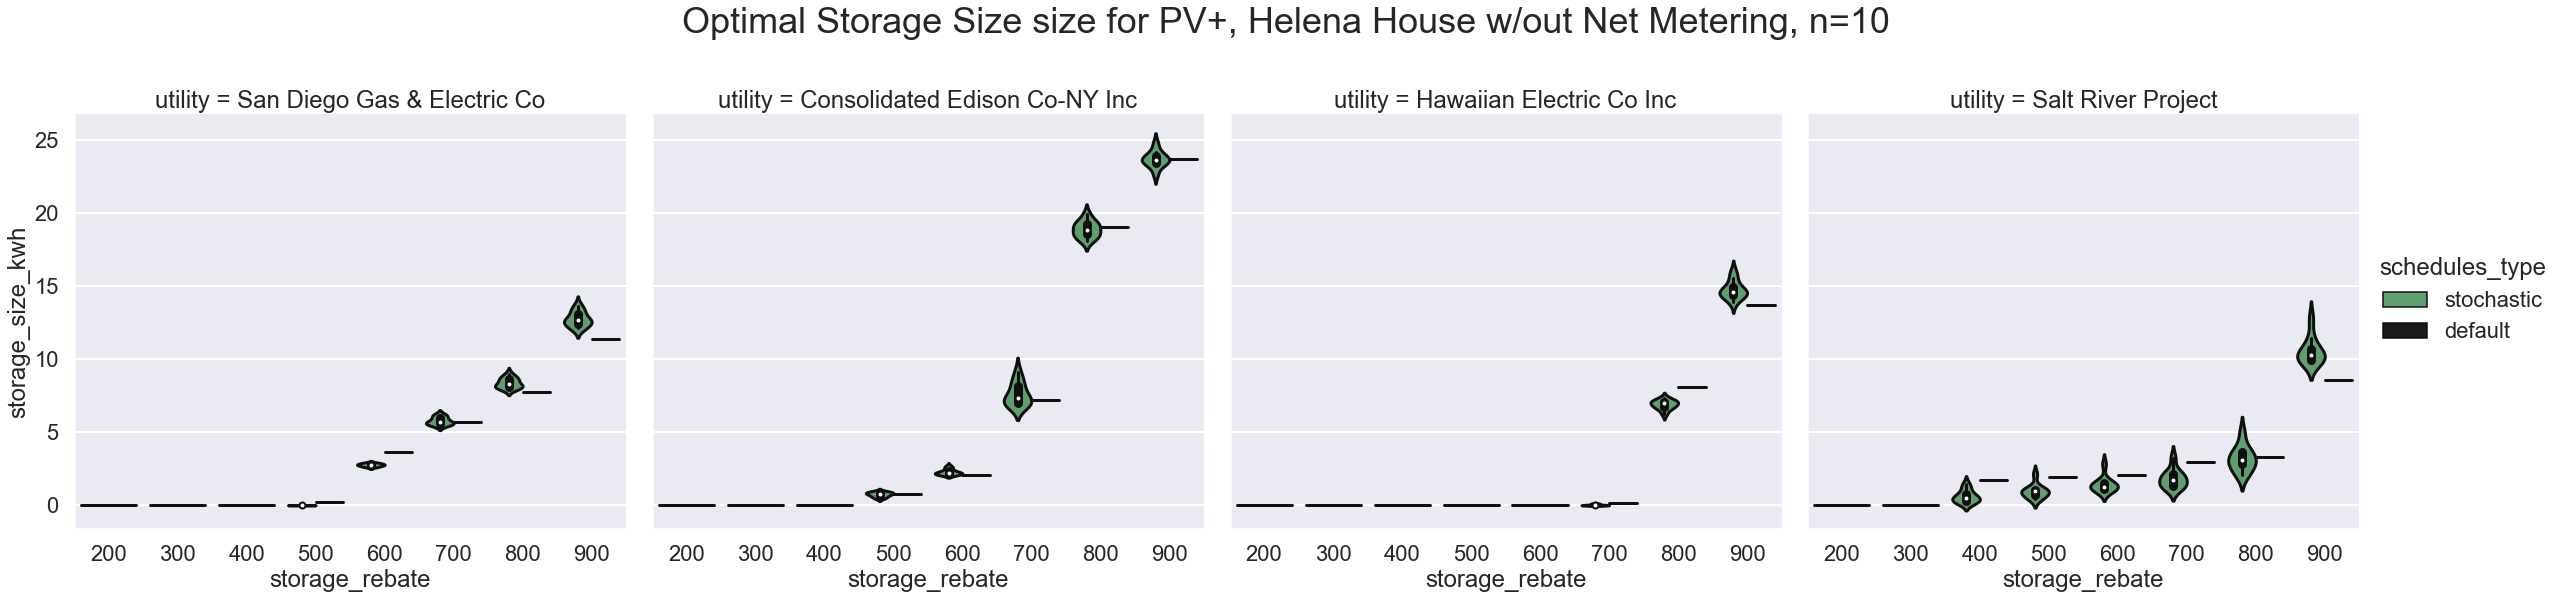

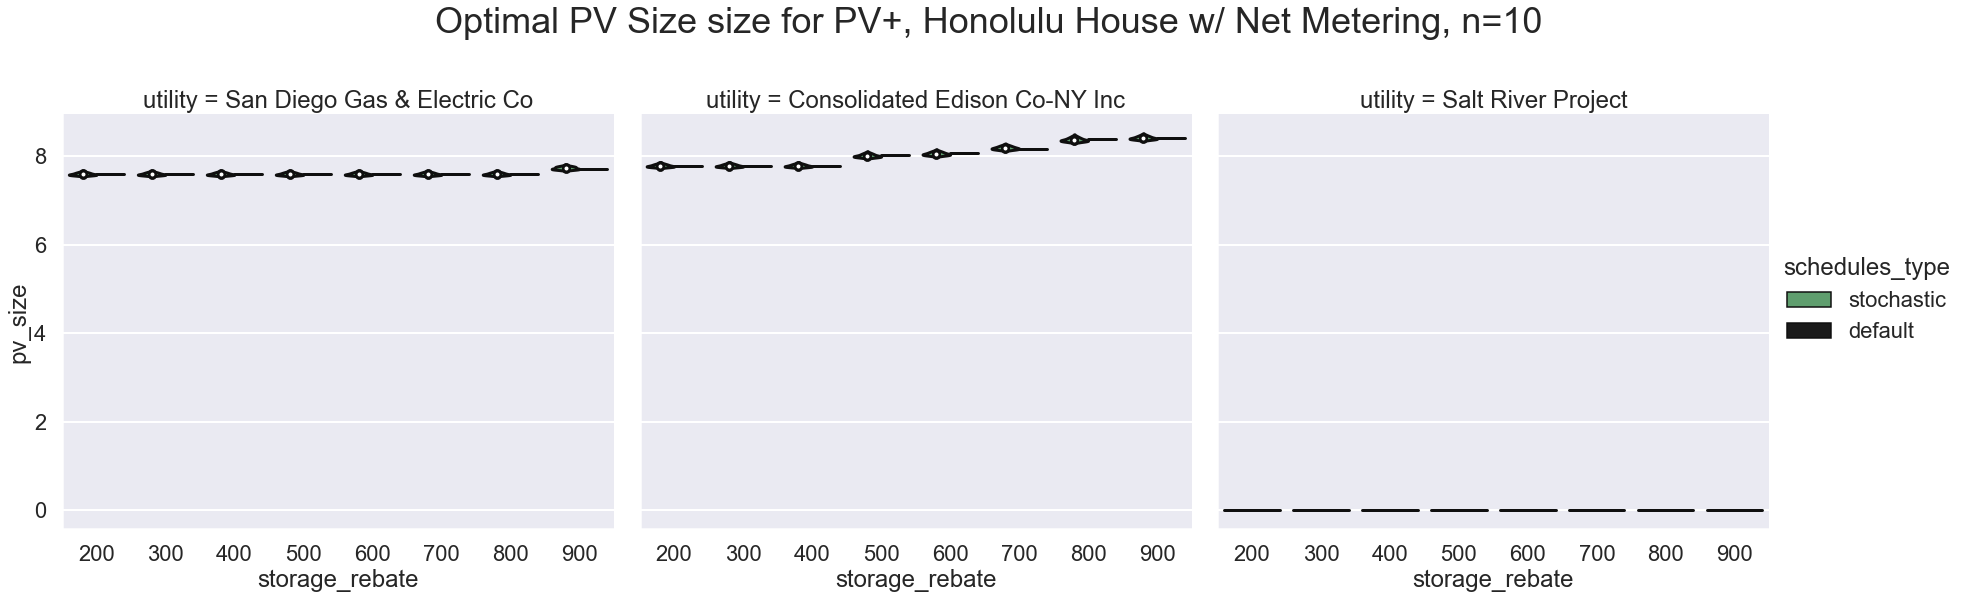

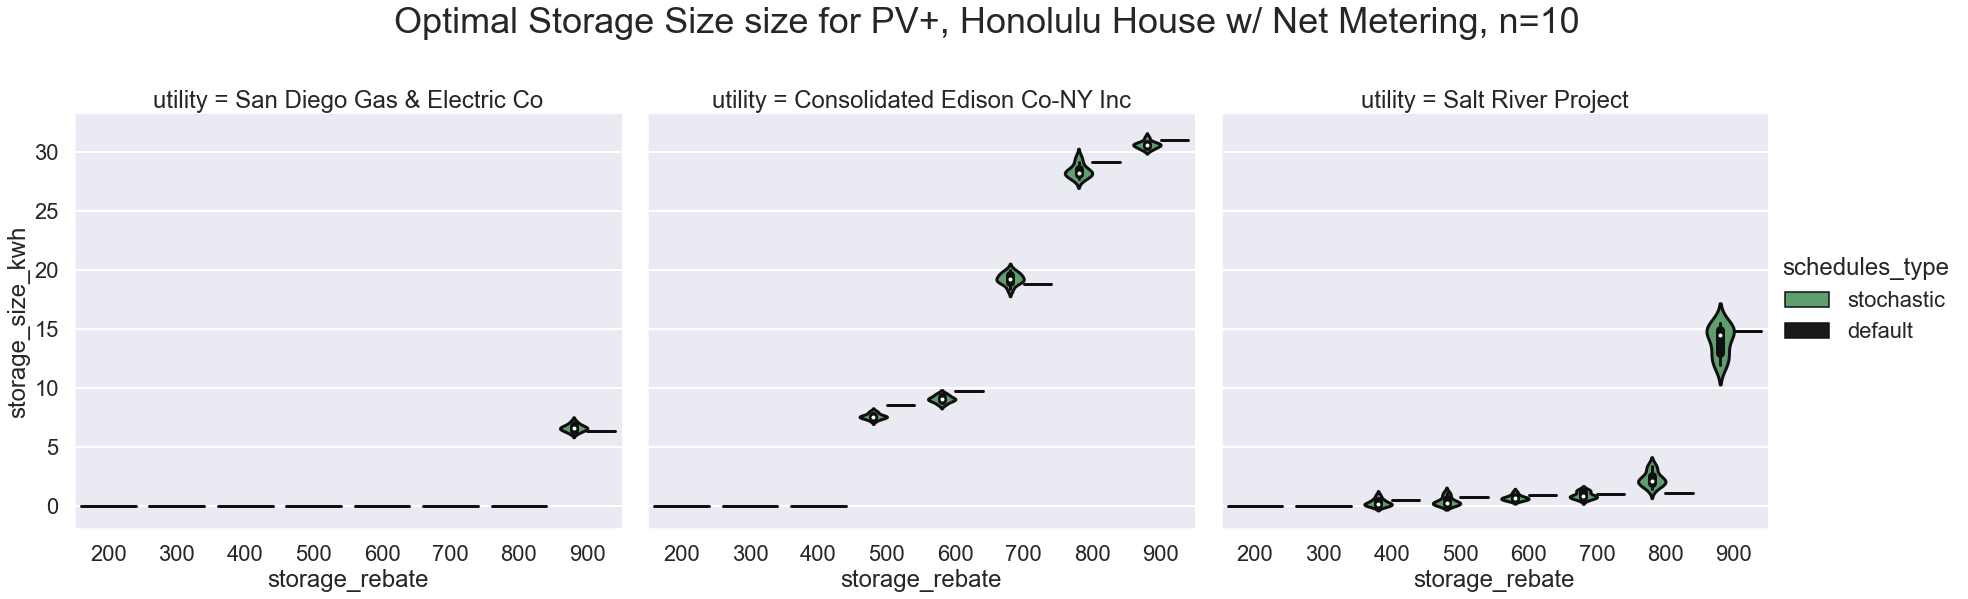

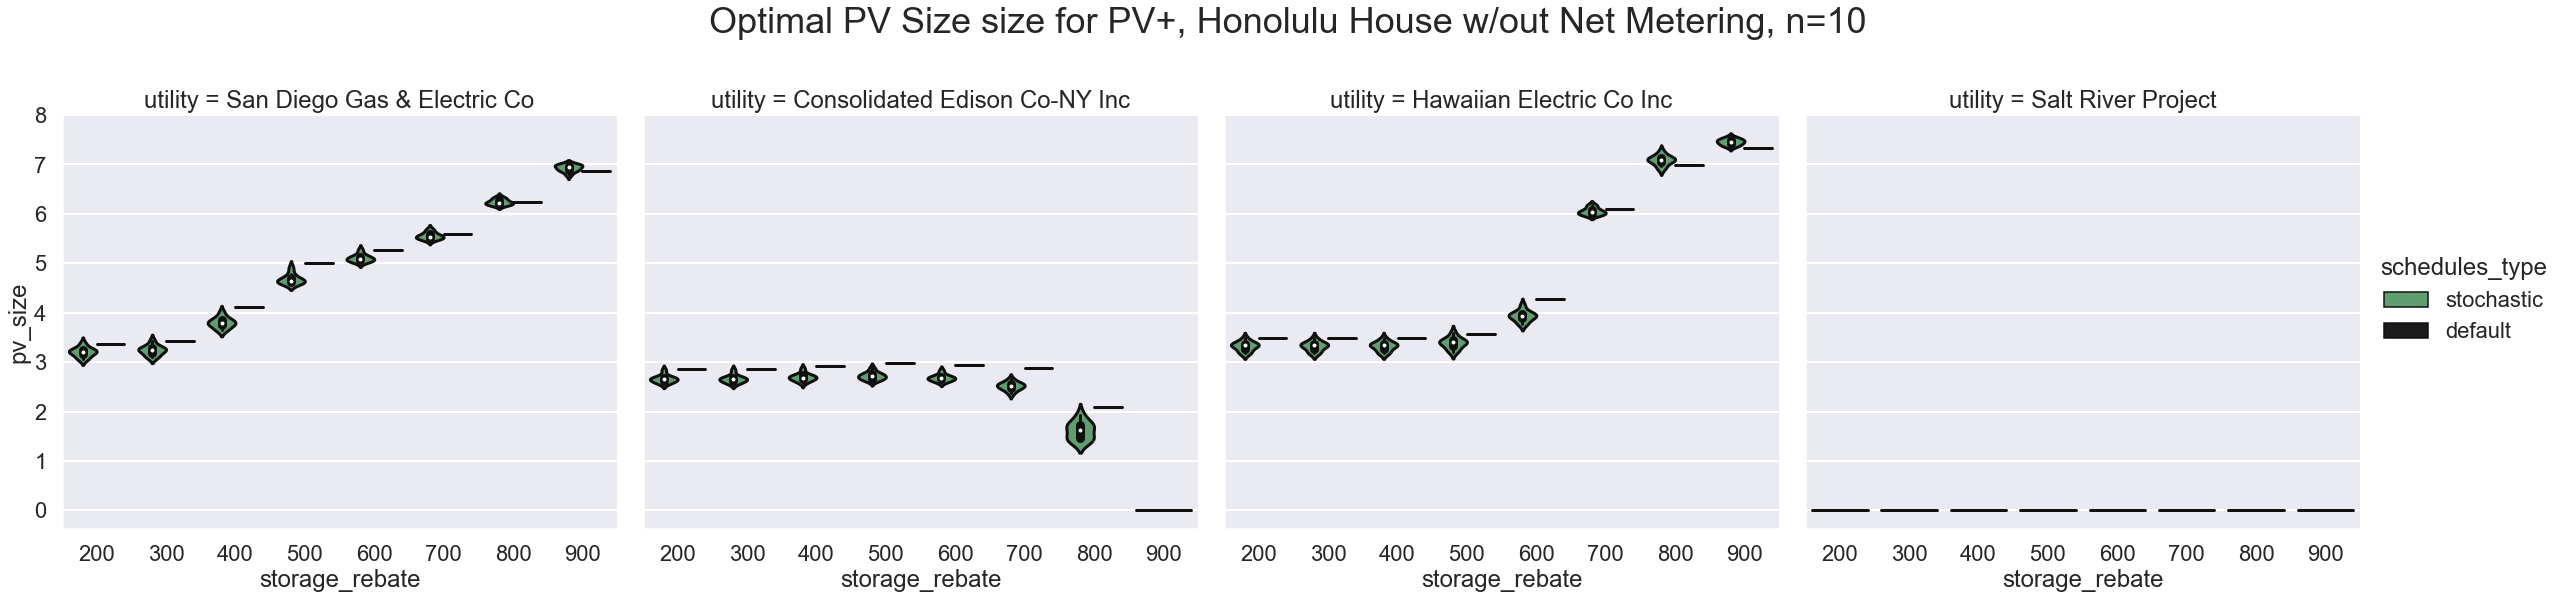

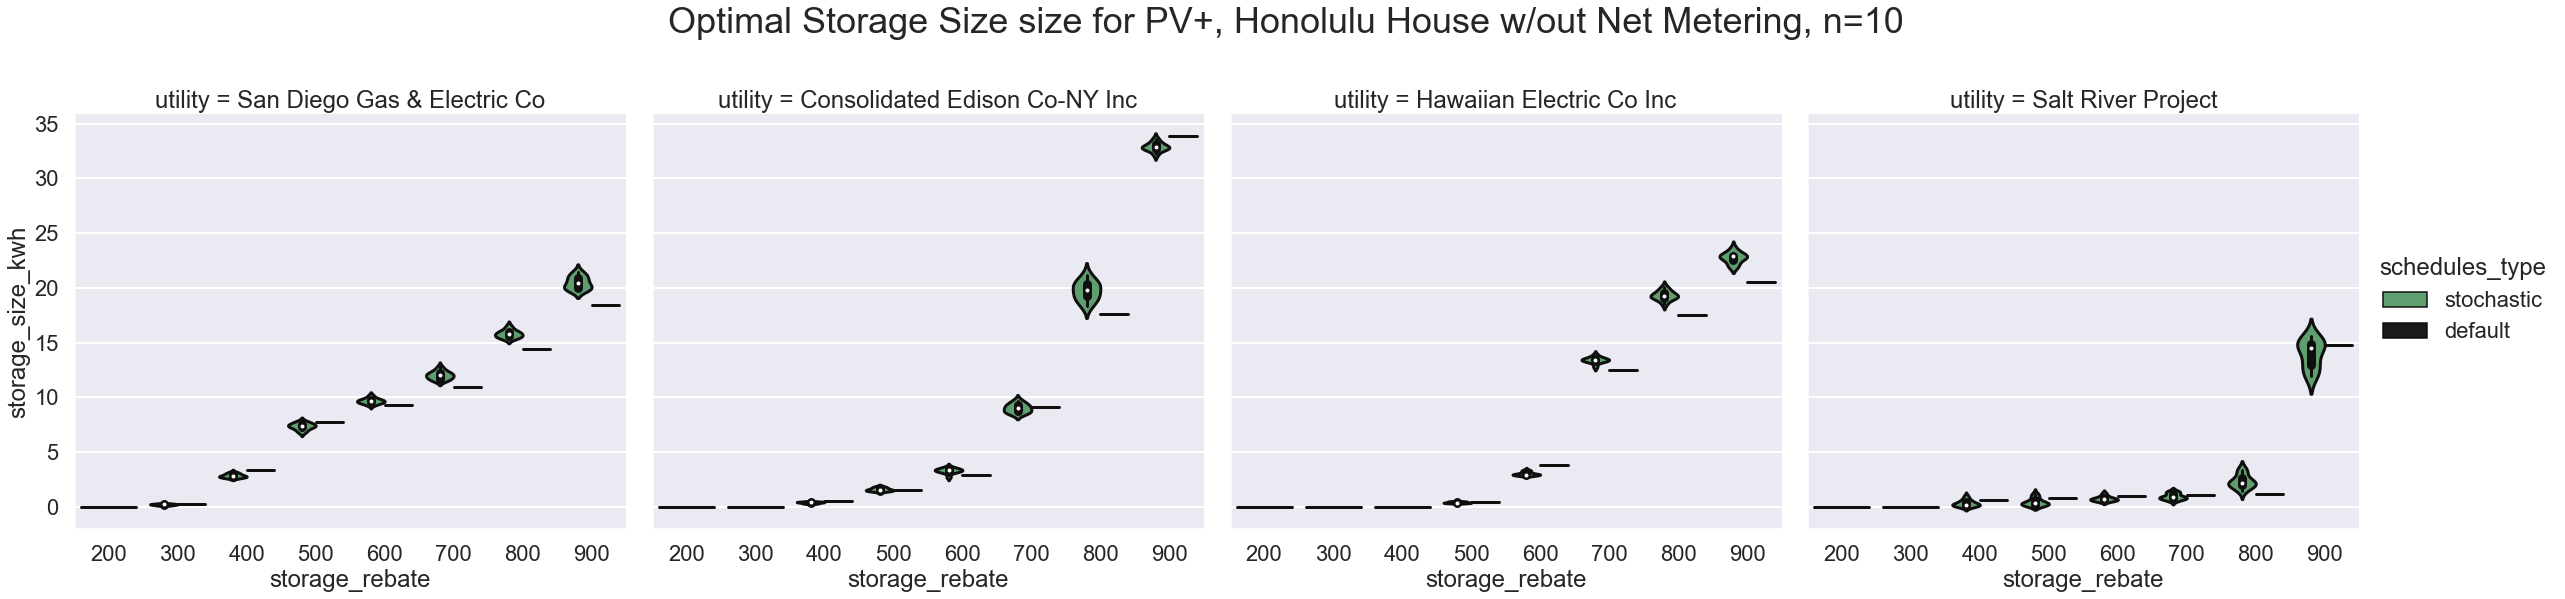

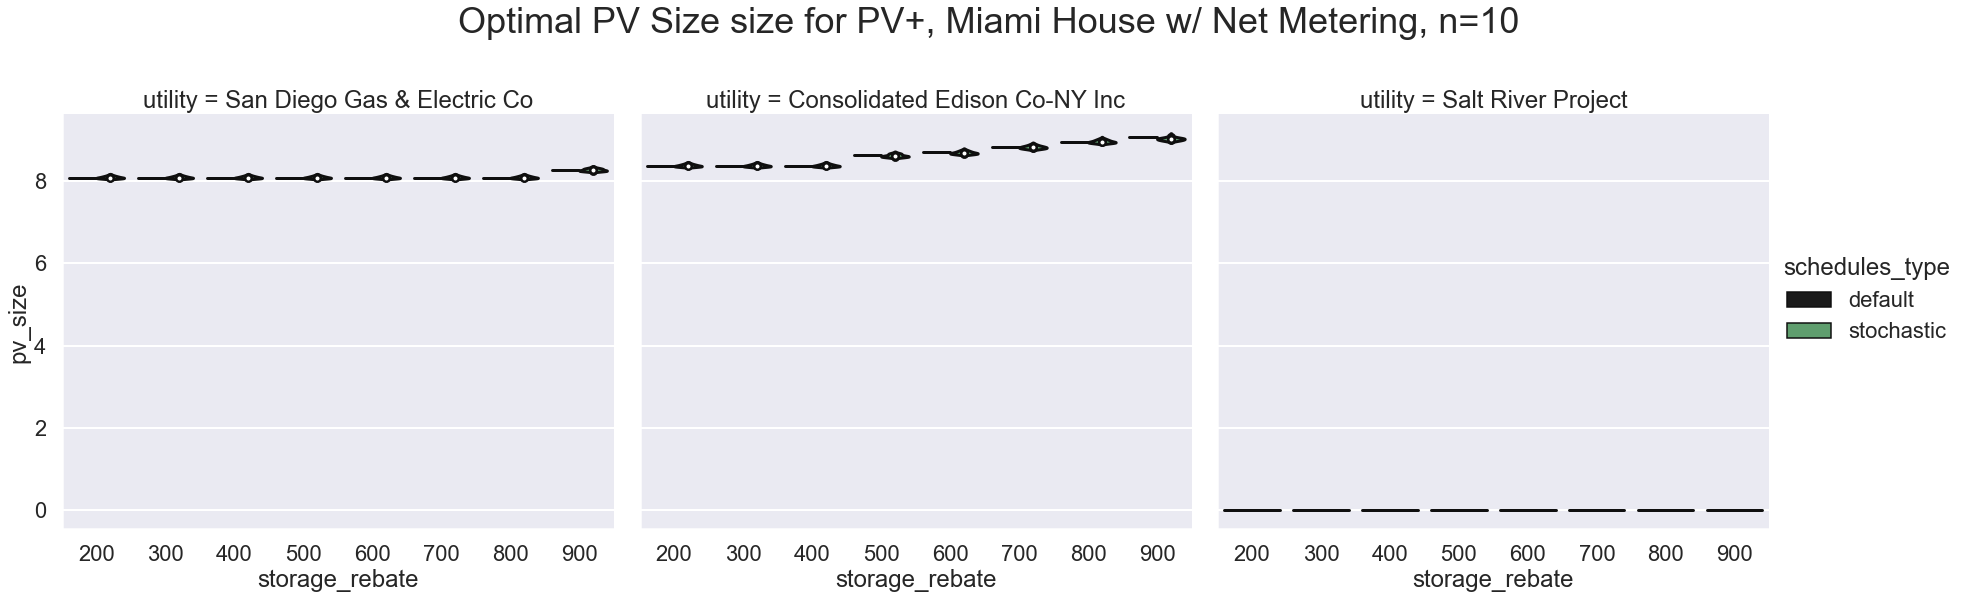

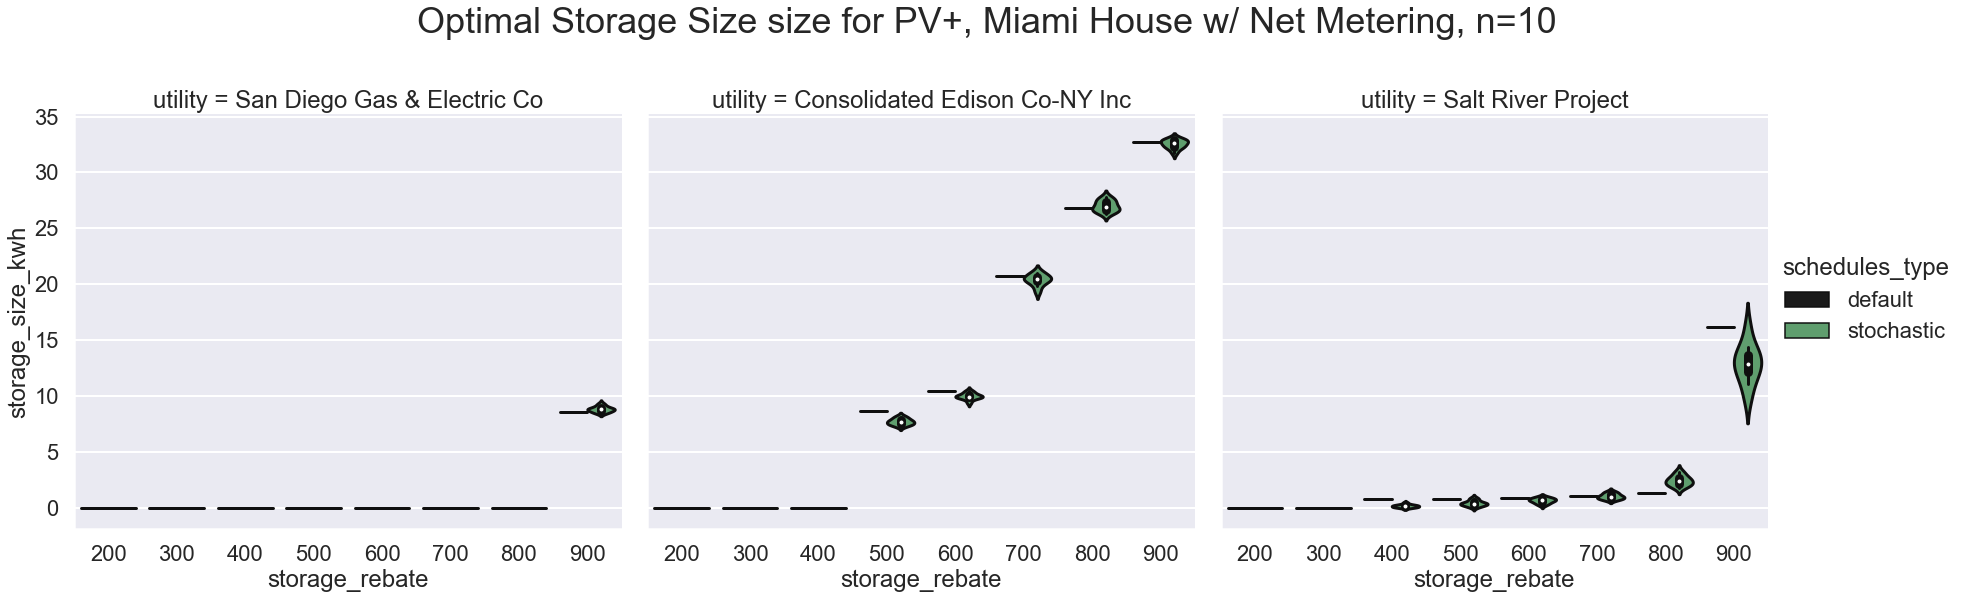

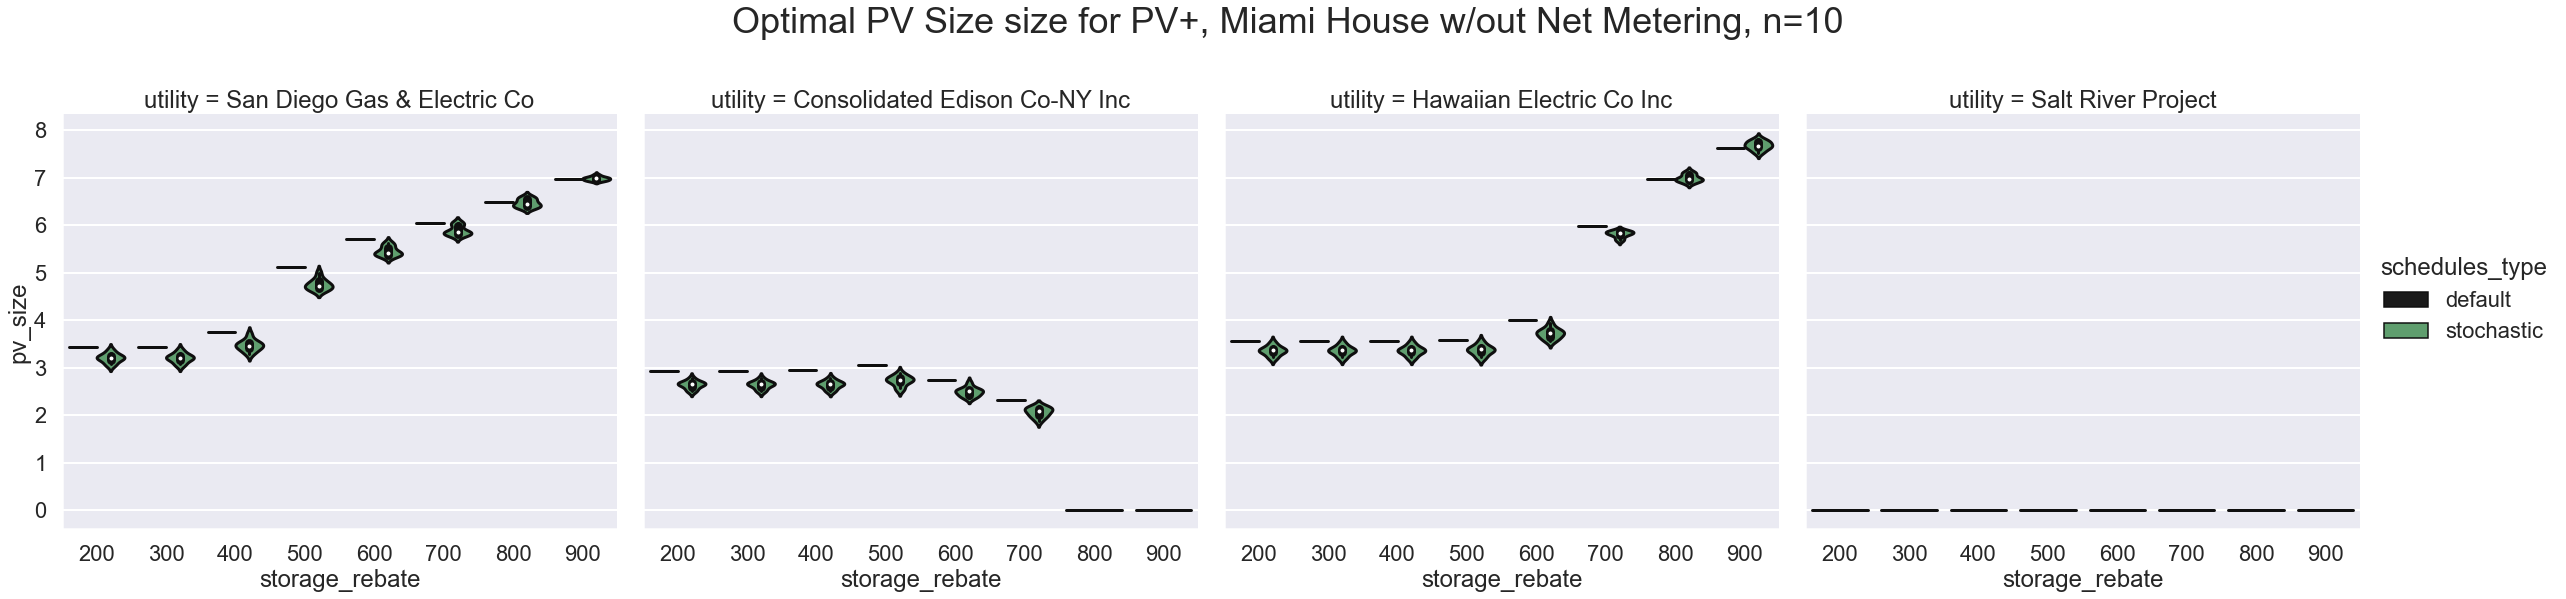

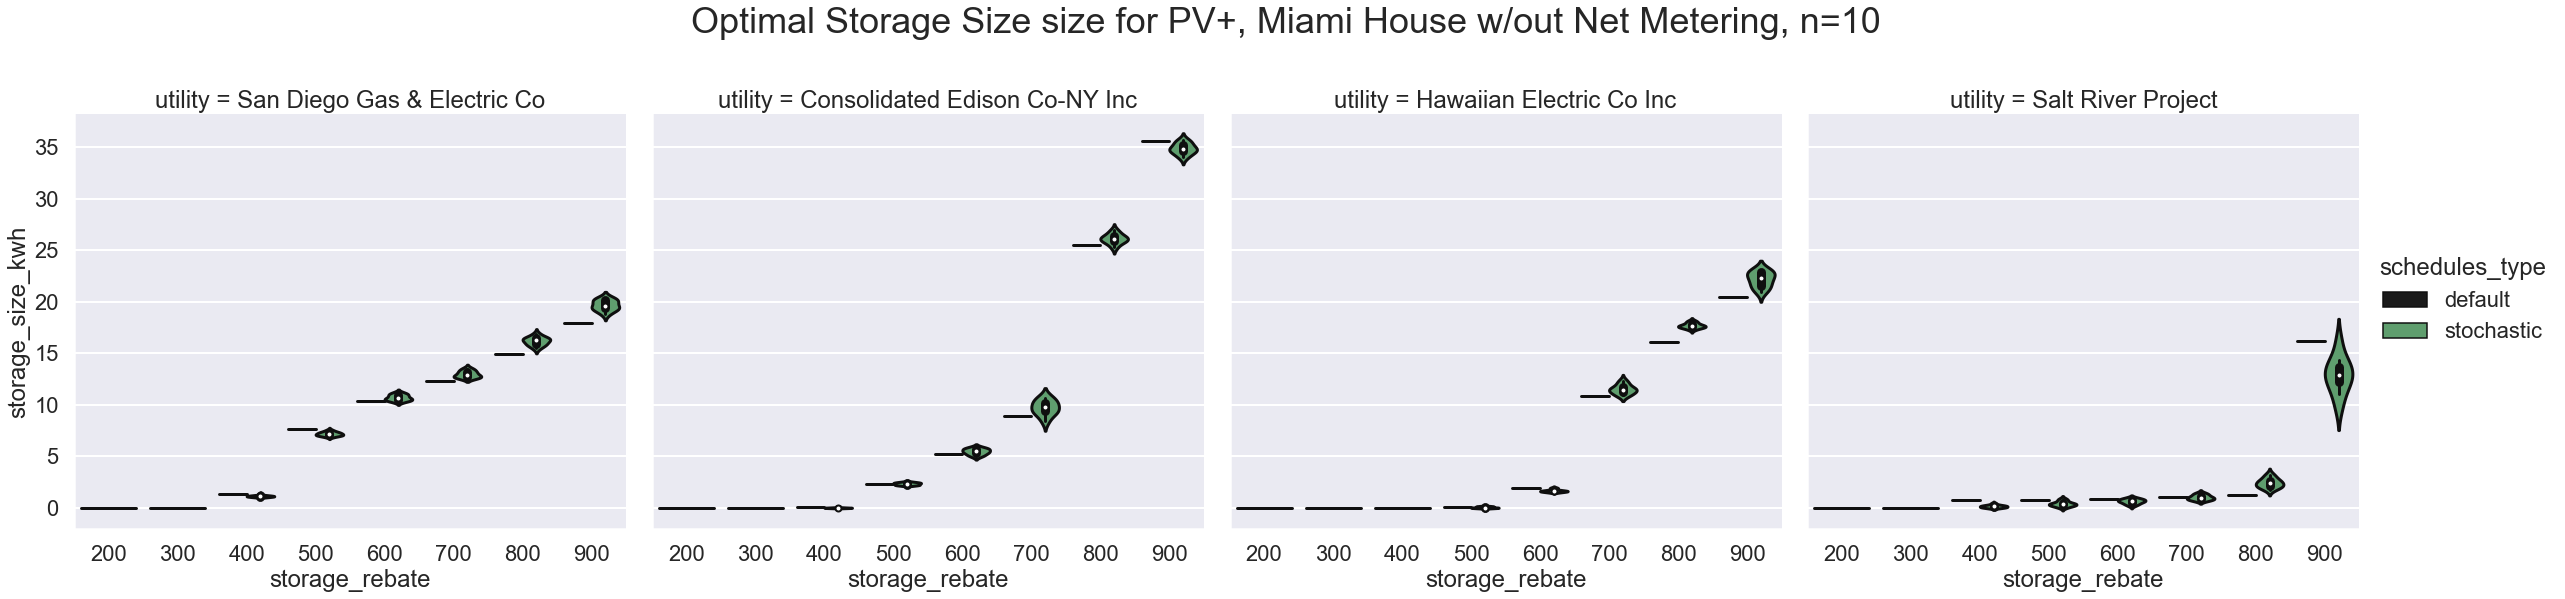

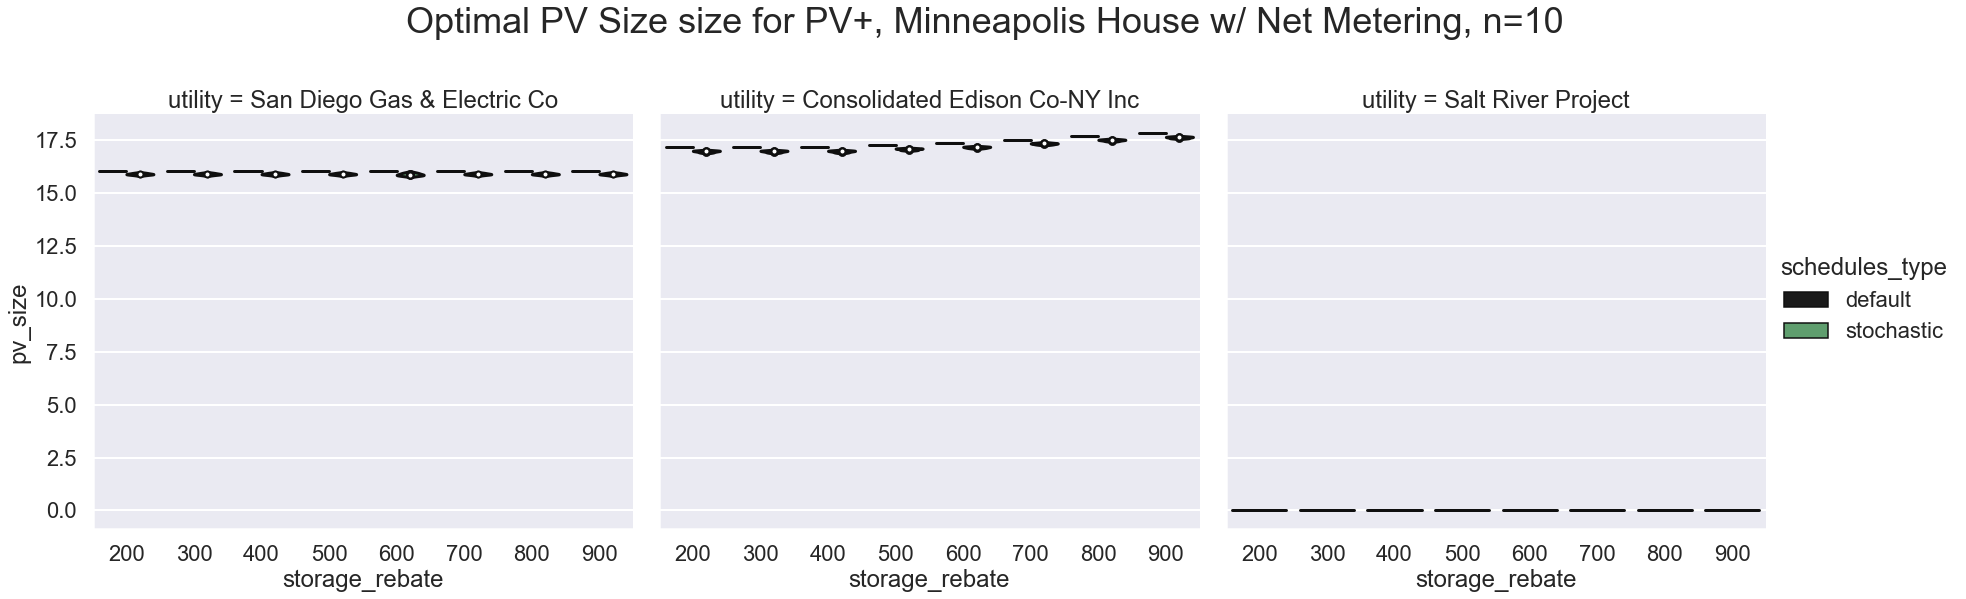

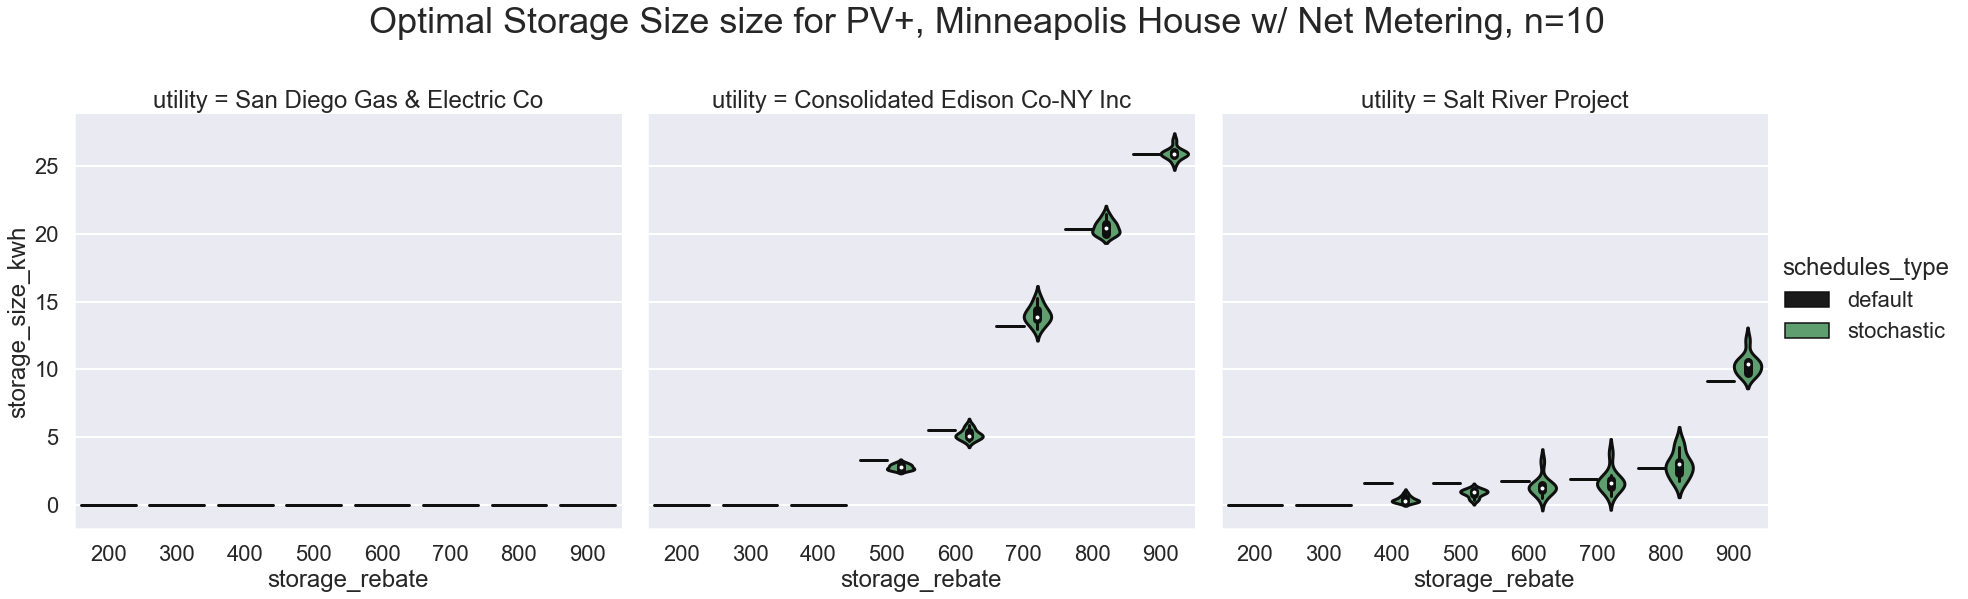

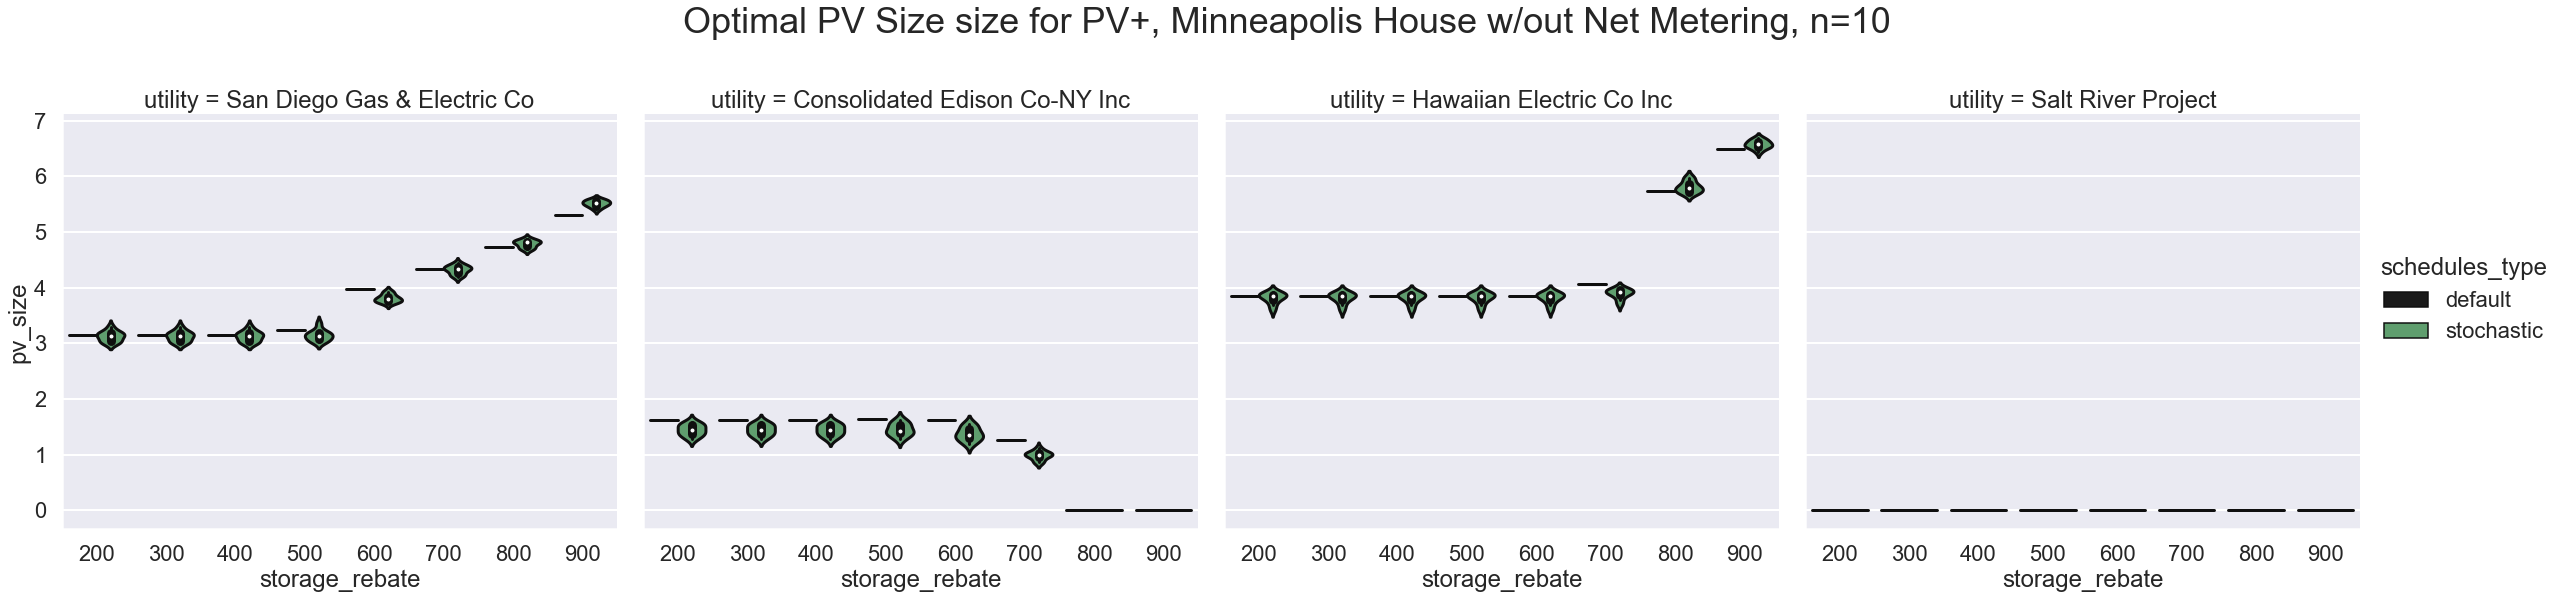

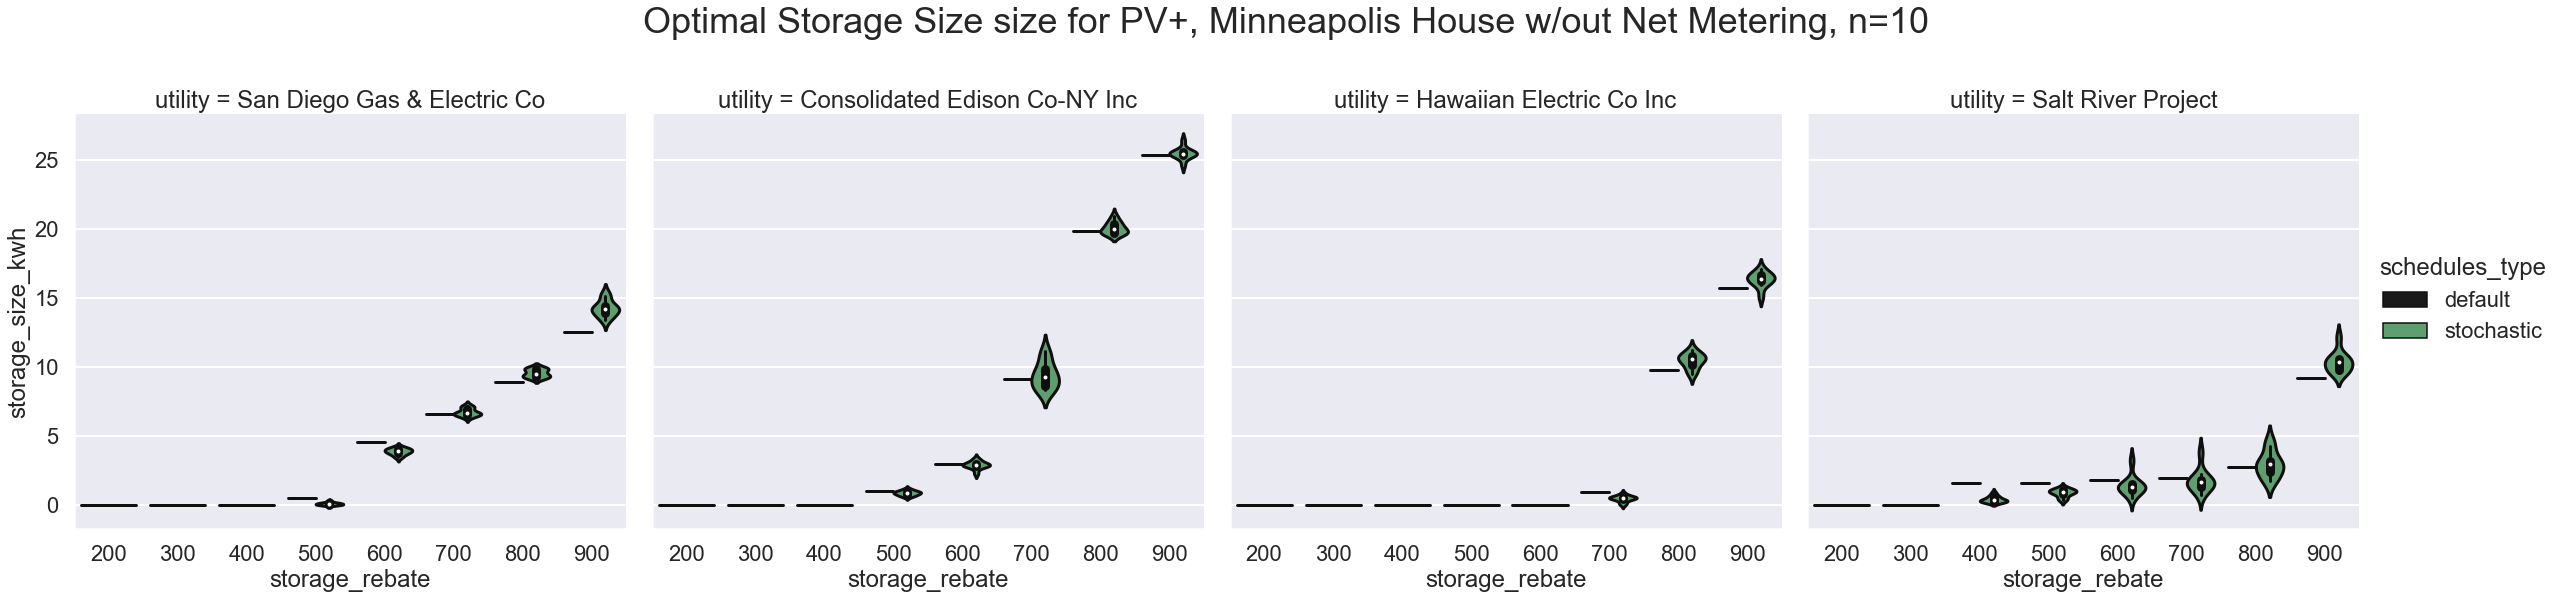

In [424]:
for location in LOCATIONS:
    location_lower = location.lower().replace(" ", "-")
    if location_lower == "san-diego":
        results.load(scenario_pattern="home-san-diego-3-bd-2301-sched-default-3086825032",
                     reopt_pattern=".*",)
        # Load the 10-run example.
        results.load(scenario_pattern="home-san-diego-3-bd-2301-sched-stochastic-9542565323",
                     reopt_pattern=".*")
    else:
        results.load(scenario_pattern=f"home-{location_lower}-.*")
    try:
        make_cat_plots(results.to_dataframe({"location": location}), location)
    except Exception:
        print(f"Error running {location}")
        print(e)

In [419]:
# Plot comparison of stochastic vs. default energy usage...
def energy_usage_catplot(results):
    df = results.to_dataframe({
        "utility": "San Diego Gas & Electric Co"
    })
    ax = sns.catplot(x="location", y="load_annual_kwh",
                     hue="schedules_type",data=df,
                     kind="violin", height=8.27,
                     palette={"stochastic": "g", "default": "k"},
                     aspect=2)
    ax.fig.subplots_adjust(top=0.8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax


# Plot variance in kWh
def energy_usage_stochastic_variance_catplot(results):
    df = results.to_dataframe(
        {
            "utility": "San Diego Gas & Electric Co",
            "num_simulations": 10
        })
    # zero center the data
    deviations = []
    for location in df['location'].unique():
        location_data = df.loc[df['location'] == location]
        mean = location_data['load_annual_kwh'].mean()
        location_data['deviation'] = location_data['load_annual_kwh'] - mean
        deviations.append(location_data)
    all_locs = pd.concat(deviations)
    plt.figure(figsize=(12, 7))
    ax = sns.boxplot(x='location', y='deviation',
                     data=all_locs,
                     whis=2000)
    sns.swarmplot(x='location', y='deviation',
                  data=all_locs,
                  ax=ax, color='.2')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
    ax.set_ylabel("Deviation from mean (kWh)")
    return ax
    

<ipython-input-419-f97ee8562357>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['deviation'] = location_data['load_annual_kwh'] - mean


Text(0.5, 1.0, 'Variance of yearly energy usage, stochastic schedules with n=10')

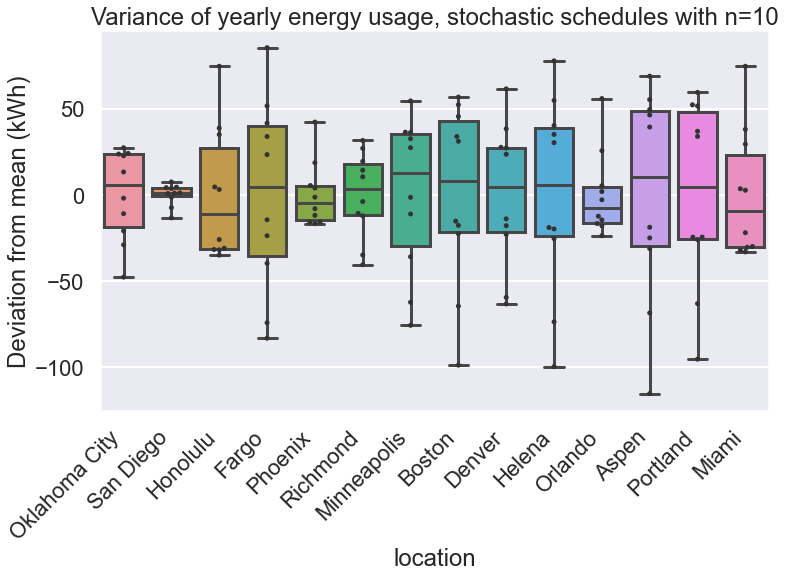

In [421]:
# Plot difference in energy predictions across sites
results.load(reopt_pattern=".*5cafb9ce5457a39d457780e6-net-metering-true-rebate-500.*")
# Plot the variance in household energy usage
# energy_usage_catplot(results)
# plt.gca().set_title("Comparison of annual kWh between default and stochastic schedules")

energy_usage_stochastic_variance_catplot(results)
plt.title("Variance of yearly energy usage, stochastic schedules with n=10")

ExteriorLights:Electricity(kWh) is the same.
Pumps:Electricity(kWh) is the same.
extra_refrigerator_sched is the same.
freezer_sched is the same.
fuel_loads_fireplace_sched is the same.
fuel_loads_grill_sched is the same.
fuel_loads_lighting_sched is the same.
hot_tub_heater_sched is the same.
hot_tub_pump_sched is the same.
lighting_exterior_holiday_sched is the same.
lighting_exterior_sched is the same.
lighting_garage_sched is the same.
plug_loads_tv_sched is the same.
plug_loads_vehicle_sched is the same.
plug_loads_well_pump_sched is the same.
pool_heater_sched is the same.
pool_pump_sched is the same.
refrigerator_sched is the same.
vacancy_sched is the same.


Text(0.5, 0.98, 'End usage, San Diego')

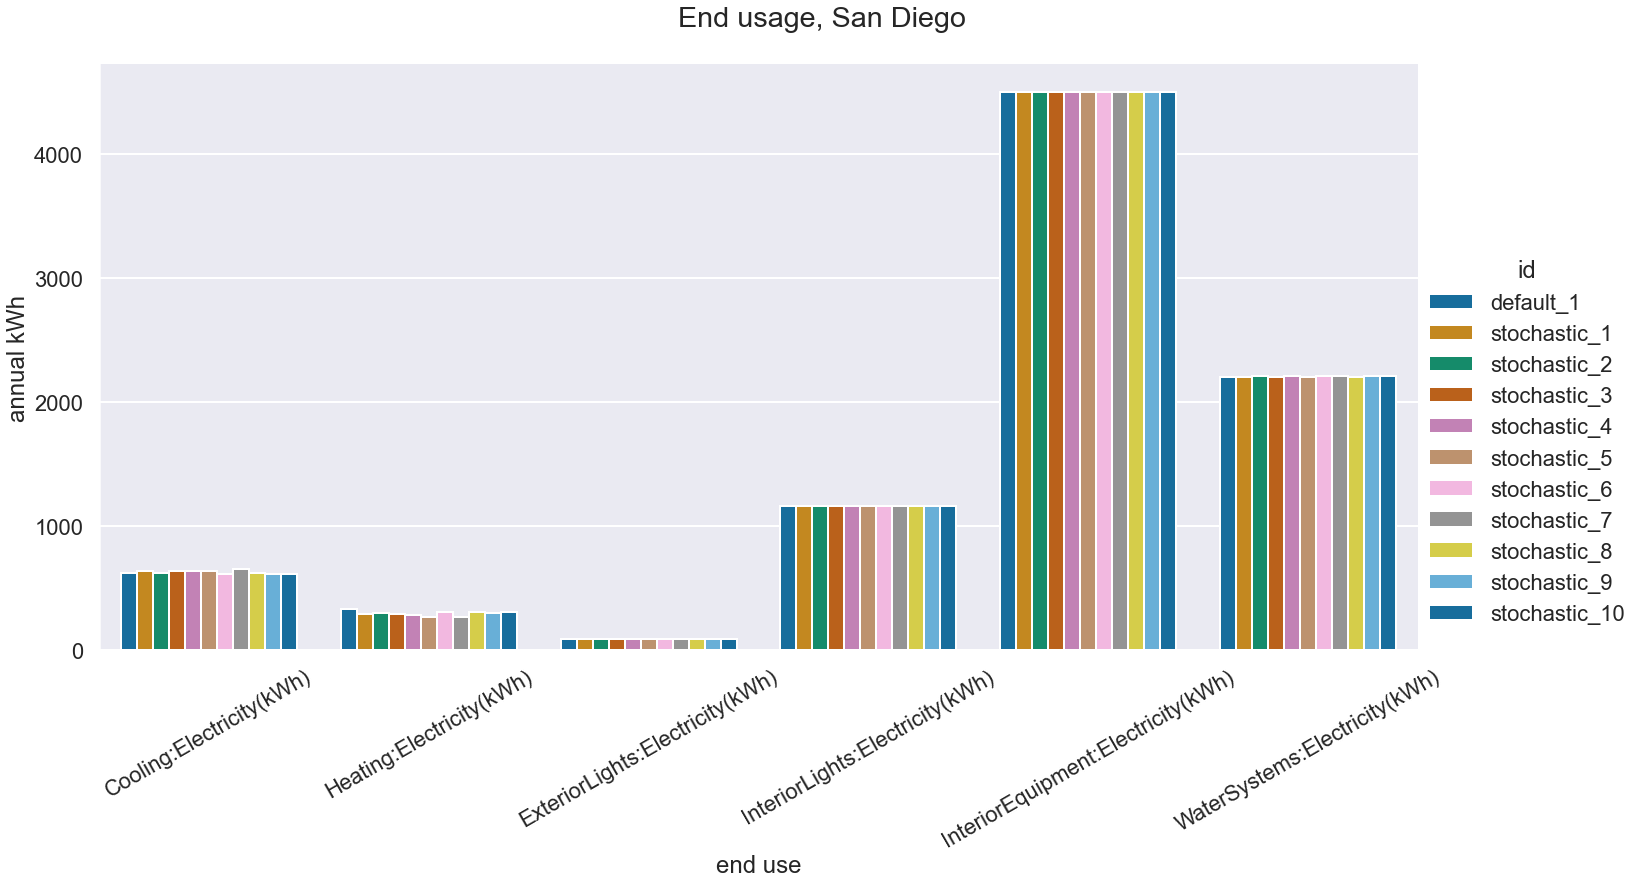

In [24]:
# Compare end-use energy between stochastic and default runs.
# Also plot occupancy

power_cols = [
    'Electricity:Facility(kWh)', 'Cooling:Electricity(kWh)',
    'Heating:Electricity(kWh)', 'InteriorLights:Electricity(kWh)',
    'ExteriorLights:Electricity(kWh)', 'InteriorEquipment:Electricity(kWh)',
    'Fans:Electricity(kWh)', 'Pumps:Electricity(kWh)',
    'WaterSystems:Electricity(kWh)'
]

end_use_cols = [c for c in power_cols if c != 'Electricity:Facility(kWh)']

location = "San Diego"

buildings = []

for building in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    power = results.get_scenario_electricity_usage(location, 'stochastic',
                                                   building, 10)
    schedule = results.get_scenario_schedule(location, building, 10)
    schedule.columns = [c + '_sched' for c in schedule.columns ]
    data = pd.concat([power, schedule], axis=1)
    data['building_num'] = building
    data['schedules_type'] = 'stochastic'
    buildings.append(data)

default = results.get_scenario_electricity_usage(location, 'default')
default['schedules_type'] = 'default'
default['building_num'] = 1
buildings.append(default)
    
end_uses = pd.pivot_table(pd.concat(buildings),
                          index=['schedules_type', 'building_num', 'Datetime'])

run_1 = end_uses.loc[('stochastic', 1)]
run_2 = end_uses.loc[('stochastic', 2)]

for col in run_1.columns:
    if (run_1[col] == run_2[col]).all():
        print(col, "is the same.")

start = "2007-06-01"
end = "2007-06-02"
# fig = plt.figure(figsize=(20, 20))
# ax1 = fig.add_subplot(3, 1, 1)
# ax2 = fig.add_subplot(3, 1, 2)
# ax3 = fig.add_subplot(3, 1, 3)
# run_1 = end_uses.loc[('stochastic', 1)]
# run_2 = end_uses.loc[('stochastic', 2)]
# run_default = end_uses.loc[('default', 1)]
# # run_1.loc[start:end][end_use_cols].plot.area(ax=ax1)
# ax1.stackplot(run_1.loc[start:end].index, run_1.loc[start:end, end_use_cols].values.T,
#               labels=end_use_cols, linewidth=0)
# ax1.margins(x=0)
# # run_2.loc[start:end][notarea].plot.area(ax=ax2)
# ax2.stackplot(run_2.loc[start:end].index, run_2.loc[start:end, end_use_cols].values.T,
#               labels=end_use_cols, linewidth=0)
# ax2.margins(x=0)
# run_default.loc[start:end][end_use_cols].plot.area(ax=ax3)

# ax1.get_xaxis().set_visible(False)
# ax2.get_xaxis().set_visible(False)

# ax1.legend(loc=2, prop={"size": 12})
# ax2.legend().remove()
# ax3.legend().remove()

# ax1.set_title(f"Energy end use, {location} Stochastic Schedule #1")
# ax2.set_title(f"Energy end use, {location} Stochastic Schedule #2")
# ax3.set_title(f"Energy end use, {location} Default Schedule")

# ax1_schedule = ax1.twinx()
# ax1_schedule.plot_date(run_1_sched.loc[start:end].index, run_1_sched.loc[start:end]['occupants'], '-',
#                   label='occupancy', alpha=1)
# ax2_schedule = ax2.twinx()
# ax2_schedule.plot_date(run_2_sched.loc[start:end].index, run_2_sched.loc[start:end]['occupants'], '-',
#                   label='occupancy', alpha=1)
# ax1_schedule.legend(loc=1)
# ax1_schedule.grid(False)
# ax2_schedule.grid(False)

# ax3.get_xaxis().set_major_formatter(mdates.DateFormatter('%a'))

# Make plots that are not stacked so we can see any discrepencies in end use loads
indices = [
    ('stochastic', 1),
    ('stochastic', 2),
    ('stochastic', 3),
    ('stochastic', 4),
    ('stochastic', 5),
    ('default', 1)
]

end_use_subsets = [
    "Cooling:Electricity(kWh)",
    "Heating:Electricity(kWh)",
    "ExteriorLights:Electricity(kWh)",
    "InteriorLights:Electricity(kWh)",
    "InteriorEquipment:Electricity(kWh)",
    "WaterSystems:Electricity(kWh)"
]

# num_load_categories = len(end_use_subsets)
# fig, axs = plt.subplots(2, 3,
#                         figsize=(50, 5 * 4),
#                         squeeze=False)

# for _, run in enumerate(indices):
#     for j, end_use in enumerate(end_use_subsets):
#         ax = axs.flatten()[j]
#         data = end_uses.loc[run, end_use].loc[start:end]
#         if "default" in run:
#             linestyle = 'dashed'
#         else:
#             linestyle = 'solid'
#         ax.plot_date(data.index, data, linestyle=linestyle, label=run, alpha=0.8,
#                      marker="")
#         ax.set_title(str(end_use))
#         ax.legend()

#     axs[0][0].set_ylabel('kW')

# plt.subplots_adjust(wspace=0.1, hspace=0.3)
# plt.legend()
# fig.autofmt_xdate()
# fig.tight_layout()

# Compare total energy by end use category...
end_use_sums = pd.pivot_table(pd.concat(buildings),
                              index=['schedules_type', 'building_num'],
                              aggfunc='sum').reset_index()
end_use_sums['id'] = \
    end_use_sums['schedules_type'] + "_" + end_use_sums['building_num'].astype(str)
end_use_sums = end_use_sums.melt(id_vars=['id'], value_vars=end_use_subsets,
                  var_name='end use', value_name='annual kWh')
ax = sns.catplot(data=end_use_sums, x='end use', y='annual kWh', hue='id',
                 kind='bar', height=10, aspect=2, palette='colorblind')
ax.set_xticklabels(rotation=30)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle(f"End usage, {location}")

In [27]:
end_uses

Cooling:Electricity(kWh)  \
schedules_type building_num Datetime                                        
default        1            2007-01-01 01:00:00                       0.0   
                            2007-01-01 02:00:00                       0.0   
                            2007-01-01 03:00:00                       0.0   
                            2007-01-01 04:00:00                       0.0   
                            2007-01-01 05:00:00                       0.0   
...                                                                   ...   
stochastic     10           2007-12-31 20:00:00                       0.0   
                            2007-12-31 21:00:00                       0.0   
                            2007-12-31 22:00:00                       0.0   
                            2007-12-31 23:00:00                       0.0   
                            2008-01-01 00:00:00                       0.0   

                                                 Electricity:Facility(kWh)  \
schedules_type building_num Datetime                                         
default        1            2007-01-01 01:00:00                   0.413863   
                            2007-01-01 02:00:00                   0.367061   
                            2007-01-01 03:00:00                   0.339527   
                            2007-01-01 04:00:00                   0.329879   
                            2007-01-01 05:00:00                   0.345043   
...                                                                    ...   
stochastic     10           2007-12-31 20:00:00                   1.842815   
                            2007-12-31 21:00:00                   2.265102   
                            2007-12-31 22:00:00                   2.169130   
                            2007-12-31 23:00:00                   1.163521   
                            2008-01-01 00:00:00                   1.339322   

                                                 ExteriorLights:Electricity(kWh)  \
schedules_type building_num Datetime                                               
default        1            2007-01-01 01:00:00                         0.014092   
                            2007-01-01 02:00:00                         0.014092   
                            2007-01-01 03:00:00                         0.014092   
                            2007-01-01 04:00:00                         0.014092   
                            2007-01-01 05:00:00                         0.014092   
...                                                                          ...   
stochastic     10           2007-12-31 20:00:00                         0.020530   
                            2007-12-31 21:00:00                         0.021757   
                            2007-12-31 22:00:00                         0.021143   
                            2007-12-31 23:00:00                         0.018076   
                            2008-01-01 00:00:00                         0.015315   

                                                 Fans:Electricity(kWh)  \
schedules_type building_num Datetime                                     
default        1            2007-01-01 01:00:00                    0.0   
                            2007-01-01 02:00:00                    0.0   
                            2007-01-01 03:00:00                    0.0   
                            2007-01-01 04:00:00                    0.0   
                            2007-01-01 05:00:00                    0.0   
...                                                                ...   
stochastic     10           2007-12-31 20:00:00                    0.0   
                            2007-12-31 21:00:00                    0.0   
                            2007-12-31 22:00:00                    0.0   
                            2007-12-31 23:00:00                    0.0   
                            2008-01-01 00:00:00    

In [ ]:
# Compare average hourly occupancy for different occupant clusters.
occupant_map = {
    '0': 'mostly home',
    '1': 'early regular worker',
    '2': 'mostly away',
    '3': 'regular worker'
}

# Also plot occupancy

power_cols = [
    'Electricity:Facility(kWh)', 'Cooling:Electricity(kWh)',
    'Heating:Electricity(kWh)', 'InteriorLights:Electricity(kWh)',
    'ExteriorLights:Electricity(kWh)', 'InteriorEquipment:Electricity(kWh)',
    'Fans:Electricity(kWh)', 'Pumps:Electricity(kWh)',
    'WaterSystems:Electricity(kWh)'
]

end_use_cols = [c for c in power_cols if c != 'Electricity:Facility(kWh)']

location = "Fargo"

buildings = []

for building in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    power = results.get_scenario_electricity_usage(location, 'stochastic',
                                                   building, 10, )
    schedule = results.get_scenario_schedule(location, building, 10)
    schedule.columns = [c + '_sched' for c in schedule.columns ]
    data = pd.concat([power, schedule], axis=1)
    data['building_num'] = building
    data['schedules_type'] = 'stochastic'
    buildings.append(data)

default = results.get_scenario_electricity_usage(location, 'default')
default['schedules_type'] = 'default'
default['building_num'] = 1
buildings.append(default)
    
end_uses = pd.pivot_table(pd.concat(buildings),
                          index=['schedules_type', 'building_num', 'Datetime'])

run_1 = end_uses.loc[('stochastic', 1)]
run_2 = end_uses.loc[('stochastic', 2)]

for col in run_1.columns:
    if (run_1[col] == run_2[col]).all():
        print(col, "is the same.")

start = "2007-06-01"
end = "2007-06-02"
# Make plots that are not stacked so we can see any discrepencies in end use loads
indices = [
    ('stochastic', 1),
    ('stochastic', 2),
    ('stochastic', 3),
    ('stochastic', 4),
    ('stochastic', 5),
    ('default', 1)
]

end_use_subsets = [
    "Cooling:Electricity(kWh)",
    "Heating:Electricity(kWh)",
    "ExteriorLights:Electricity(kWh)",
    "InteriorLights:Electricity(kWh)",
    "InteriorEquipment:Electricity(kWh)",
    "WaterSystems:Electricity(kWh)"
]


Text(0.5, 0.98, 'Mean daily occupancy, 10 stochastic yearly schedules')

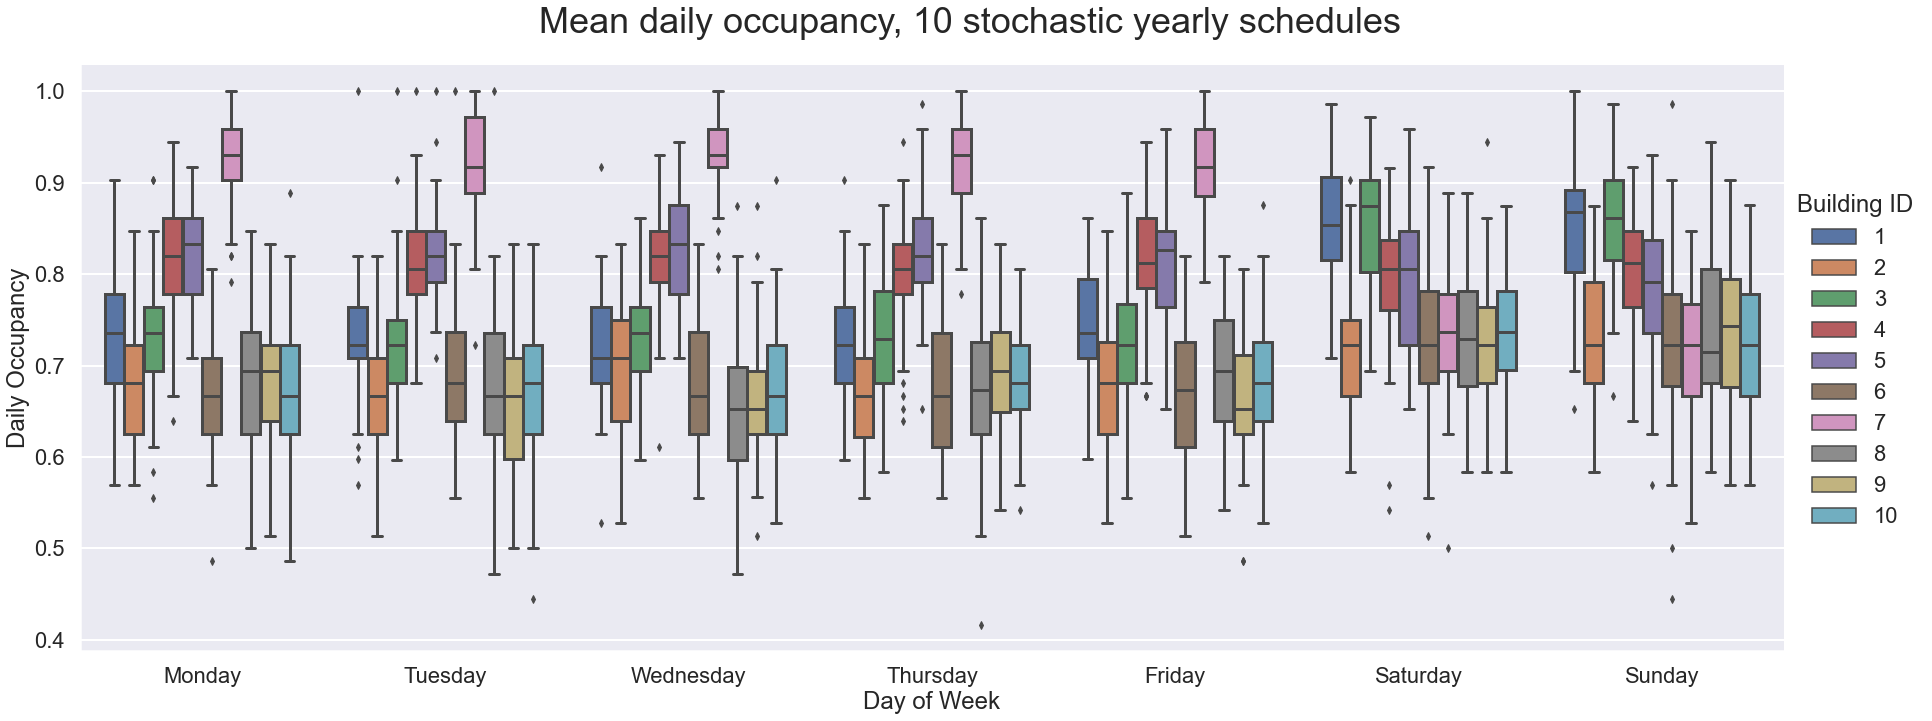

In [476]:
# Get the scenario schedules and compare occupancy by day of week...
location = "Fargo"
num_simulations = 10
frames = []
for building_num in range(1, num_simulations + 1):
    df = results.get_scenario_schedule(
        location, building_num, num_simulations)
    df = df.resample("1D").mean()
    df["Day of Week"] = df.index.strftime("%A")
    df["Building ID"] = building_num
    frames.append(df)
frame = pd.concat(frames)
frame.rename(columns={"occupants": "Daily Occupancy"},
             inplace=True)

ax = sns.catplot(x="Day of Week", y="Daily Occupancy", data=frame,
                 hue="Building ID", kind="box",
                 height=10, aspect=2.5)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle(f"Mean daily occupancy, {num_simulations} stochastic yearly schedules",
                fontsize=36)

In [118]:
# Make sure we don't get the stochastic scenarios with 100 runs for speed
scenarios = results.get_matching_scenarios(
    {
        "num_simulations": [1, 10], "schedules_type": "stochastic",
        "schedules_occupant_types": None
    }
)

for scenario in scenarios:
    results.load(scenario_pattern=scenario)
    
data = results.to_dataframe(scenarios=scenarios)

data = data.loc[data['storage_rebate'] >= 200]
data['utility_rate'] = data['utility'] + ' - ' + data['urdb']

pivot = pd.pivot_table(data, columns='utility_rate',
                       index=['location','schedules_type', 'net_metering_limit', 'storage_rebate'])


# List locations by lowest to highest latitude.
locations = data['location'].unique()
latitudes = {}
for loc in locations:
    latitudes[loc] = data.loc[data['location'] == loc]['latitude'][0]
locations_by_latitude = sorted(latitudes, key=lambda k: latitudes[k])
    
# Make location colors match the latitude
colors = sns.color_palette('viridis', len(data['location'].unique()))
location_colors = {
    loc: colors[i] for i, loc in enumerate(locations_by_latitude)
}


# Marker mapping for each location.
markers = itertools.cycle(['o', 'v', 'P', 'D'])
location_markers = {
    loc: next(markers) for loc in locations_by_latitude
}

def plot_rebates(dataframe, y=['storage_size_kwh'], common_y_scales=True):
    multi = pd.pivot_table(
        dataframe, columns='utility_rate',
        index=['location','schedules_type', 'net_metering_limit', 'storage_rebate'])

    def get_idx_lvl_vals(key):
        """
        Get the unique index level values.
        """
        return multi.index.get_level_values(key).unique()
    
    
    utilities = multi.columns.get_level_values('utility_rate').unique()
    rows = len(utilities)
    cols = len(y)
    fig, axs = plt.subplots(len(utilities), len(y),
                            figsize=(15 * cols, 10 * rows),
                            squeeze=False)
    
    # Row
    for i, utility in enumerate(utilities):
        for j, y_col in enumerate(y):
            for location in get_idx_lvl_vals('location'):
                for schedules_type in get_idx_lvl_vals('schedules_type'):
                    for net_metering in get_idx_lvl_vals('net_metering_limit'):
                        try:
                            points = multi.loc[
                                (location, schedules_type, net_metering),
                                (y_col, utility)
                            ]
                        except KeyError:
                            continue
                        if schedules_type == 'default':
                            continue

                        if net_metering:
                            linestyle = 'solid'
                        else:
                            linestyle = 'dashed'

                        color = location_colors[location]
                        ax = axs[i][j]

                        ax.plot(
                            points.index, points.values, linestyle=linestyle,
                            color=location_colors[location], 
                            marker=location_markers[location],
                            label=f"{location}, {schedules_type} schedule, NM = {bool(net_metering)}",
                            alpha=0.8)
                        ax.set_xlabel('storage rebate ($/kWh)')
                        ax.set_ylabel(y_col)
                        ax.set_title(utility)
        
    # resize the y limits to be the same based on the widest range in the columns.
    if common_y_scales:
        for j in range(cols):
            y_min = 0
            y_max = 0
            for i in range(rows):
                ylower, yupper = axs[i][j].get_ylim()
                if ylower < y_min:
                    y_min = ylower
                if yupper > y_max:
                    y_max = yupper
            for i in range(rows):
                axs[i][j].set_ylim(y_min, y_max)

    axs[0][-1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)

data['annual_savings'] = data['savings'] / 25
plot_rebates(data, ["storage_size_kwh", "storage_size_kw", "pv_size", "annual_savings"])
# plot_rebates(data, ["storage_size_kwh", "storage_size_kw", "pv_size", "annual_savings"],
#              common_y_scales=False)


def plot_rebates_normed(dataframe, y_cols, norm_col):
    normalized = dataframe.copy()
    new_cols = []
    for col in y_cols:
        new_name = col + "_" + norm_col + "_normed"
        new_cols.append(new_name)    
        normalized[new_name] = normalized[col] / normalized[norm_col] * 1000
    plot_rebates(normalized, new_cols)
    

# plot_rebates_normed(data, ["storage_size_kwh", "storage_size_kw", "pv_size", "annual_savings"],
#                     "load_annual_kwh")

# plot_rebates_normed(data, ["storage_size_kwh", "storage_size_kw", "pv_size", "annual_savings"],
#                     "pv_size")

# plot_rebates_normed(data, ["storage_size_kwh"], "storage_size_kw")

loading runs for home-oklahoma-city-3-bd-2301-sched-stochastic-2054209463...
loading runs for home-san-diego-3-bd-2301-sched-stochastic-9542565323...
loading runs for home-honolulu-3-bd-2301-sched-stochastic-5320435741...
loading runs for home-fargo-3-bd-2301-sched-stochastic-4349722408...
loading runs for home-phoenix-3-bd-2301-sched-stochastic-4841998617...


KeyboardInterrupt: 

In [9]:
# Compare differences in occupant behavior for different clusterings
occupancies = results.get_electricity_usage_and_occupancy(
    locations=['Fargo', 'Phoenix'], schedules_types=['default', 'stochastic'],
    building_nums=list(range(1, 11)),
    occupant_types=[None, '000', '111', '222', '333']
)

No scenario with location Fargo found that satisfies schedules_type=default, building_num=1
Loaded loc=Fargo, schedule=stochastic, building_num=1, occupants=None
Loaded loc=Fargo, schedule=stochastic, building_num=1, occupants=000
Loaded loc=Fargo, schedule=stochastic, building_num=1, occupants=111
Loaded loc=Fargo, schedule=stochastic, building_num=1, occupants=222
Loaded loc=Fargo, schedule=stochastic, building_num=1, occupants=333
Loaded loc=Fargo, schedule=stochastic, building_num=2, occupants=None
Loaded loc=Fargo, schedule=stochastic, building_num=2, occupants=000
Loaded loc=Fargo, schedule=stochastic, building_num=2, occupants=111
Loaded loc=Fargo, schedule=stochastic, building_num=2, occupants=222
Loaded loc=Fargo, schedule=stochastic, building_num=2, occupants=333
Loaded loc=Fargo, schedule=stochastic, building_num=3, occupants=None
Loaded loc=Fargo, schedule=stochastic, building_num=3, occupants=000
Loaded loc=Fargo, schedule=stochastic, building_num=3, occupants=111
Loaded l

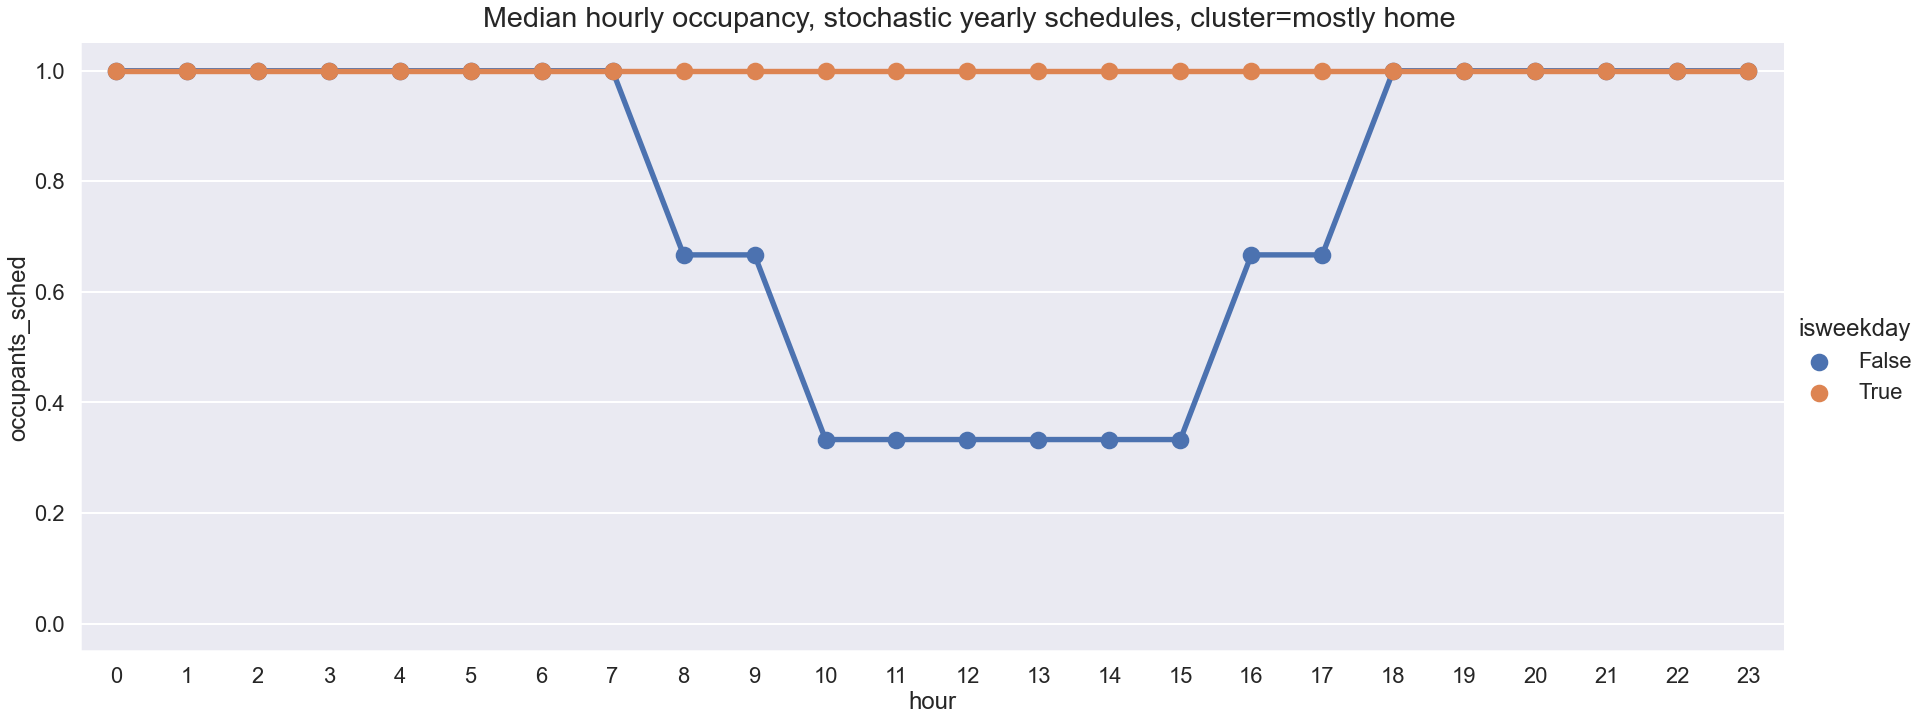

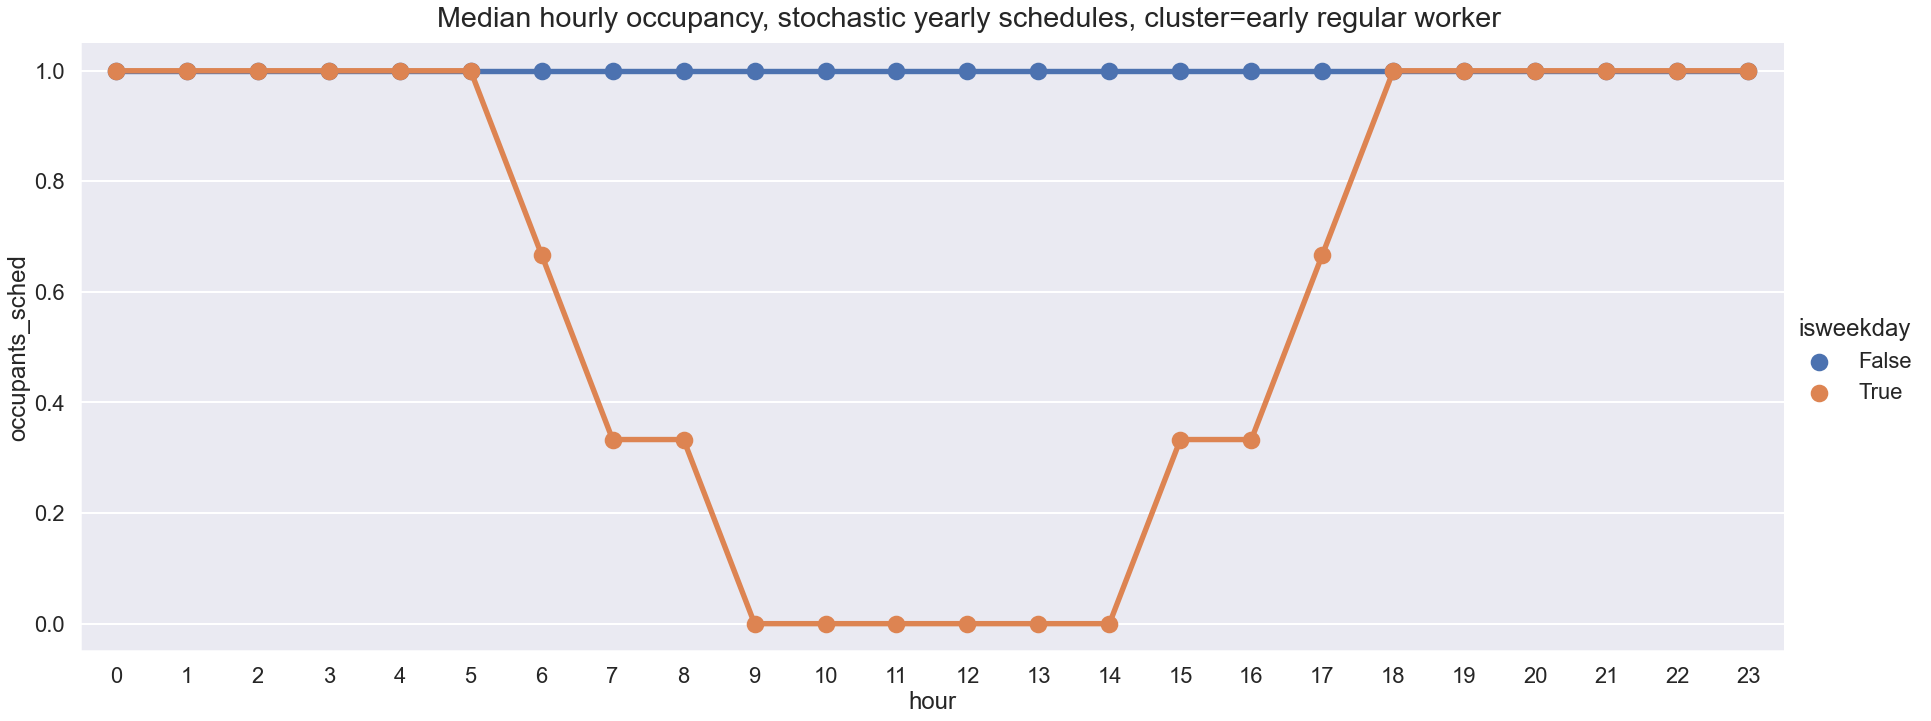

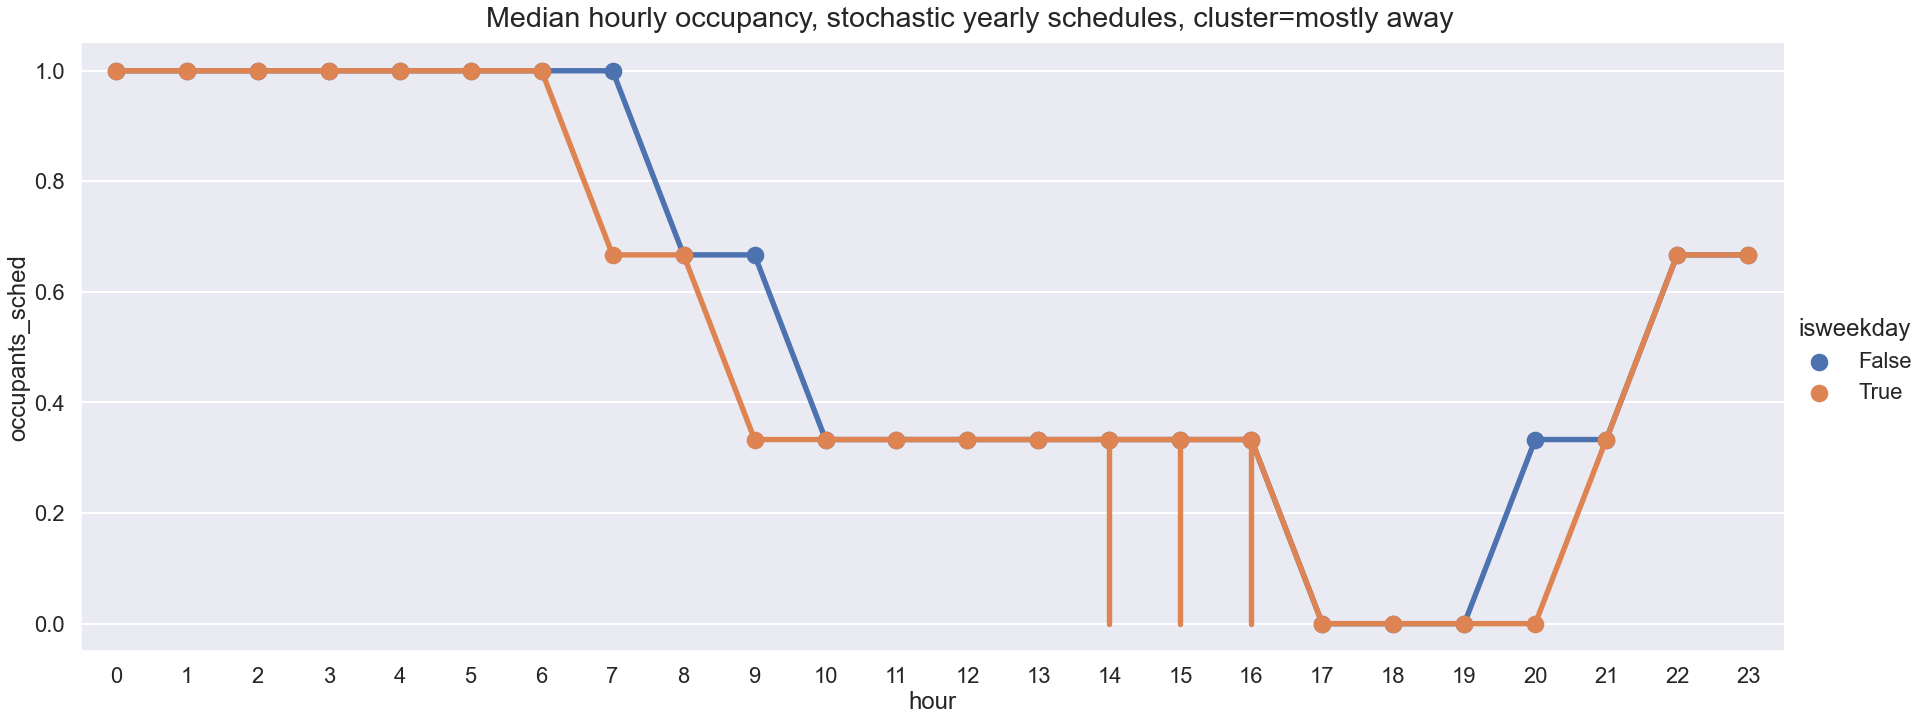

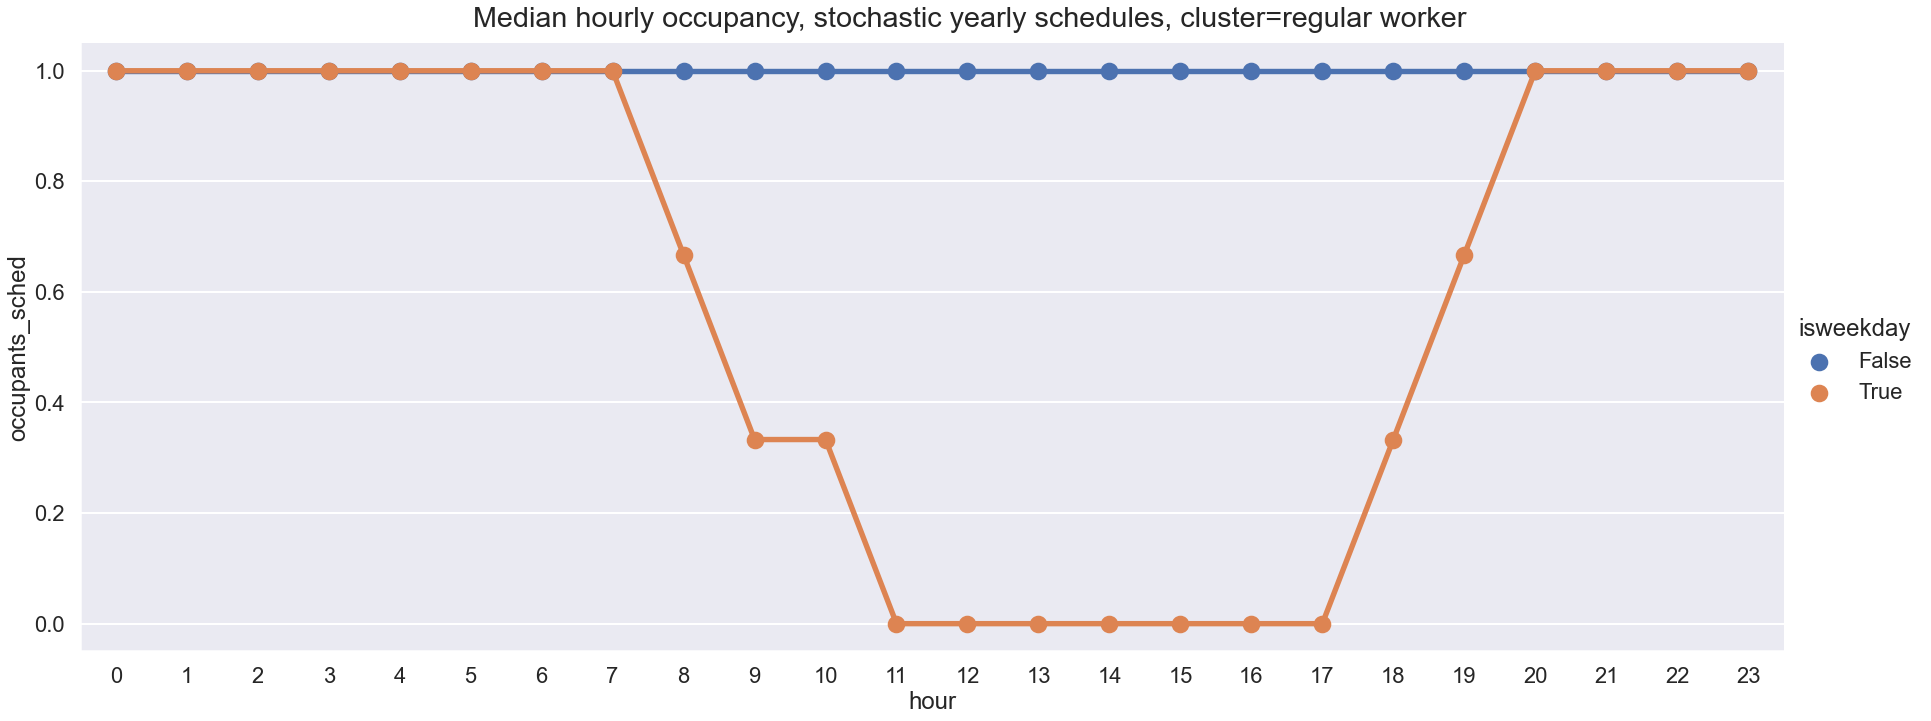

In [26]:
def resample_multiindex(df, freq):
    """
    Do grouping if the innermost index is datetime.
    """
    level_values = df.index.get_level_values
    return (df.groupby([level_values(i) for i in range(df.index.nlevels - 1)]
                       +[pd.Grouper(freq=freq, level=-1)]).mean())

CLUSTERS = {
    "000": "mostly home",
    "111": "early regular worker",
    "222": "mostly away",
    "333": "regular worker"
}

occupancies['dayofweek'] = occupancies.index.get_level_values(-1).strftime("%a")

# Compare average daily occupancy across clusters
for cluster, description in CLUSTERS.items():
    break
    occupancies_resampled = resample_multiindex(
        occupancies.loc[('Fargo', 'stochastic', cluster)], '1D'
    )
    occupancies_resampled['dayofweek'] = \
        occupancies_resampled.index.get_level_values(-1).strftime("%a")
    ax = sns.catplot(x="dayofweek", y="occupants_sched",
                     data=occupancies_resampled.reset_index(level=0),
                     hue="building_num", kind="box",
                     height=10, aspect=2.5)
    ax.fig.suptitle(
        f"Mean daily occupancy, stochastic yearly schedules, cluster={description}",
        fontsize=36
    )
    ax.fig.subplots_adjust(top=0.92)


# Plot hourly occupancy for weekday / weekend
occupancies['isweekday'] = \
    occupancies.index.get_level_values(-1).dayofweek < 5
occupancies['hour'] = occupancies.index.get_level_values(-1).hour

for cluster, description in CLUSTERS.items():
    ax = sns.catplot(x='hour', y='occupants_sched',
                     data=occupancies.loc[('Fargo', 'stochastic', cluster)]
                         .reset_index(level=0),
                    hue='isweekday', kind='point',
                    height=10, aspect=2.5, estimator=np.median
                    )
    ax.fig.suptitle(
        f'Median hourly occupancy, stochastic yearly schedules, cluster={description}'
    )
    ax.fig.subplots_adjust(top=0.93)
    ax.set(ylim=(-0.05, 1.05))


In [56]:
# Compare the total energy usage by season

def groupby_season_sum(frame):
    """
    Group multiindex by season and sum columns
    """
    df = frame.copy()
    df = add_season_col(df)
    level_values = df.index.get_level_values
    df = (df.groupby([level_values(i) for i in range(df.index.nlevels - 1)]
                     +[pd.Grouper(key='season')]).sum())
    return df

def add_season_col(df):
    """
    spring: Mar - May
    summer: Jun - Aug
    fall: Sep - Nov
    winter: Dec - Feb
    """
    df['season'] = (df.index.get_level_values(-1).month%12+ 3) // 3
    df['season'] = df['season'].map({
            1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'
        }
    )
    return df


def compare_energy_usage_by_season(
        frame, clusters_names, location, electricity_col='Electricity:Facility(kWh)'
    ):
    """
    Expects multiindex of schedules_type -> occupant_types -> building_num -> datetime
    
    spring: Mar - May
    summer: Jun - Aug
    fall: Sep - Nov
    winter: Dec - Feb
    """
    grouped = groupby_season_sum(frame)
    grouped.reset_index(inplace=True)
    grouped['cluster'] = grouped['occupant_types'].map(clusters_names)
    ax = sns.catplot(x="season", y=electricity_col,
                     hue="cluster",data=grouped,
                     kind="violin", height=8.27,
                     order=['spring', 'summer', 'fall', 'winter'],
                     aspect=2)
    ax.fig.suptitle(
        f'Total seasonal energy usage, {location}'
    )
    ax.fig.subplots_adjust(top=0.93)
    

def compare_energy_profiles_by_season(frame, clusters_names, location,
                                      electricity_col='Electricity:Facility(kWh)',
                                      convert_to_kw=True, overlay_profiles=False,
                                      add_schedules=False):
    """
    Plot a bunch of line graphs of home electricity usage overlaid on each other.
    
    Expects multiindex of schedules_type -> occupant_types -> building_num -> datetime
    
    spring: Mar - May
    summer: Jun - Aug
    fall: Sep - Nov
    winter: Dec - Feb
    
    :param multiple_lines: Instead of generating a shaded confidence interval, just plot all the lines.
    """
    if frame.index.names[0] == 'location':
        raise ValueError("Location index should be dropped.")
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True,
                            figsize=(24, 14), squeeze=False)
    frame = add_season_col(frame.copy())
    unrolled = frame.reset_index(('schedules_type', 'occupant_types', 'building_num'))
    unrolled['hour'] = unrolled.index.hour + unrolled.index.minute / 60
    unrolled['cluster'] = unrolled['occupant_types'].map(clusters_names)
    unrolled['units'] = (
        unrolled.index.strftime('%Y-%m-%d') +
        unrolled['occupant_types'] +
        unrolled['building_num'].astype(str)
    )
    # Convert vales to kW
    if convert_to_kw:
        steps_per_h = 3600 / (unrolled.index[1] - unrolled.index[0]).total_seconds()
        unrolled[electricity_col] /= steps_per_h
        
    num_buildings = len(unrolled['building_num'].unique())
    
    for i, season in enumerate(('spring', 'summer', 'fall', 'winter')):
        ax = axs[i//2][i%2]
        season_data = unrolled.loc[unrolled['season'] == season]
        if overlay_profiles:
            estimator = None
            units = 'units'
            alpha = 0.3
            ci = None
        else:
            estimator = np.median
            units = None
            alpha = 1
            ci = 'sd'
        sns.lineplot(
            data=season_data, x='hour', y=electricity_col, hue='cluster',
            style='cluster', ax=ax, units=units, estimator=estimator, ci=ci,
            alpha=alpha)
        ax.set_title(f"{location} daily energy profile, {season} {num_buildings} buildings")
        if i != 1:
            ax.legend().set_visible(False)

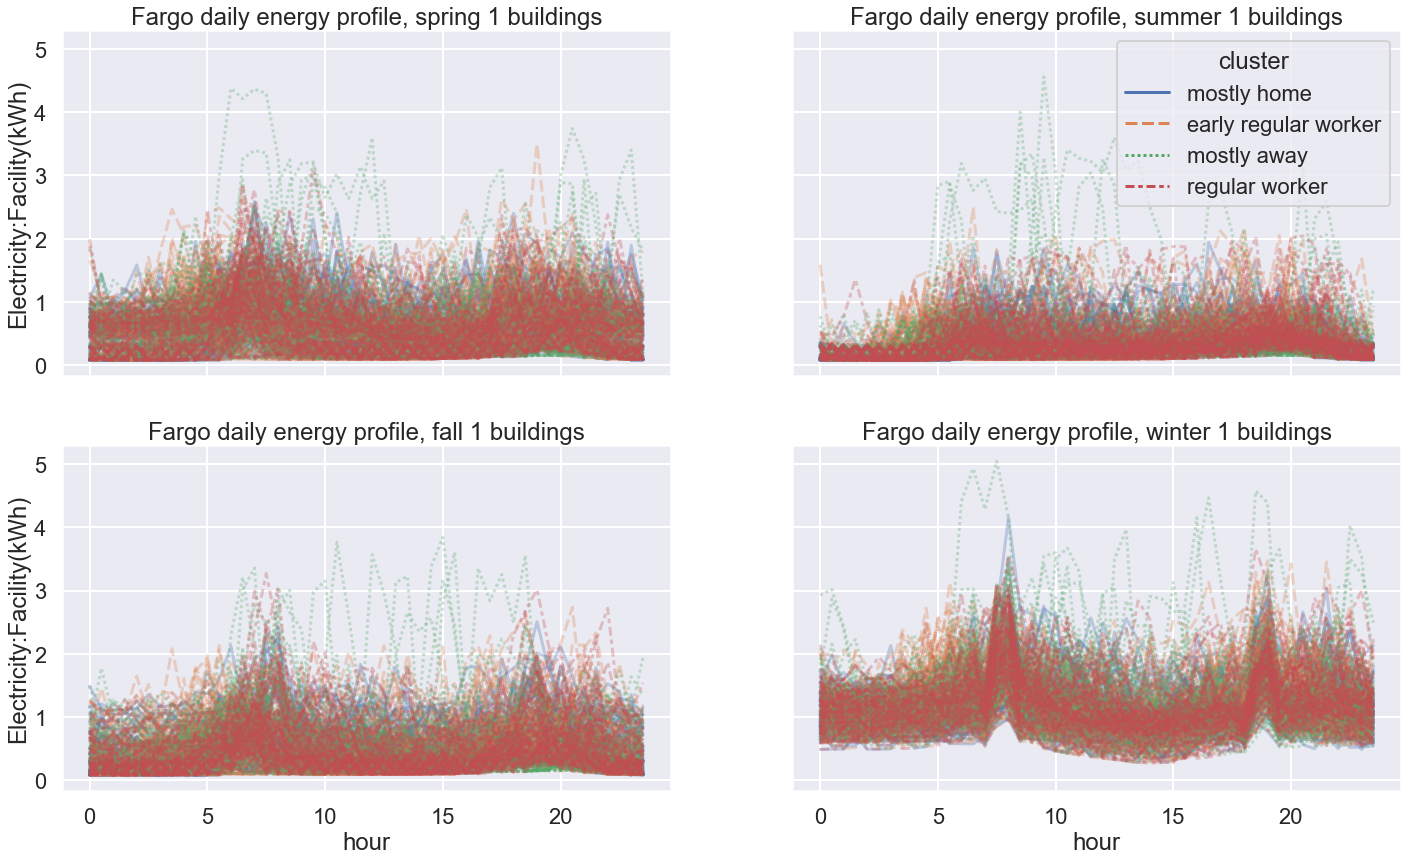

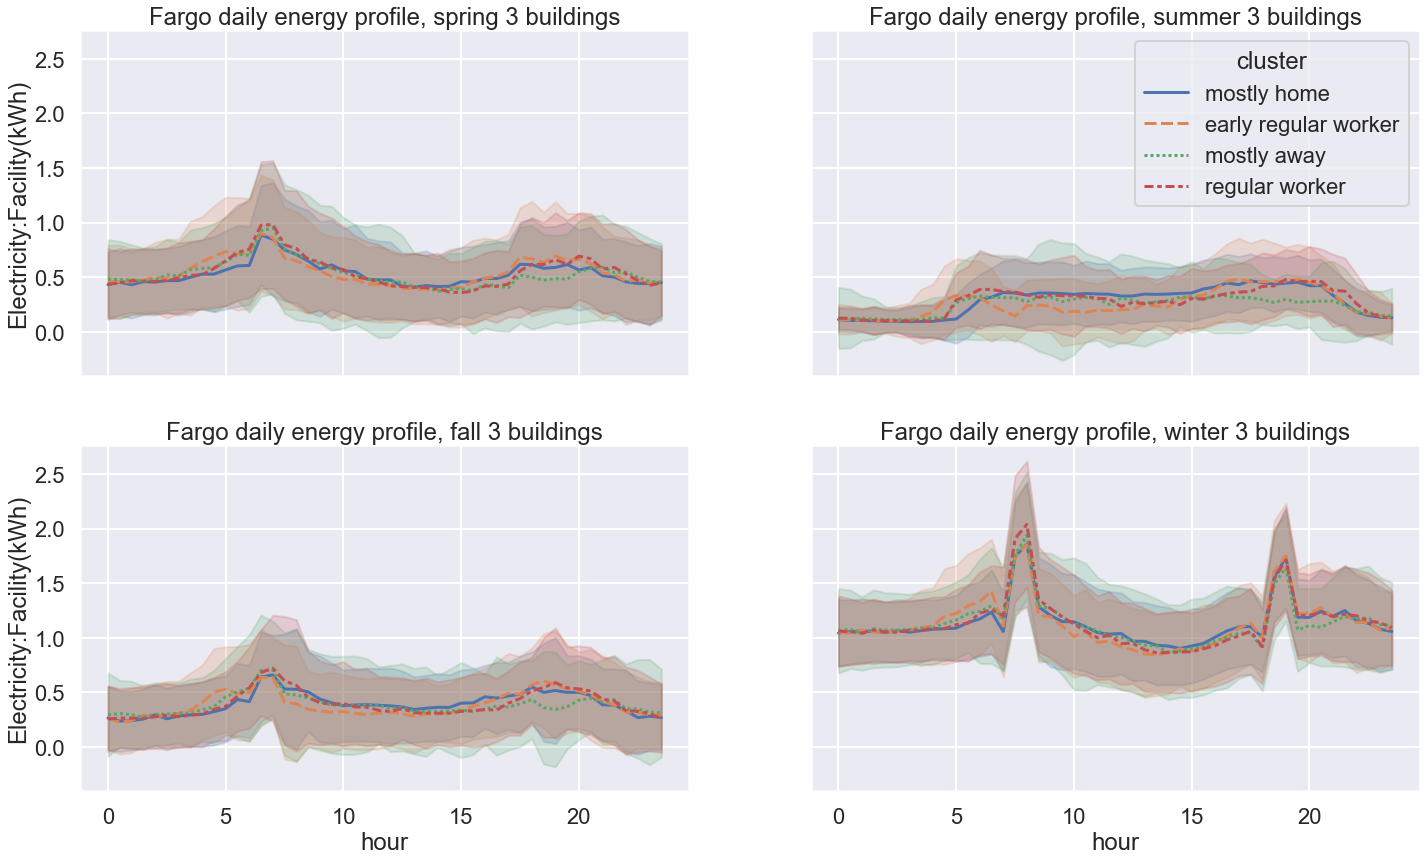

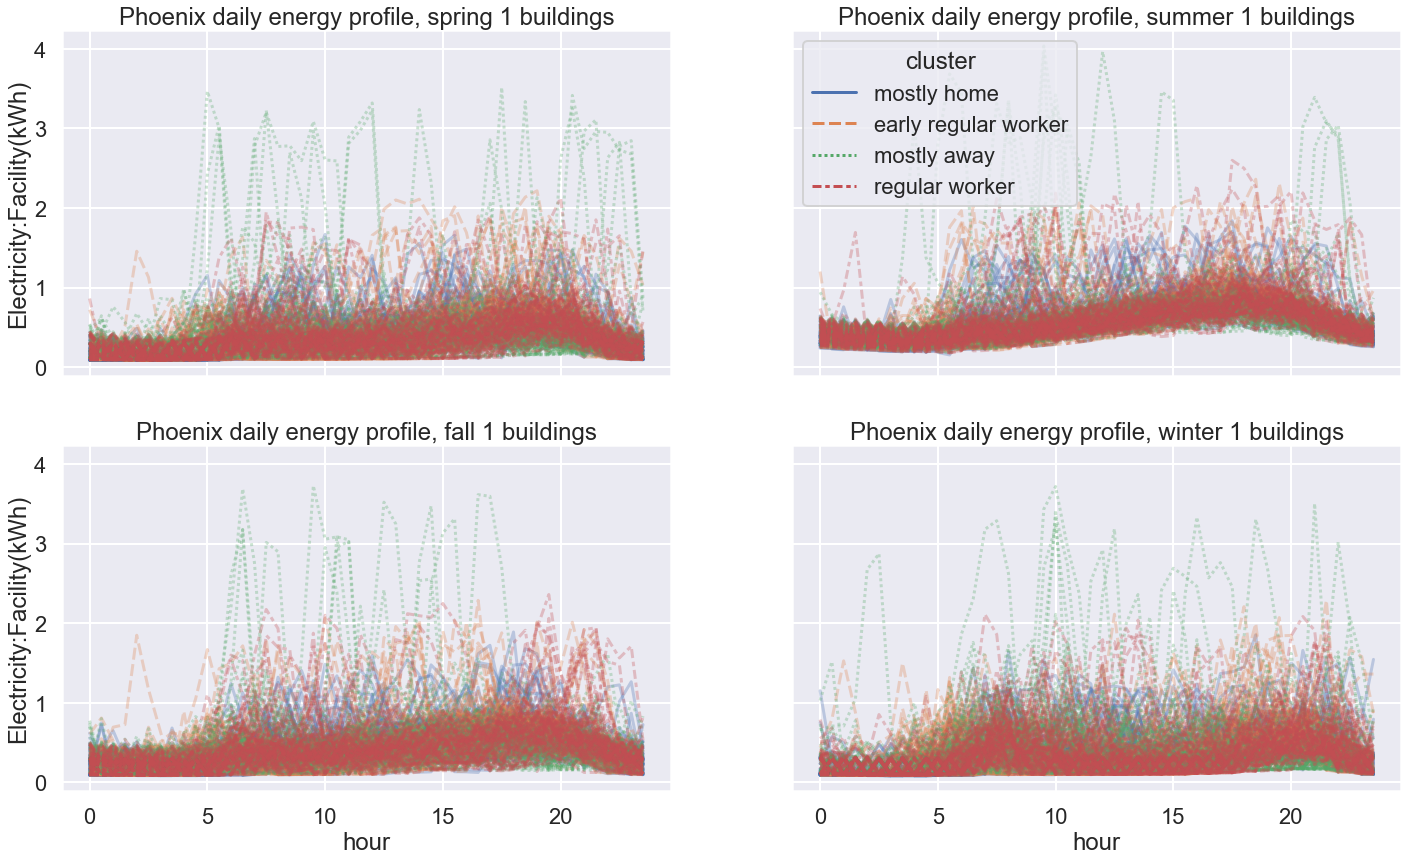

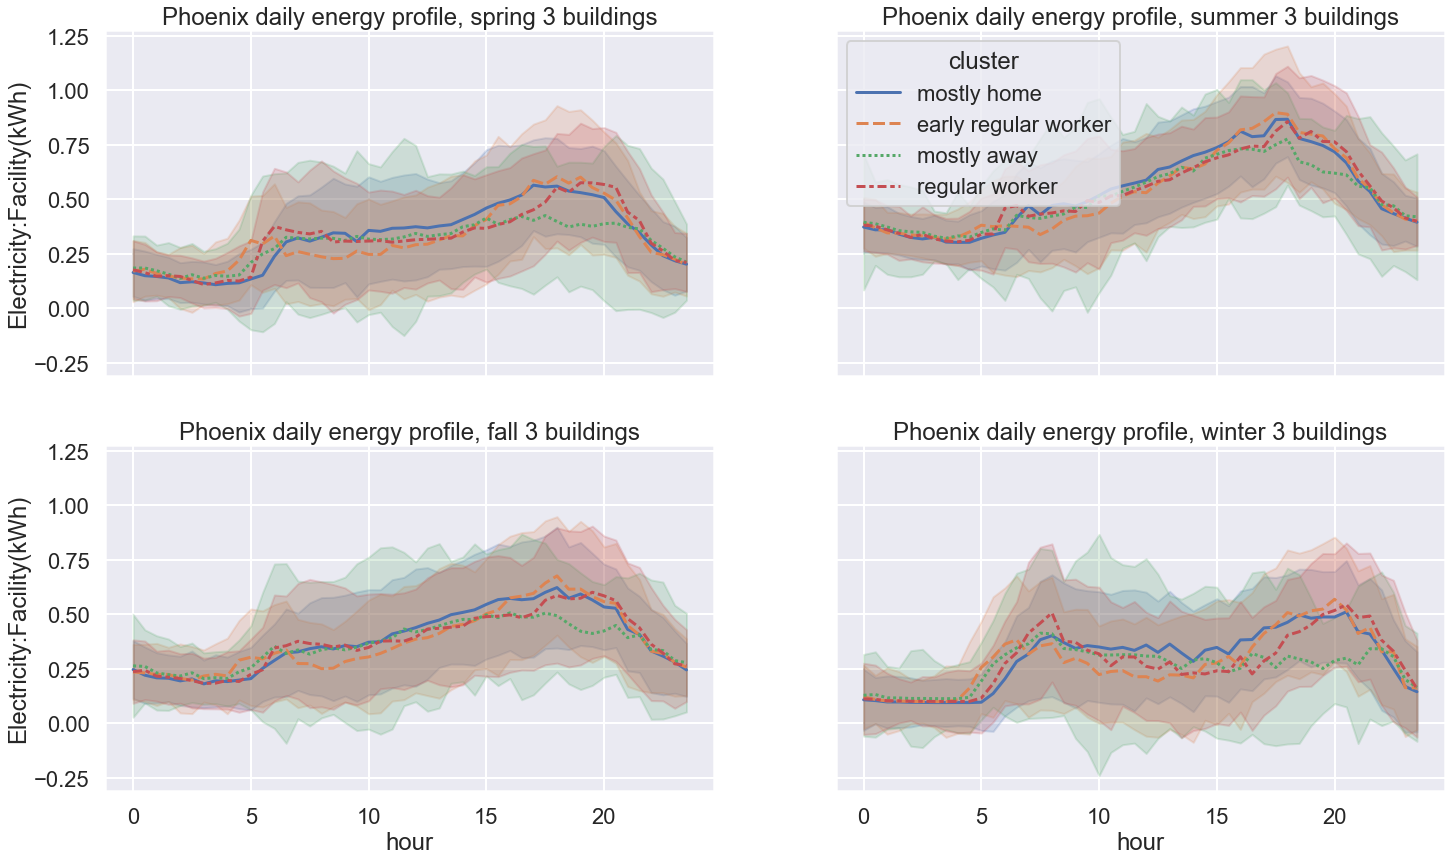

In [59]:
compare_energy_profiles_by_season(
    occupancies.loc[(('Fargo',), slice(None), slice(None), (1,)), :].loc['Fargo', :],
    CLUSTERS, 'Fargo', overlay_profiles=True)

compare_energy_profiles_by_season(
    occupancies.loc[(('Fargo',), slice(None), slice(None), (1, 2, 3)), :].loc['Fargo', :],
    CLUSTERS, 'Fargo', overlay_profiles=False)

compare_energy_profiles_by_season(
    occupancies.loc[(('Phoenix',), slice(None), slice(None), (1,)), :].loc['Phoenix', :],
    CLUSTERS, 'Phoenix', overlay_profiles=True)

compare_energy_profiles_by_season(
    occupancies.loc[(('Phoenix',), slice(None), slice(None), (1, 2, 3)), :].loc['Phoenix', :],
    CLUSTERS, 'Phoenix', overlay_profiles=False)

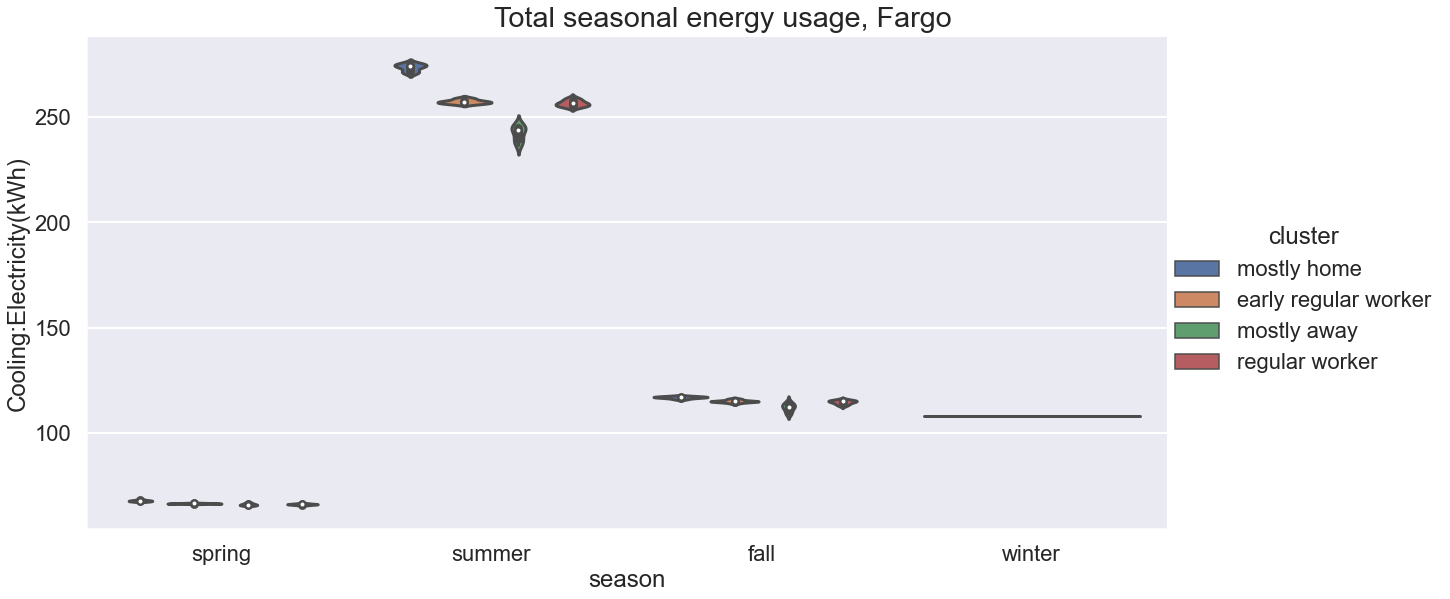

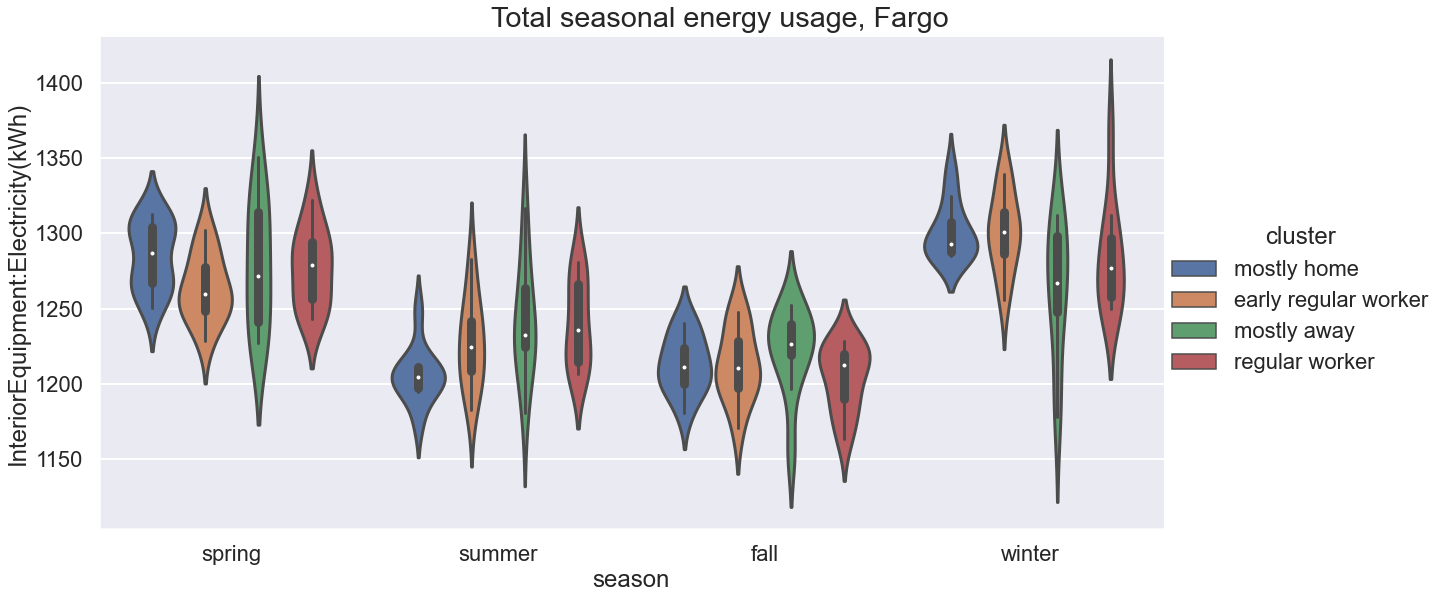

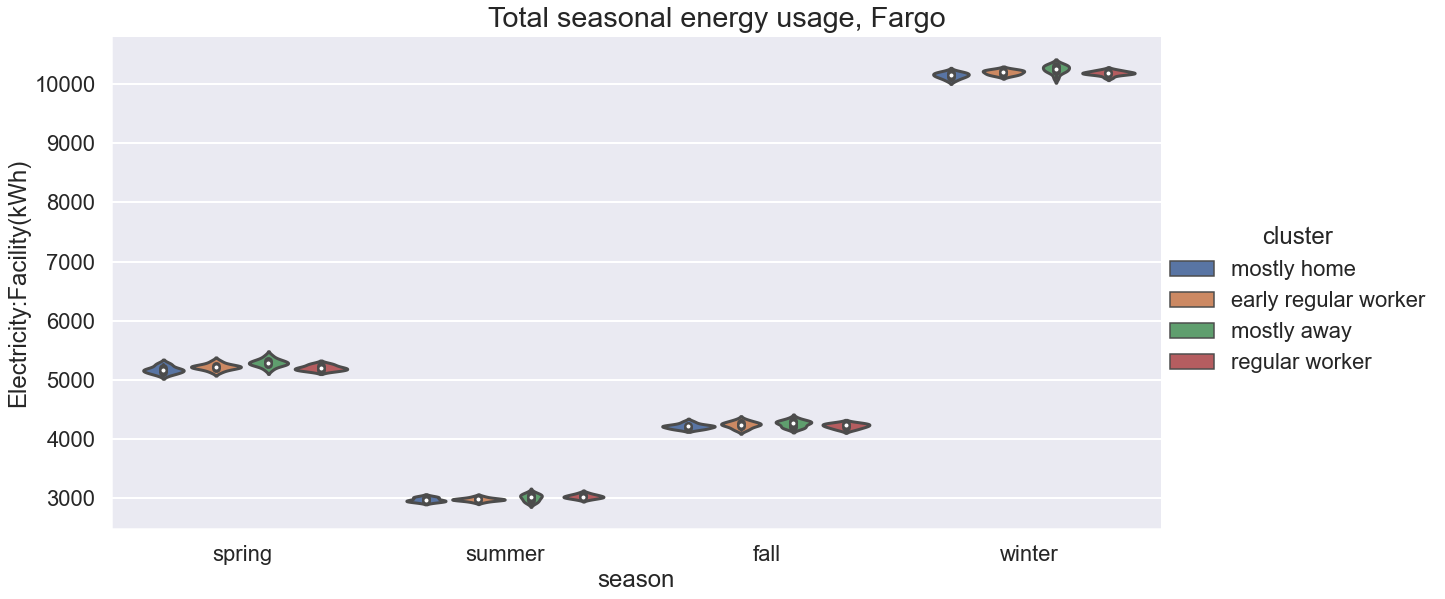

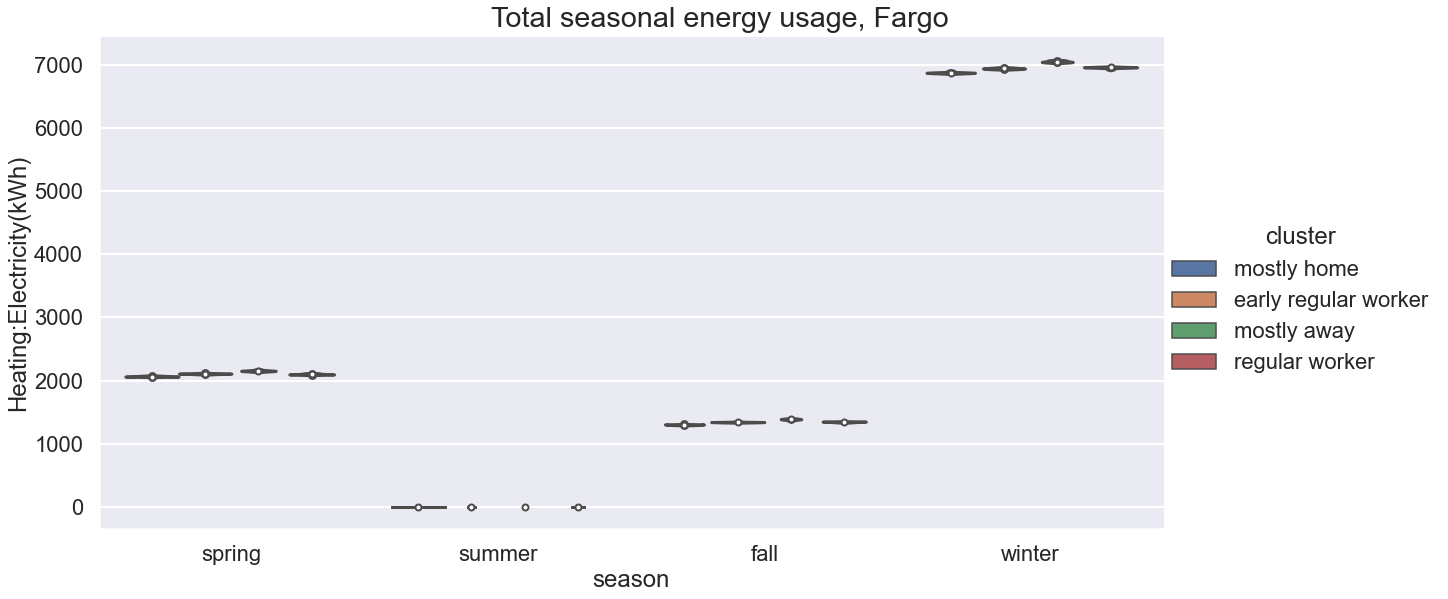

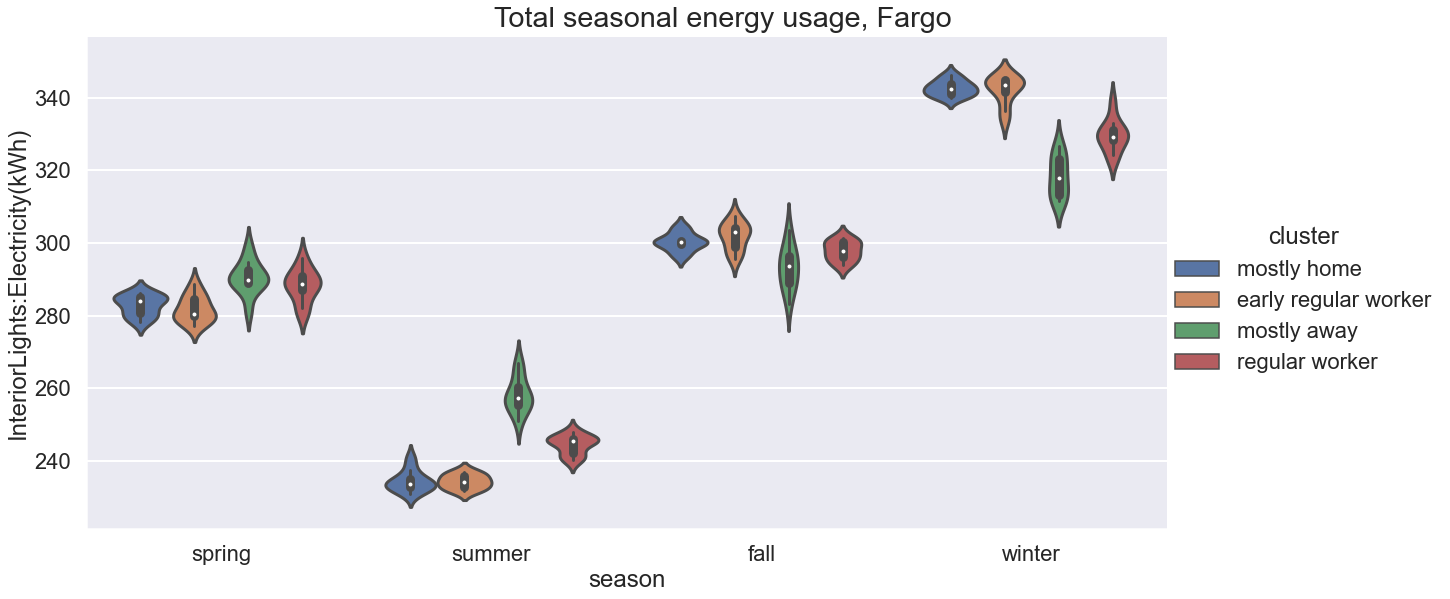

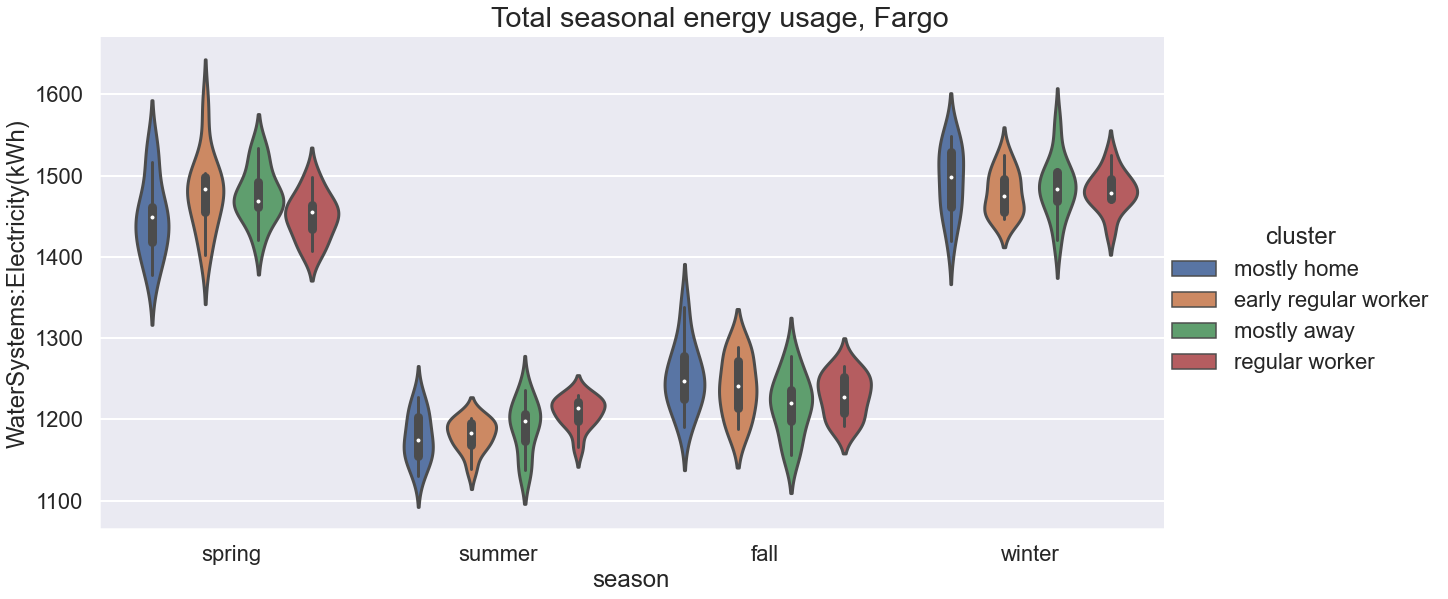

In [216]:
for end_use in ('Cooling:Electricity(kWh)', 'InteriorEquipment:Electricity(kWh)',
                'Electricity:Facility(kWh)', 'Heating:Electricity(kWh)',
                'InteriorLights:Electricity(kWh)', 'WaterSystems:Electricity(kWh)'):
    compare_hourly_energy_usage_by_season(
        occupancies.loc[('Fargo')], CLUSTERS, 'Fargo', end_use
    )
        

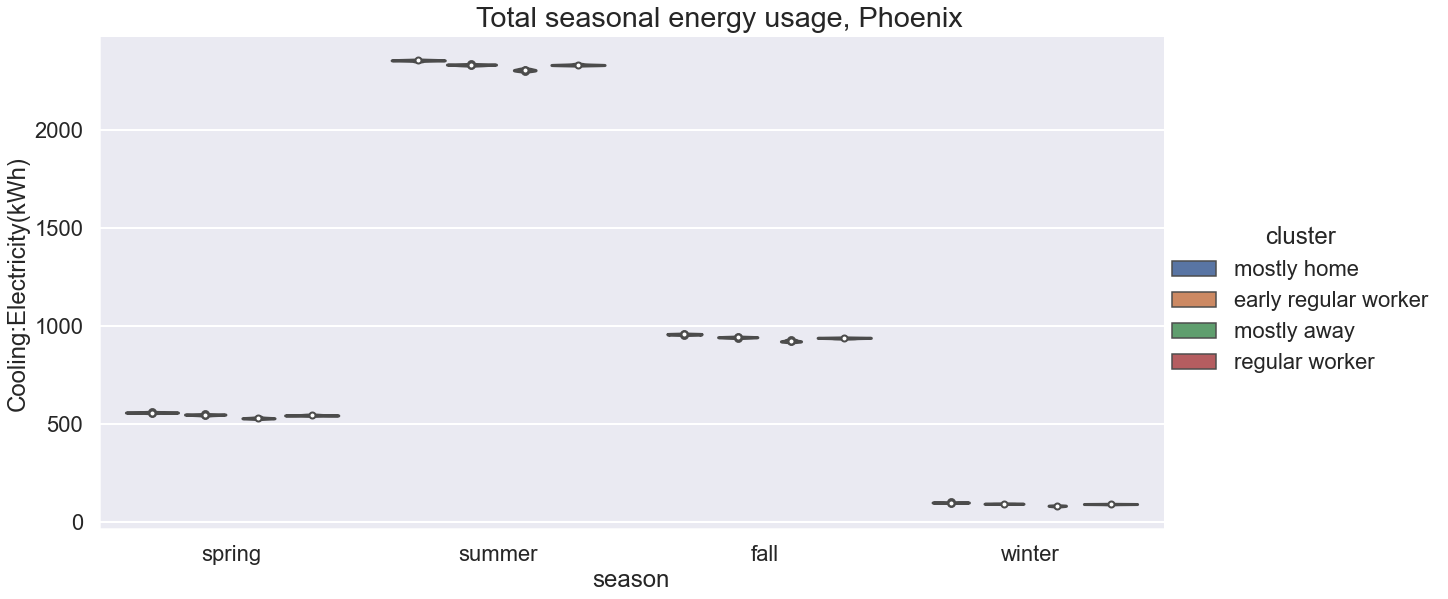

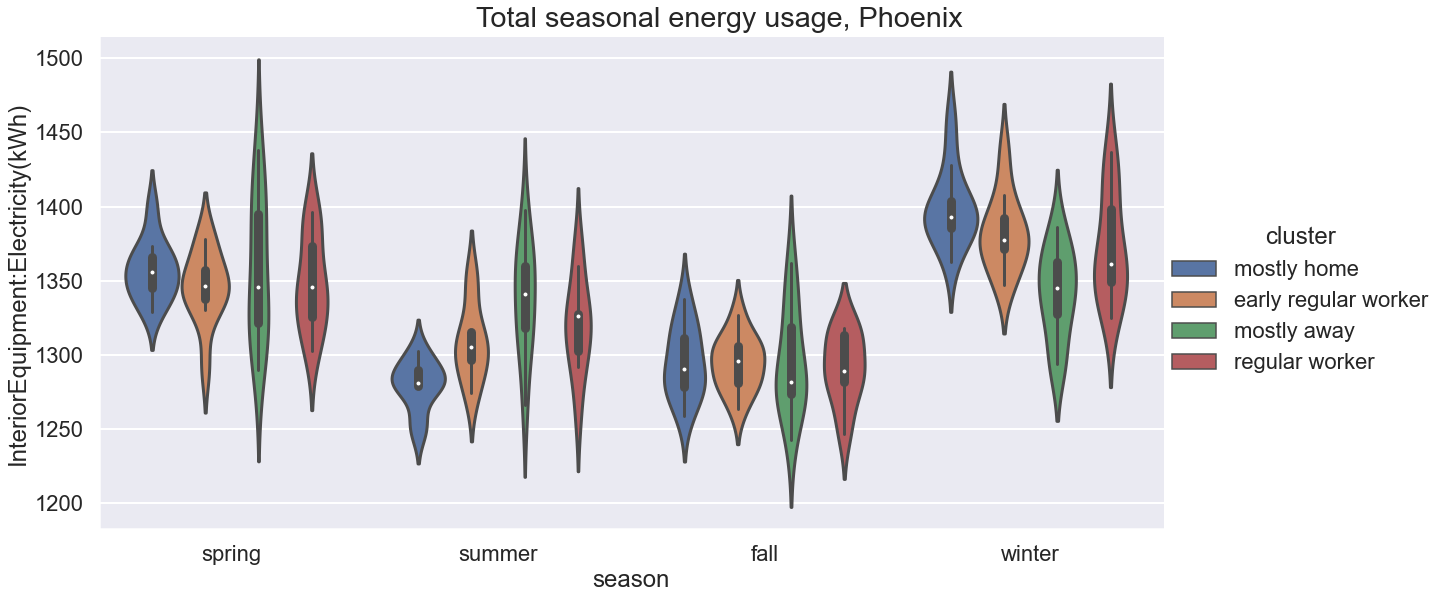

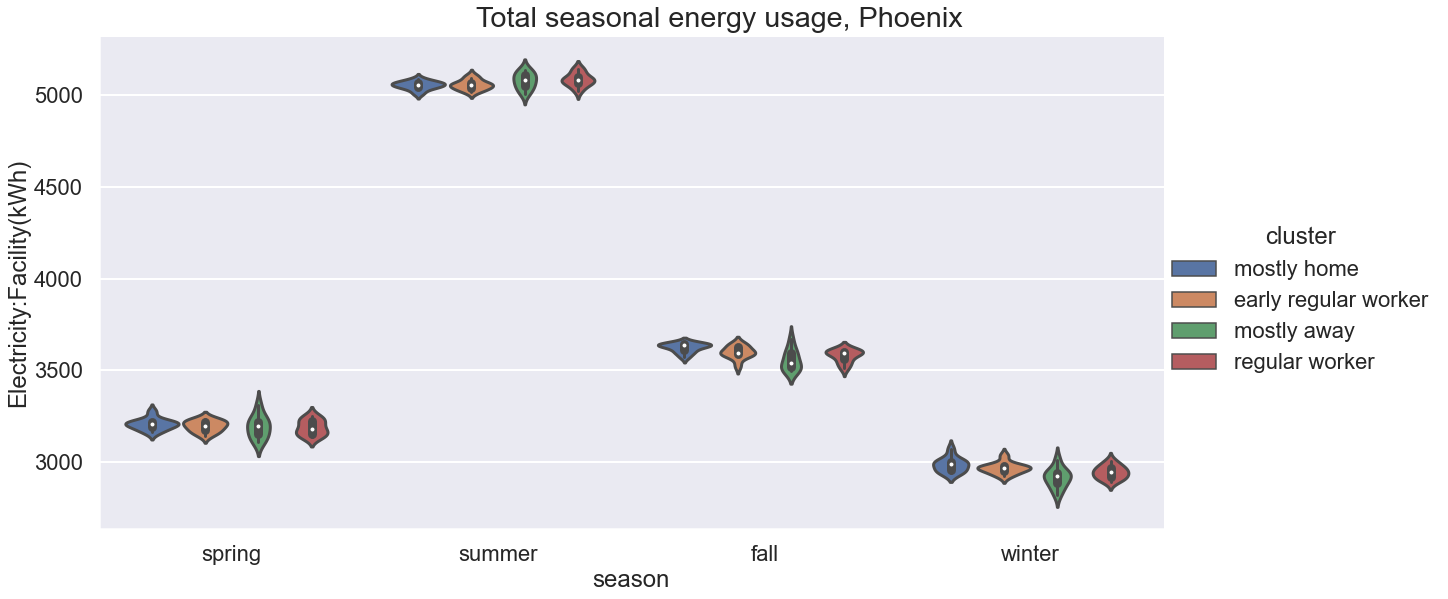

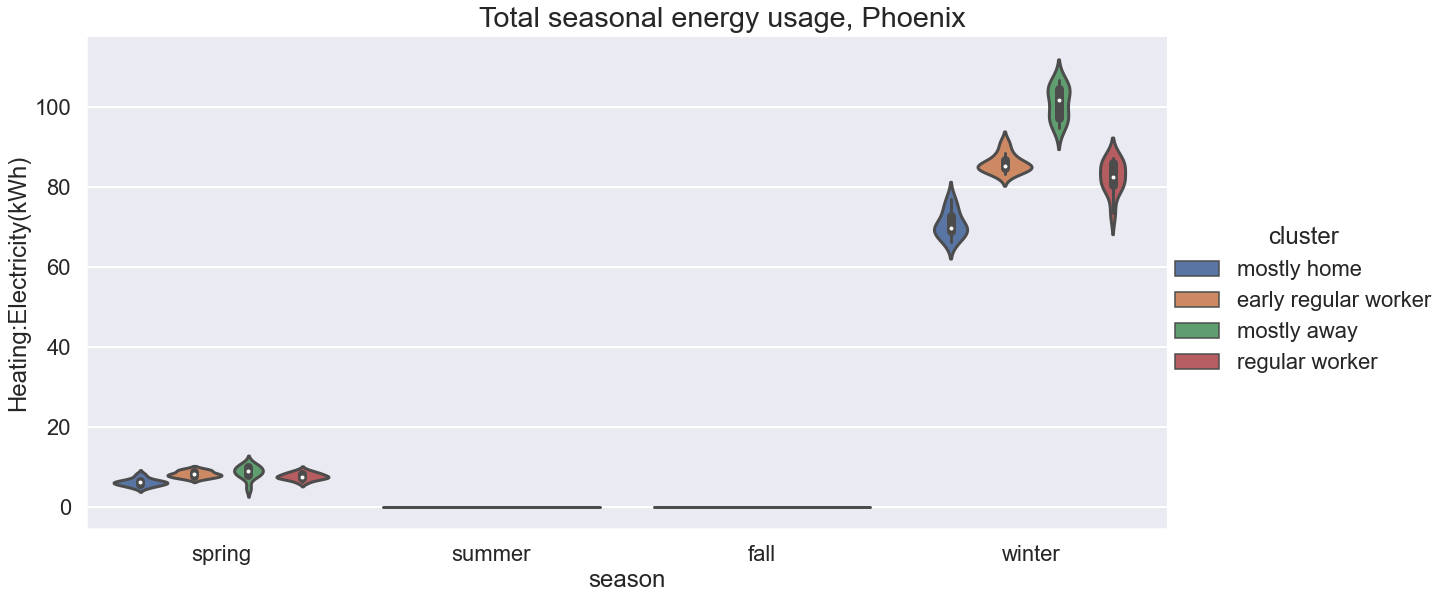

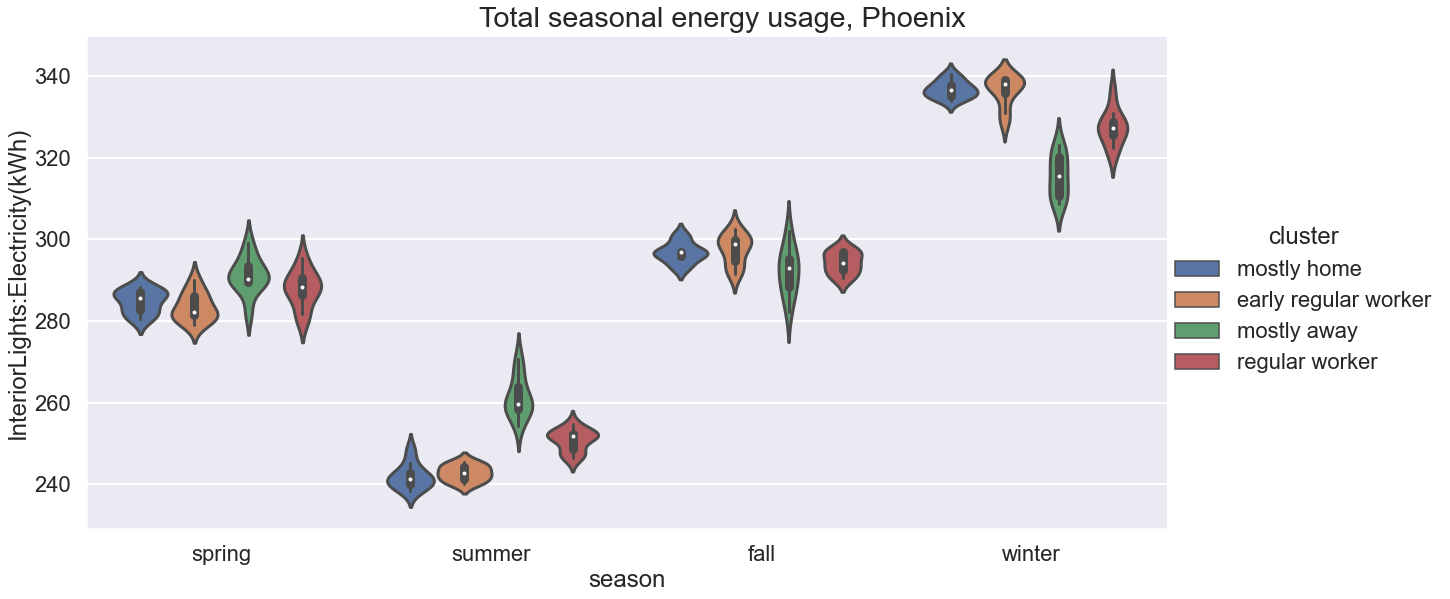

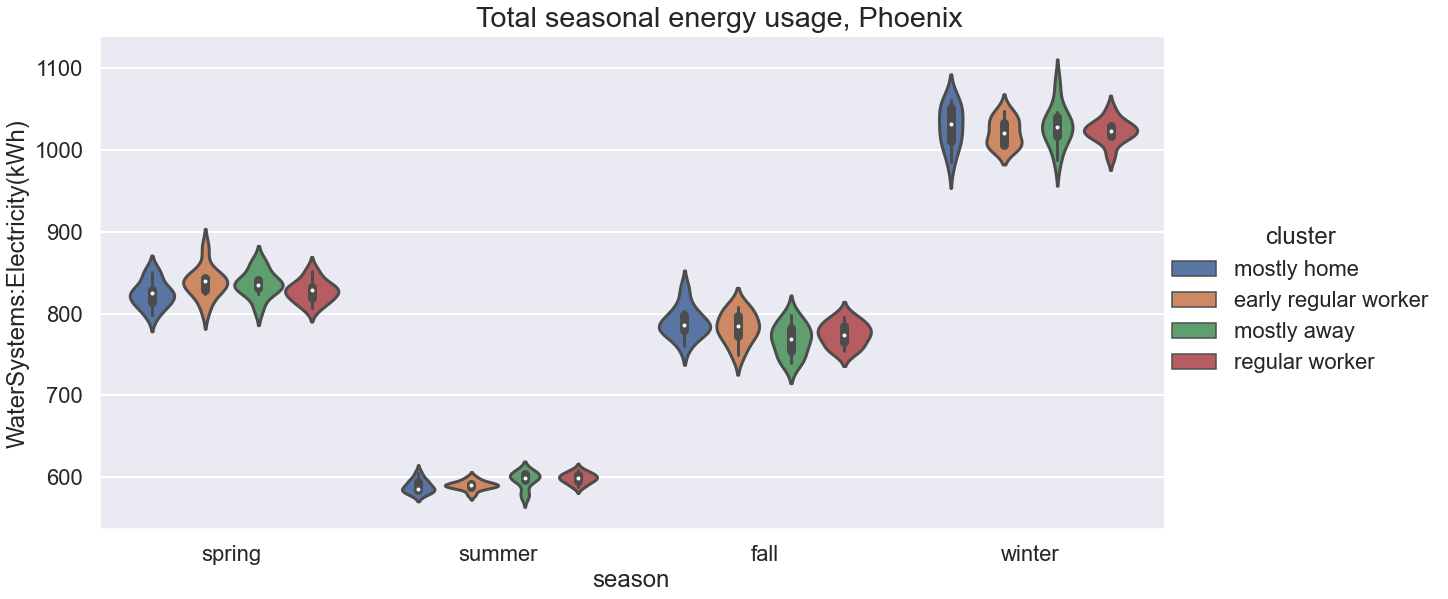

In [218]:
for end_use in ('Cooling:Electricity(kWh)', 'InteriorEquipment:Electricity(kWh)',
                'Electricity:Facility(kWh)', 'Heating:Electricity(kWh)',
                'InteriorLights:Electricity(kWh)', 'WaterSystems:Electricity(kWh)'):
    compare_hourly_energy_usage_by_season(
        occupancies.loc[('Phoenix')], CLUSTERS, 'Phoenix', end_use
    )
        

In [140]:
# Compare reopt results across clusters
location = "Fargo"
cluster_scenarios = results.get_matching_scenarios(
    {
        "num_simulations": [10], "schedules_type": "stochastic",
        "schedules_occupant_types": ["000", "111", "222", "333"],
        "location": location
    }
)


# Plot the reopt results for each cluster
for scenario in cluster_scenarios:
    results.load(scenario_pattern=scenario)
    
data = results.to_dataframe(scenarios=cluster_scenarios)

data = data.loc[data['storage_rebate'] >= 200]
data['utility_rate'] = data['utility'] + ' - ' + data['urdb']

pivot = pd.pivot_table(data, columns='utility_rate',
                       index=['location','schedules_occupant_types',
                              'net_metering_limit', 'storage_rebate']
                      )

loading runs for home-fargo-3-bd-2301-sched-stochastic-occ-000-6498206190...
loading runs for home-fargo-3-bd-2301-sched-stochastic-occ-222-7826246174...
loading runs for home-fargo-3-bd-2301-sched-stochastic-occ-111-851900845...
loading runs for home-fargo-3-bd-2301-sched-stochastic-occ-333-891145238...
